# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [1]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [2]:
def merge_weather_rain_data(data_path):
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weather_array = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weather_array.as_matrix()

    """ Read in the rain data"""
    rain_array = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0])

    rain_array = rain_array.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [3]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        if row[0].month > 10:
            missing_data_rows.append(idx)
            continue # No energy data for the month of November so delete those too.
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

clean_data_array = clean_up(merged_array)

## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [4]:
def create_dataframe(energyDir):
    """ Returns a dataframe that is formed by concatenating all the energy data files """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
energyFrame = create_dataframe('data/2017')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [5]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(clean_data_array,energyFrame)
featureArray = np.delete(clean_data_array,missing_labels,axis=0)        
            

2017-01-01 00:10:00 29060 0
2017-01-01 00:20:00 22260 0
2017-01-01 00:30:00 77630 0
2017-01-01 00:40:00 47870 0
2017-01-01 00:50:00 39400 0
2017-01-01 01:00:00 33420 0
2017-01-01 01:10:00 37830 0
2017-01-01 01:20:00 32670 0
2017-01-01 01:30:00 28250 0
2017-01-01 01:40:00 29980 0
2017-01-01 01:50:00 21270 0
2017-01-01 02:00:00 19600 0
2017-01-01 02:10:00 23560 0
2017-01-01 02:20:00 29330 0
2017-01-01 02:30:00 35320 0
2017-01-01 02:40:00 21480 0
2017-01-01 02:50:00 20330 0
2017-01-01 03:00:00 23330 0
2017-01-01 03:10:00 22760 0
2017-01-01 03:20:00 19360 0
2017-01-01 03:30:00 18870 0
2017-01-01 03:40:00 18740 0
2017-01-01 03:50:00 15930 0
2017-01-01 04:00:00 12600 0
2017-01-01 04:10:00 12700 0
2017-01-01 04:20:00 17000 0
2017-01-01 04:30:00 12600 0
2017-01-01 04:40:00 13820 0
2017-01-01 04:50:00 21200 0
2017-01-01 05:00:00 16790 0
2017-01-01 05:10:00 16310 0
2017-01-01 05:20:00 47020 0
2017-01-01 05:30:00 16890 0
2017-01-01 05:40:00 11400 0
2017-01-01 05:50:00 15670 0
2017-01-01 06:00:00 

2017-01-03 01:00:00 27850 0
2017-01-03 01:10:00 17620 0
2017-01-03 01:20:00 12600 0
2017-01-03 01:30:00 22510 0
2017-01-03 01:40:00 14500 0
2017-01-03 01:50:00 12020 0
2017-01-03 02:00:00 16160 0
2017-01-03 02:10:00 21830 0
2017-01-03 02:20:00 26770 0
2017-01-03 02:30:00 14300 0
2017-01-03 02:40:00 13010 0
2017-01-03 02:50:00 11400 0
2017-01-03 03:00:00 13660 0
2017-01-03 03:10:00 2240 0
Missing label for row 308
Missing label for row 309
Missing label for row 310
Missing label for row 311
Missing label for row 312
Missing label for row 313
Missing label for row 314
Missing label for row 315
Missing label for row 316
Missing label for row 317
Missing label for row 318
Missing label for row 319
Missing label for row 320
Missing label for row 321
Missing label for row 322
Missing label for row 323
Missing label for row 324
Missing label for row 325
Missing label for row 326
Missing label for row 327
Missing label for row 328
Missing label for row 329
Missing label for row 330
Missing lab

2017-01-05 02:40:00 7800 0
2017-01-05 02:50:00 12040 0
2017-01-05 03:00:00 16040 0
2017-01-05 03:10:00 14730 0
2017-01-05 03:20:00 14510 0
2017-01-05 03:30:00 16460 0
2017-01-05 03:40:00 12600 0
2017-01-05 03:50:00 11250 0
2017-01-05 04:00:00 12590 0
2017-01-05 04:10:00 7800 0
2017-01-05 04:20:00 7800 0
2017-01-05 04:30:00 11770 0
2017-01-05 04:40:00 8530 0
2017-01-05 04:50:00 7610 0
2017-01-05 05:00:00 23700 0
2017-01-05 05:10:00 44940 0
2017-01-05 05:20:00 9370 0
2017-01-05 05:30:00 10610 0
2017-01-05 05:40:00 13870 0
2017-01-05 05:50:00 9970 0
2017-01-05 06:00:00 7930 0
2017-01-05 06:10:00 15950 0
2017-01-05 06:20:00 12600 0
2017-01-05 06:30:00 12600 0
2017-01-05 06:40:00 17430 0
2017-01-05 06:50:00 13260 0
2017-01-05 07:00:00 14800 0
2017-01-05 07:10:00 20610 0
2017-01-05 07:20:00 20800 0
2017-01-05 07:30:00 16800 0
2017-01-05 07:40:00 19140 0
2017-01-05 07:50:00 19870 0
2017-01-05 08:00:00 17760 0
2017-01-05 08:10:00 30290 0
2017-01-05 08:20:00 16090 0
2017-01-05 08:30:00 11240 0


2017-01-07 03:10:00 17100 0
2017-01-07 03:20:00 18440 0
2017-01-07 03:30:00 14030 0
2017-01-07 03:40:00 12060 0
2017-01-07 03:50:00 14540 0
2017-01-07 04:00:00 12720 0
2017-01-07 04:10:00 10910 0
2017-01-07 04:20:00 12470 0
2017-01-07 04:30:00 32320 0
2017-01-07 04:40:00 10900 0
2017-01-07 04:50:00 13260 0
2017-01-07 05:00:00 13490 0
2017-01-07 05:10:00 12270 0
2017-01-07 05:20:00 18670 0
2017-01-07 05:30:00 15180 0
2017-01-07 05:40:00 10960 0
2017-01-07 05:50:00 12200 0
2017-01-07 06:00:00 14150 0
2017-01-07 06:10:00 11360 0
2017-01-07 06:20:00 14630 0
2017-01-07 06:30:00 15490 0
2017-01-07 06:40:00 12600 0
2017-01-07 06:50:00 14400 0
2017-01-07 07:00:00 15220 0
2017-01-07 07:10:00 40070 0
2017-01-07 07:20:00 18870 0
2017-01-07 07:30:00 19980 0
2017-01-07 07:40:00 16830 0
2017-01-07 07:50:00 16680 0
2017-01-07 08:00:00 20270 0
2017-01-07 08:10:00 14280 0
2017-01-07 08:20:00 13210 0
2017-01-07 08:30:00 14770 0
2017-01-07 08:40:00 14330 0
2017-01-07 08:50:00 15540 0
2017-01-07 09:00:00 

2017-01-09 04:40:00 12010 0
2017-01-09 04:50:00 12720 0
2017-01-09 05:00:00 16070 0
2017-01-09 05:10:00 14470 0
2017-01-09 05:20:00 12000 0
2017-01-09 05:30:00 10500 0
2017-01-09 05:40:00 30870 0
2017-01-09 05:50:00 16930 0
2017-01-09 06:00:00 14200 0
2017-01-09 06:10:00 16400 0
2017-01-09 06:20:00 12600 0
2017-01-09 06:30:00 12510 0
2017-01-09 06:40:00 16970 0
2017-01-09 06:50:00 13260 0
2017-01-09 07:00:00 13970 0
2017-01-09 07:10:00 51280 0
2017-01-09 07:20:00 31610 0
2017-01-09 07:30:00 14370 0
2017-01-09 07:40:00 59890 0
2017-01-09 07:50:00 49180 0
2017-01-09 08:00:00 20630 0
2017-01-09 08:10:00 26320 0
2017-01-09 08:20:00 19460 0
2017-01-09 08:30:00 24320 0
2017-01-09 08:40:00 28260 0
2017-01-09 08:50:00 44740 0
2017-01-09 09:00:00 17800 0
2017-01-09 09:10:00 16720 0
2017-01-09 09:20:00 37360 60
2017-01-09 09:30:00 10340 73
2017-01-09 09:40:00 9350 62
2017-01-09 09:50:00 13860 53
2017-01-09 10:00:00 9900 84
2017-01-09 10:10:00 10980 53
2017-01-09 10:20:00 16100 71
2017-01-09 10:3

2017-01-11 06:40:00 16930 0
2017-01-11 06:50:00 12240 0
2017-01-11 07:00:00 12030 0
2017-01-11 07:10:00 18510 0
2017-01-11 07:20:00 18600 0
2017-01-11 07:30:00 42180 0
2017-01-11 07:40:00 41330 0
2017-01-11 07:50:00 33210 0
2017-01-11 08:00:00 36470 0
2017-01-11 08:10:00 18240 0
2017-01-11 08:20:00 17110 0
2017-01-11 08:30:00 17650 0
2017-01-11 08:40:00 25850 0
2017-01-11 08:50:00 16610 0
2017-01-11 09:00:00 11450 0
2017-01-11 09:10:00 12930 0
2017-01-11 09:20:00 15200 0
2017-01-11 09:30:00 11470 0
2017-01-11 09:40:00 11680 50
2017-01-11 09:50:00 16960 50
2017-01-11 10:00:00 11200 59
2017-01-11 10:10:00 10370 72
2017-01-11 10:20:00 41330 62
2017-01-11 10:30:00 10440 87
2017-01-11 10:40:00 11660 69
2017-01-11 10:50:00 22540 62
2017-01-11 11:00:00 30200 66
2017-01-11 11:10:00 20830 65
2017-01-11 11:20:00 16880 59
2017-01-11 11:30:00 20110 58
2017-01-11 11:40:00 18970 74
2017-01-11 11:50:00 19170 77
2017-01-11 12:00:00 22070 100
2017-01-11 12:10:00 15240 74
2017-01-11 12:20:00 10050 173
2

2017-01-13 07:20:00 12010 0
2017-01-13 07:30:00 12000 0
2017-01-13 07:40:00 18000 0
2017-01-13 07:50:00 50230 0
2017-01-13 08:00:00 33240 0
2017-01-13 08:10:00 24600 0
2017-01-13 08:20:00 17860 0
2017-01-13 08:30:00 17060 0
2017-01-13 08:40:00 22460 0
2017-01-13 08:50:00 15520 0
2017-01-13 09:00:00 22260 0
2017-01-13 09:10:00 55420 60
2017-01-13 09:20:00 24310 72
2017-01-13 09:30:00 23060 57
2017-01-13 09:40:00 28960 53
2017-01-13 09:50:00 15090 51
2017-01-13 10:00:00 9170 55
2017-01-13 10:10:00 14300 49
2017-01-13 10:20:00 11660 48
2017-01-13 10:30:00 11210 49
2017-01-13 10:40:00 14040 48
2017-01-13 10:50:00 13470 52
2017-01-13 11:00:00 11450 50
2017-01-13 11:10:00 12010 61
2017-01-13 11:20:00 20350 66
2017-01-13 11:30:00 13770 76
2017-01-13 11:40:00 8790 101
2017-01-13 11:50:00 15830 58
2017-01-13 12:00:00 9320 65
2017-01-13 12:30:00 12980 301
2017-01-13 12:40:00 14610 332
2017-01-13 12:50:00 -10640 448
2017-01-13 13:00:00 -9460 477
2017-01-13 13:10:00 -13640 521
2017-01-13 13:20:00 

2017-01-15 09:00:00 176500 136
2017-01-15 09:10:00 44709 81
2017-01-15 09:20:00 24000 93
2017-01-15 09:30:00 22580 78
2017-01-15 09:40:00 22830 53
2017-01-15 09:50:00 16290 213
2017-01-15 10:00:00 12350 222
2017-01-15 10:10:00 4020 318
2017-01-15 10:20:00 9660 199
2017-01-15 10:30:00 22890 198
2017-01-15 10:40:00 2560 295
2017-01-15 10:50:00 1240 513
2017-01-15 11:00:00 123579 387
2017-01-15 11:10:00 22490 491
2017-01-15 11:20:00 -13280 844
2017-01-15 11:30:00 -9310 518
2017-01-15 11:40:00 -30890 1006
2017-01-15 11:50:00 -27340 819
2017-01-15 12:00:00 -35470 648
2017-01-15 12:10:00 -41150 797
2017-01-15 12:20:00 63620 996
2017-01-15 12:30:00 101950 482
2017-01-15 12:40:00 -13590 508
2017-01-15 12:50:00 5340 334
2017-01-15 13:00:00 44078 375
2017-01-15 13:10:00 124718 456
2017-01-15 13:20:00 32720 529
2017-01-15 13:30:00 -16080 535
2017-01-15 13:40:00 -37140 924
2017-01-15 13:50:00 58520 973
2017-01-15 14:00:00 90960 442
2017-01-15 14:10:00 -11730 435
2017-01-15 14:20:00 -8540 419
2017-

2017-01-17 13:30:00 -72740 1403
2017-01-17 13:40:00 -65310 1368
2017-01-17 13:50:00 -66930 1327
2017-01-17 14:00:00 -64100 1260
2017-01-17 14:10:00 -60290 1242
2017-01-17 14:20:00 -52860 1218
2017-01-17 14:30:00 -55250 1146
2017-01-17 14:40:00 -48400 1034
2017-01-17 14:50:00 -23790 1033
2017-01-17 15:00:00 -32830 940
2017-01-17 15:10:00 -24220 699
2017-01-17 15:20:00 -13570 413
2017-01-17 15:30:00 -8240 324
2017-01-17 15:40:00 -3930 318
2017-01-17 15:50:00 10760 55
2017-01-17 16:00:00 12000 29
2017-01-17 16:10:00 13580 58
2017-01-17 16:20:00 15730 80
2017-01-17 16:30:00 20690 63
2017-01-17 16:40:00 25600 65
2017-01-17 16:50:00 103520 80
2017-01-17 17:00:00 28510 64
2017-01-17 17:10:00 23580 44
2017-01-17 17:20:00 15060 0
2017-01-17 17:30:00 19260 0
2017-01-17 17:40:00 21610 0
2017-01-17 17:50:00 19220 0
2017-01-17 18:00:00 22590 0
2017-01-17 18:10:00 84800 0
2017-01-17 18:20:00 37280 0
2017-01-17 18:30:00 37930 0
2017-01-17 18:40:00 25870 0
2017-01-17 18:50:00 26900 0
2017-01-17 19:00:

2017-01-19 13:50:00 -11270 1458
2017-01-19 14:00:00 -54200 1428
2017-01-19 14:10:00 -58980 1362
2017-01-19 14:20:00 -58200 1299
2017-01-19 14:30:00 -54480 1242
2017-01-19 14:40:00 -52340 1178
2017-01-19 14:50:00 -53520 1106
2017-01-19 15:00:00 -43770 1021
2017-01-19 15:10:00 -29560 716
2017-01-19 15:20:00 -18140 559
2017-01-19 15:30:00 -8300 278
2017-01-19 15:40:00 9550 259
2017-01-19 15:50:00 147490 13
2017-01-19 16:00:00 275090 81
2017-01-19 16:10:00 226990 56
2017-01-19 16:20:00 265960 54
2017-01-19 16:30:00 176810 98
2017-01-19 16:40:00 50520 73
2017-01-19 16:50:00 26030 71
2017-01-19 17:00:00 36210 63
2017-01-19 17:10:00 27130 49
2017-01-19 17:20:00 24400 0
2017-01-19 17:30:00 24430 0
2017-01-19 17:40:00 37040 0
2017-01-19 17:50:00 37730 0
2017-01-19 18:00:00 41880 0
2017-01-19 18:10:00 63770 0
2017-01-19 18:20:00 29260 0
2017-01-19 18:30:00 137290 0
2017-01-19 18:40:00 161519 0
2017-01-19 18:50:00 146238 0
2017-01-19 19:00:00 117660 0
2017-01-19 19:10:00 147395 0
2017-01-19 19:20

2017-01-21 13:20:00 -85700 1593
2017-01-21 13:30:00 -67830 1575
2017-01-21 13:40:00 -76990 1536
2017-01-21 13:50:00 -75430 1504
2017-01-21 14:00:00 -68090 1440
2017-01-21 14:10:00 -33870 1387
2017-01-21 14:20:00 -16820 1295
2017-01-21 14:30:00 -52730 1233
2017-01-21 14:40:00 -53770 1146
2017-01-21 14:50:00 -51960 1071
2017-01-21 15:00:00 -45820 1013
2017-01-21 15:10:00 -35740 934
2017-01-21 15:20:00 -19190 591
2017-01-21 15:30:00 -1510 516
2017-01-21 15:40:00 10330 242
2017-01-21 15:50:00 12170 155
2017-01-21 16:00:00 21660 103
2017-01-21 16:10:00 23830 107
2017-01-21 16:20:00 64200 75
2017-01-21 16:30:00 164620 104
2017-01-21 16:40:00 69220 102
2017-01-21 16:50:00 56360 74
2017-01-21 17:00:00 133040 69
2017-01-21 17:10:00 137370 55
2017-01-21 17:20:00 59110 0
2017-01-21 17:30:00 51579 0
2017-01-21 17:40:00 62030 0
2017-01-21 17:50:00 25950 0
2017-01-21 18:00:00 37410 0
2017-01-21 18:10:00 26860 0
2017-01-21 18:20:00 23680 0
2017-01-21 18:30:00 24960 0
2017-01-21 18:40:00 24700 0
2017-

2017-01-23 14:10:00 20850 103
2017-01-23 14:20:00 21510 9
2017-01-23 14:30:00 17810 9
2017-01-23 14:40:00 3470 264
2017-01-23 14:50:00 8940 234
2017-01-23 15:00:00 6830 207
2017-01-23 15:10:00 6400 207
2017-01-23 15:20:00 14890 141
2017-01-23 15:30:00 14280 105
2017-01-23 15:40:00 14430 78
2017-01-23 15:50:00 19620 74
2017-01-23 16:00:00 17080 87
2017-01-23 16:10:00 40500 69
2017-01-23 16:20:00 19210 74
2017-01-23 16:30:00 18480 45
2017-01-23 16:40:00 17920 62
2017-01-23 16:50:00 58030 55
2017-01-23 17:00:00 26970 0
2017-01-23 17:10:00 23080 0
2017-01-23 17:20:00 24440 0
2017-01-23 17:30:00 24920 0
2017-01-23 17:40:00 18180 0
2017-01-23 17:50:00 88970 0
2017-01-23 18:00:00 51930 0
2017-01-23 18:10:00 56030 0
2017-01-23 18:20:00 26140 0
2017-01-23 18:30:00 31500 0
2017-01-23 18:40:00 69620 0
2017-01-23 18:50:00 29470 0
2017-01-23 19:00:00 31940 0
2017-01-23 19:10:00 20700 0
2017-01-23 19:20:00 21150 0
2017-01-23 19:30:00 53480 0
2017-01-23 19:40:00 100050 0
2017-01-23 19:50:00 26700 0
2

2017-01-25 14:40:00 410 295
2017-01-25 14:50:00 -11450 505
2017-01-25 15:00:00 -24450 685
2017-01-25 15:10:00 -37240 962
2017-01-25 15:20:00 -16480 696
2017-01-25 15:30:00 -16280 711
2017-01-25 15:40:00 3120 338
2017-01-25 15:50:00 4900 310
2017-01-25 16:00:00 5110 225
2017-01-25 16:10:00 56560 220
2017-01-25 16:20:00 5600 194
2017-01-25 16:30:00 4190 155
2017-01-25 16:40:00 13640 103
2017-01-25 16:50:00 14430 87
2017-01-25 17:00:00 14760 74
2017-01-25 17:10:00 17190 63
2017-01-25 17:20:00 18260 46
2017-01-25 17:30:00 18380 0
2017-01-25 17:40:00 19500 0
2017-01-25 17:50:00 18730 0
2017-01-25 18:00:00 23510 0
2017-01-25 18:10:00 36960 0
2017-01-25 18:20:00 55550 0
2017-01-25 18:30:00 96200 0
2017-01-25 18:40:00 176340 0
2017-01-25 18:50:00 167610 0
2017-01-25 19:00:00 131630 0
2017-01-25 19:10:00 116480 0
2017-01-25 19:20:00 92580 0
2017-01-25 19:30:00 25490 0
2017-01-25 19:40:00 23890 0
2017-01-25 19:50:00 130130 0
2017-01-25 20:00:00 95520 0
2017-01-25 20:10:00 133000 0
2017-01-25 20:

2017-01-27 14:00:00 -23900 774
2017-01-27 14:10:00 -22040 759
2017-01-27 14:20:00 -32190 962
2017-01-27 14:30:00 -24220 729
2017-01-27 14:40:00 -9360 674
2017-01-27 14:50:00 -6260 516
2017-01-27 15:00:00 -2210 399
2017-01-27 15:10:00 3140 353
2017-01-27 15:20:00 6650 411
2017-01-27 15:30:00 34460 428
2017-01-27 15:40:00 30560 342
2017-01-27 15:50:00 5649 273
2017-01-27 16:00:00 114798 247
2017-01-27 16:10:00 133639 200
2017-01-27 16:20:00 113589 160
2017-01-27 16:30:00 19800 134
2017-01-27 16:40:00 22110 83
2017-01-27 16:50:00 27040 79
2017-01-27 17:00:00 14970 64
2017-01-27 17:10:00 38245 46
2017-01-27 17:20:00 23020 0
2017-01-27 17:30:00 26440 0
2017-01-27 17:40:00 27210 0
2017-01-27 17:50:00 38520 0
2017-01-27 18:00:00 157648 0
2017-01-27 18:10:00 257670 0
2017-01-27 18:20:00 268170 0
2017-01-27 18:30:00 236780 0
2017-01-27 18:40:00 186650 0
2017-01-27 18:50:00 168980 0
2017-01-27 19:00:00 128340 0
2017-01-27 19:10:00 111150 0
2017-01-27 19:20:00 105920 0
2017-01-27 19:30:00 110030 

2017-01-29 14:50:00 -17730 313
2017-01-29 15:00:00 -20870 485
2017-01-29 15:10:00 -35760 608
2017-01-29 15:20:00 -35730 933
2017-01-29 15:30:00 -33350 960
2017-01-29 15:40:00 -1290 278
2017-01-29 15:50:00 5320 198
2017-01-29 16:00:00 10360 222
2017-01-29 16:10:00 13770 189
2017-01-29 16:20:00 7190 178
2017-01-29 16:30:00 6350 197
2017-01-29 16:40:00 32000 179
2017-01-29 16:50:00 15630 54
2017-01-29 17:00:00 18840 76
2017-01-29 17:10:00 22050 70
2017-01-29 17:20:00 24300 47
2017-01-29 17:30:00 20210 0
2017-01-29 17:40:00 19170 0
2017-01-29 17:50:00 20140 0
2017-01-29 18:00:00 16760 0
2017-01-29 18:10:00 16910 0
2017-01-29 18:20:00 104810 0
2017-01-29 18:30:00 169736 0
2017-01-29 18:40:00 112300 0
2017-01-29 18:50:00 105110 0
2017-01-29 19:00:00 122539 0
2017-01-29 19:10:00 31100 0
2017-01-29 19:20:00 20070 0
2017-01-29 19:30:00 34310 0
2017-01-29 19:40:00 35570 0
2017-01-29 19:50:00 20810 0
2017-01-29 20:00:00 128780 0
2017-01-29 20:10:00 36020 0
2017-01-29 20:20:00 103260 0
2017-01-29 

2017-01-31 16:00:00 13530 83
2017-01-31 16:10:00 47808 70
2017-01-31 16:20:00 44250 78
2017-01-31 16:30:00 17570 72
2017-01-31 16:40:00 21360 67
2017-01-31 16:50:00 24670 60
2017-01-31 17:00:00 63790 55
2017-01-31 17:10:00 112220 0
2017-01-31 17:20:00 37470 0
2017-01-31 17:30:00 25760 0
2017-01-31 17:40:00 23170 0
2017-01-31 17:50:00 24120 0
2017-01-31 18:00:00 24560 0
2017-01-31 18:10:00 20680 0
2017-01-31 18:20:00 21250 0
2017-01-31 18:30:00 52490 0
2017-01-31 18:40:00 21560 0
2017-01-31 18:50:00 21600 0
2017-01-31 19:00:00 25430 0
2017-01-31 19:10:00 22080 0
2017-01-31 19:20:00 21050 0
2017-01-31 19:30:00 23770 0
2017-01-31 19:40:00 28250 0
2017-01-31 19:50:00 25700 0
2017-01-31 20:00:00 20930 0
2017-01-31 20:10:00 81980 0
2017-01-31 20:20:00 22380 0
2017-01-31 20:30:00 22190 0
2017-01-31 20:40:00 38000 0
2017-01-31 20:50:00 25200 0
2017-01-31 21:00:00 21000 0
2017-01-31 21:10:00 22600 0
2017-01-31 21:20:00 43090 0
2017-01-31 21:30:00 18090 0
2017-01-31 21:40:00 16560 0
2017-01-31 2

2017-02-02 17:40:00 37520 0
2017-02-02 17:50:00 24190 0
2017-02-02 18:00:00 20430 0
2017-02-02 18:10:00 42380 0
2017-02-02 18:20:00 25110 0
2017-02-02 18:30:00 102200 0
2017-02-02 18:40:00 39650 0
2017-02-02 18:50:00 41420 0
2017-02-02 19:00:00 34240 0
2017-02-02 19:10:00 26800 0
2017-02-02 19:20:00 41720 0
2017-02-02 19:30:00 31800 0
2017-02-02 19:40:00 75370 0
2017-02-02 19:50:00 82790 0
2017-02-02 20:00:00 148800 0
2017-02-02 20:10:00 90770 0
2017-02-02 20:20:00 82280 0
2017-02-02 20:30:00 26980 0
2017-02-02 20:40:00 35990 0
2017-02-02 20:50:00 21100 0
2017-02-02 21:00:00 20870 0
2017-02-02 21:10:00 63840 0
2017-02-02 21:20:00 146070 0
2017-02-02 21:30:00 64430 0
2017-02-02 21:40:00 21780 0
2017-02-02 21:50:00 25730 0
2017-02-02 22:00:00 15520 0
2017-02-02 22:10:00 40910 0
2017-02-02 22:20:00 22600 0
2017-02-02 22:30:00 19960 0
2017-02-02 22:40:00 17550 0
2017-02-02 22:50:00 22200 0
2017-02-02 23:00:00 64930 0
2017-02-02 23:10:00 86590 0
2017-02-02 23:20:00 26360 0
2017-02-02 23:30:

2017-02-04 18:00:00 15400 0
2017-02-04 18:10:00 11430 0
2017-02-04 18:20:00 14720 0
2017-02-04 18:30:00 14710 0
2017-02-04 18:40:00 16710 0
2017-02-04 18:50:00 17560 0
2017-02-04 19:00:00 21220 0
2017-02-04 19:10:00 16190 0
2017-02-04 19:20:00 15060 0
2017-02-04 19:30:00 15080 0
2017-02-04 19:40:00 35244 0
2017-02-04 19:50:00 16380 0
2017-02-04 20:00:00 17890 0
2017-02-04 20:10:00 16590 0
2017-02-04 20:20:00 10880 0
2017-02-04 20:30:00 11430 0
2017-02-04 20:40:00 15310 0
2017-02-04 20:50:00 12620 0
2017-02-04 21:00:00 11040 0
2017-02-04 21:10:00 12830 0
2017-02-04 21:20:00 15570 0
2017-02-04 21:30:00 11350 0
2017-02-04 21:40:00 11550 0
2017-02-04 21:50:00 17270 0
2017-02-04 22:00:00 18860 0
2017-02-04 22:10:00 14960 0
2017-02-04 22:20:00 13630 0
2017-02-04 22:30:00 14780 0
2017-02-04 22:40:00 71040 0
2017-02-04 22:50:00 26930 0
2017-02-04 23:00:00 50470 0
2017-02-04 23:10:00 24410 0
2017-02-04 23:20:00 25670 0
2017-02-04 23:30:00 26780 0
2017-02-04 23:40:00 20790 0
2017-02-04 23:50:00 

2017-02-06 18:40:00 20070 0
2017-02-06 18:50:00 72860 0
2017-02-06 19:00:00 107970 0
2017-02-06 19:10:00 119030 0
2017-02-06 19:20:00 143400 0
2017-02-06 19:30:00 34760 0
2017-02-06 19:40:00 37470 0
2017-02-06 19:50:00 43810 0
2017-02-06 20:00:00 156870 0
2017-02-06 20:10:00 136259 0
2017-02-06 20:20:00 37300 0
2017-02-06 20:30:00 58710 0
2017-02-06 20:40:00 38810 0
2017-02-06 20:50:00 34330 0
2017-02-06 21:00:00 43430 0
2017-02-06 21:10:00 42630 0
2017-02-06 21:20:00 36730 0
2017-02-06 21:30:00 33790 0
2017-02-06 21:40:00 33980 0
2017-02-06 21:50:00 36540 0
2017-02-06 22:00:00 30130 0
2017-02-06 22:10:00 35750 0
2017-02-06 22:20:00 35190 0
2017-02-06 22:30:00 32780 0
2017-02-06 22:40:00 34500 0
2017-02-06 22:50:00 36530 0
2017-02-06 23:00:00 63910 0
2017-02-06 23:10:00 36630 0
2017-02-06 23:20:00 32690 0
2017-02-06 23:30:00 29520 0
2017-02-06 23:40:00 33340 0
2017-02-06 23:50:00 31580 0
2017-02-07 00:00:00 27530 0
2017-02-07 00:10:00 31130 0
2017-02-07 00:20:00 25350 0
2017-02-07 00:3

Missing label for row 5560
Missing label for row 5561
Missing label for row 5562
Missing label for row 5563
Missing label for row 5564
Missing label for row 5565
Missing label for row 5566
Missing label for row 5567
Missing label for row 5568
Missing label for row 5569
Missing label for row 5570
Missing label for row 5571
Missing label for row 5572
Missing label for row 5573
Missing label for row 5574
Missing label for row 5575
Missing label for row 5576
Missing label for row 5577
Missing label for row 5578
Missing label for row 5579
Missing label for row 5580
Missing label for row 5581
Missing label for row 5582
Missing label for row 5583
Missing label for row 5584
Missing label for row 5585
Missing label for row 5586
Missing label for row 5587
Missing label for row 5588
Missing label for row 5589
Missing label for row 5590
Missing label for row 5591
Missing label for row 5592
Missing label for row 5593
Missing label for row 5594
Missing label for row 5595
Missing label for row 5596
M

2017-02-10 21:50:00 28330 0
2017-02-10 22:00:00 28540 0
2017-02-10 22:10:00 33390 0
2017-02-10 22:20:00 23580 0
2017-02-10 22:30:00 20500 0
2017-02-10 22:40:00 28360 0
2017-02-10 22:50:00 29690 0
2017-02-10 23:00:00 56670 0
2017-02-10 23:10:00 74950 0
2017-02-10 23:20:00 97410 0
2017-02-10 23:30:00 84350 0
2017-02-10 23:40:00 26490 0
2017-02-10 23:50:00 21810 0
2017-02-11 00:00:00 22410 0
2017-02-11 00:10:00 110660 0
2017-02-11 00:20:00 115170 0
2017-02-11 00:30:00 108680 0
2017-02-11 00:40:00 97180 0
2017-02-11 00:50:00 18680 0
2017-02-11 01:00:00 22520 0
2017-02-11 01:10:00 19480 0
2017-02-11 01:20:00 16240 0
2017-02-11 01:30:00 20540 0
2017-02-11 01:40:00 19290 0
2017-02-11 01:50:00 19170 0
2017-02-11 02:00:00 16840 0
2017-02-11 02:10:00 15060 0
2017-02-11 02:20:00 12790 0
2017-02-11 02:30:00 17180 0
2017-02-11 02:40:00 19710 0
2017-02-11 02:50:00 22110 0
2017-02-11 03:00:00 48030 0
2017-02-11 03:10:00 18370 0
2017-02-11 03:20:00 16200 0
2017-02-11 03:30:00 20200 0
2017-02-11 03:40:

2017-02-12 23:10:00 86240 0
2017-02-12 23:20:00 28730 0
2017-02-12 23:30:00 30840 0
2017-02-12 23:40:00 36140 0
2017-02-12 23:50:00 46040 0
2017-02-13 00:00:00 40420 0
2017-02-13 00:10:00 30570 0
2017-02-13 00:20:00 26070 0
2017-02-13 00:30:00 24140 0
2017-02-13 00:40:00 15110 0
2017-02-13 00:50:00 12990 0
2017-02-13 01:00:00 16290 0
2017-02-13 01:10:00 15820 0
2017-02-13 01:20:00 12780 0
2017-02-13 01:30:00 12650 0
2017-02-13 01:40:00 17800 0
2017-02-13 01:50:00 12630 0
2017-02-13 02:00:00 29270 0
2017-02-13 02:10:00 21270 0
2017-02-13 02:20:00 15710 0
2017-02-13 02:30:00 11910 0
2017-02-13 02:40:00 13190 0
2017-02-13 02:50:00 15460 0
2017-02-13 03:00:00 17790 0
2017-02-13 03:10:00 17610 0
2017-02-13 03:20:00 21660 0
2017-02-13 03:30:00 16790 0
2017-02-13 03:40:00 15180 0
2017-02-13 03:50:00 15700 0
2017-02-13 04:00:00 13180 0
2017-02-13 04:10:00 29260 0
2017-02-13 04:20:00 16950 0
2017-02-13 04:30:00 20670 0
2017-02-13 04:40:00 13180 0
2017-02-13 04:50:00 12870 0
2017-02-13 05:00:00 

2017-02-14 23:50:00 137800 0
2017-02-15 00:00:00 158800 0
2017-02-15 00:10:00 149780 0
2017-02-15 00:20:00 124420 0
2017-02-15 00:30:00 104040 0
2017-02-15 00:40:00 122500 0
2017-02-15 00:50:00 99210 0
2017-02-15 01:00:00 18320 0
2017-02-15 01:10:00 12840 0
2017-02-15 01:20:00 8340 0
2017-02-15 01:30:00 8820 0
2017-02-15 01:40:00 12780 0
2017-02-15 01:50:00 26420 0
2017-02-15 02:00:00 13990 0
2017-02-15 02:10:00 13590 0
2017-02-15 02:20:00 9750 0
2017-02-15 02:30:00 7800 0
2017-02-15 02:40:00 9260 0
2017-02-15 02:50:00 13770 0
2017-02-15 03:00:00 7800 0
2017-02-15 03:10:00 7800 0
2017-02-15 03:20:00 16570 0
2017-02-15 03:30:00 13250 0
2017-02-15 03:40:00 12680 0
2017-02-15 03:50:00 15920 0
2017-02-15 04:00:00 28360 0
2017-02-15 04:10:00 9910 0
2017-02-15 04:20:00 15150 0
2017-02-15 04:30:00 12440 0
2017-02-15 04:40:00 7720 0
2017-02-15 04:50:00 7590 0
2017-02-15 05:00:00 13180 0
2017-02-15 05:10:00 7350 0
2017-02-15 05:20:00 7300 0
2017-02-15 05:30:00 11350 0
2017-02-15 05:40:00 10130 

2017-02-16 23:50:00 25340 0
2017-02-17 00:00:00 27030 0
2017-02-17 00:10:00 22850 0
2017-02-17 00:20:00 21980 0
2017-02-17 00:30:00 29960 0
2017-02-17 00:40:00 25070 0
2017-02-17 00:50:00 17400 0
2017-02-17 01:00:00 19090 0
2017-02-17 01:10:00 15240 0
2017-02-17 01:20:00 16990 0
2017-02-17 01:30:00 26950 0
2017-02-17 01:40:00 15870 0
2017-02-17 01:50:00 11600 0
2017-02-17 02:00:00 11860 0
2017-02-17 02:10:00 17080 0
2017-02-17 02:20:00 18390 0
2017-02-17 02:30:00 16720 0
2017-02-17 02:40:00 15130 0
2017-02-17 02:50:00 14860 0
2017-02-17 03:00:00 15090 0
2017-02-17 03:10:00 18490 0
2017-02-17 03:20:00 38820 0
2017-02-17 03:30:00 16770 0
2017-02-17 03:40:00 16850 0
2017-02-17 03:50:00 17110 0
2017-02-17 04:00:00 12720 0
2017-02-17 04:10:00 17400 0
2017-02-17 04:20:00 20080 0
2017-02-17 04:30:00 13860 0
2017-02-17 04:40:00 11570 0
2017-02-17 04:50:00 13440 0
2017-02-17 05:00:00 16150 0
2017-02-17 05:10:00 11270 0
2017-02-17 05:20:00 26600 0
2017-02-17 05:30:00 15800 0
2017-02-17 05:40:00 

2017-02-19 00:00:00 35940 0
2017-02-19 00:10:00 33940 0
2017-02-19 00:20:00 26570 0
2017-02-19 00:30:00 23190 0
2017-02-19 00:40:00 25950 0
2017-02-19 00:50:00 30620 0
2017-02-19 01:00:00 22900 0
2017-02-19 01:10:00 21570 0
2017-02-19 01:20:00 26080 0
2017-02-19 01:30:00 23280 0
2017-02-19 01:40:00 34890 0
2017-02-19 01:50:00 24530 0
2017-02-19 02:00:00 23240 0
2017-02-19 02:10:00 22660 0
2017-02-19 02:20:00 22070 0
2017-02-19 02:30:00 18080 0
2017-02-19 02:40:00 9970 0
2017-02-19 02:50:00 10570 0
2017-02-19 03:00:00 13550 0
2017-02-19 03:10:00 8440 0
2017-02-19 03:20:00 8400 0
2017-02-19 03:30:00 17740 0
2017-02-19 03:40:00 19630 0
2017-02-19 03:50:00 32600 0
2017-02-19 04:00:00 15620 0
2017-02-19 04:10:00 14740 0
2017-02-19 04:20:00 8800 0
2017-02-19 04:30:00 9130 0
2017-02-19 04:40:00 11000 0
2017-02-19 04:50:00 7200 0
2017-02-19 05:00:00 7310 0
2017-02-19 05:10:00 12700 0
2017-02-19 05:20:00 7580 0
2017-02-19 05:30:00 13630 0
2017-02-19 05:40:00 14890 0
2017-02-19 05:50:00 8910 0
2

2017-02-21 02:30:00 22992 0
2017-02-21 02:40:00 8290 0
2017-02-21 02:50:00 12780 0
2017-02-21 03:00:00 7800 0
2017-02-21 03:10:00 7800 0
2017-02-21 03:20:00 12920 0
2017-02-21 03:30:00 8700 0
2017-02-21 03:40:00 12080 0
2017-02-21 03:50:00 17180 0
2017-02-21 04:00:00 14080 0
2017-02-21 04:10:00 13200 0
2017-02-21 04:20:00 15790 0
2017-02-21 04:30:00 15770 0
2017-02-21 04:40:00 27940 0
2017-02-21 04:50:00 12490 0
2017-02-21 05:00:00 12070 0
2017-02-21 05:10:00 7620 0
2017-02-21 05:20:00 7380 0
2017-02-21 05:30:00 16200 0
2017-02-21 05:40:00 13680 0
2017-02-21 05:50:00 9310 0
2017-02-21 06:00:00 11960 0
2017-02-21 06:10:00 8730 0
2017-02-21 06:20:00 7330 0
2017-02-21 06:30:00 11200 0
2017-02-21 06:40:00 14770 0
2017-02-21 06:50:00 28960 0
2017-02-21 07:00:00 14450 0
2017-02-21 07:10:00 15510 0
2017-02-21 07:20:00 17030 0
2017-02-21 07:30:00 18370 0
2017-02-21 07:40:00 48160 0
2017-02-21 07:50:00 45450 0
2017-02-21 08:00:00 15750 0
2017-02-21 08:10:00 30550 63
2017-02-21 08:20:00 34770 93

2017-02-23 03:20:00 17110 0
2017-02-23 03:30:00 17120 0
2017-02-23 03:40:00 17000 0
2017-02-23 03:50:00 13380 0
2017-02-23 04:00:00 11970 0
2017-02-23 04:10:00 14040 0
2017-02-23 04:20:00 14770 0
2017-02-23 04:30:00 26130 0
2017-02-23 04:40:00 15700 0
2017-02-23 04:50:00 21110 0
2017-02-23 05:00:00 20590 0
2017-02-23 05:10:00 22290 0
2017-02-23 05:20:00 24220 0
2017-02-23 05:30:00 16350 0
2017-02-23 05:40:00 11590 0
2017-02-23 05:50:00 15120 0
2017-02-23 06:00:00 13320 0
2017-02-23 06:10:00 10800 0
2017-02-23 06:20:00 12650 0
2017-02-23 06:30:00 15670 0
2017-02-23 06:40:00 11540 0
2017-02-23 06:50:00 33200 0
2017-02-23 07:00:00 21230 0
2017-02-23 07:10:00 12070 0
2017-02-23 07:20:00 11610 0
2017-02-23 07:30:00 15300 0
2017-02-23 07:40:00 14100 0
2017-02-23 07:50:00 13110 0
2017-02-23 08:00:00 13180 0
2017-02-23 08:10:00 23910 0
2017-02-23 08:20:00 34645 53
2017-02-23 08:30:00 59409 57
2017-02-23 08:40:00 30150 66
2017-02-23 08:50:00 20830 71
2017-02-23 09:00:00 17940 80
2017-02-23 09:1

2017-02-25 03:50:00 7200 0
2017-02-25 04:00:00 7200 0
2017-02-25 04:10:00 13350 0
2017-02-25 04:20:00 8010 0
2017-02-25 04:30:00 7540 0
2017-02-25 04:40:00 16960 0
2017-02-25 04:50:00 38410 0
2017-02-25 05:00:00 79240 0
2017-02-25 05:10:00 41600 0
2017-02-25 05:20:00 10860 0
2017-02-25 05:30:00 7530 0
2017-02-25 05:40:00 9710 0
2017-02-25 05:50:00 11900 0
2017-02-25 06:00:00 7320 0
2017-02-25 06:10:00 12320 0
2017-02-25 06:20:00 23370 0
2017-02-25 06:30:00 17000 0
2017-02-25 06:40:00 11980 0
2017-02-25 06:50:00 13100 0
2017-02-25 07:00:00 9560 0
2017-02-25 07:10:00 26570 0
2017-02-25 07:20:00 9310 0
2017-02-25 07:30:00 11300 0
2017-02-25 07:40:00 10480 0
2017-02-25 07:50:00 8220 119
2017-02-25 08:00:00 12000 200
2017-02-25 08:10:00 4510 261
2017-02-25 08:20:00 -1650 286
2017-02-25 08:30:00 3760 227
2017-02-25 08:40:00 3140 234
2017-02-25 08:50:00 -5250 398
2017-02-25 09:00:00 -25230 823
2017-02-25 09:10:00 -19080 503
2017-02-25 09:20:00 -3370 638
2017-02-25 09:30:00 -24620 614
2017-02-

2017-02-27 04:20:00 12960 72
2017-02-27 04:30:00 18590 72
2017-02-27 04:40:00 15390 72
2017-02-27 04:50:00 11850 72
2017-02-27 05:00:00 13630 72
2017-02-27 05:10:00 18350 72
2017-02-27 05:20:00 23130 72
2017-02-27 05:30:00 7440 72
2017-02-27 05:40:00 12190 72
2017-02-27 05:50:00 9020 72
2017-02-27 06:00:00 7750 72
2017-02-27 06:10:00 11340 72
2017-02-27 06:20:00 10640 72
2017-02-27 06:30:00 9190 72
2017-02-27 06:40:00 15820 72
2017-02-27 06:50:00 23620 72
2017-02-27 07:00:00 15010 72
2017-02-27 07:10:00 12000 72
2017-02-27 07:20:00 16880 72
2017-02-27 07:30:00 28870 72
2017-02-27 07:40:00 12000 72
2017-02-27 07:50:00 14360 72
2017-02-27 08:00:00 14410 72
2017-02-27 08:10:00 13220 72
2017-02-27 08:20:00 17200 72
2017-02-27 08:30:00 23660 72
2017-02-27 08:40:00 20250 72
2017-02-27 08:50:00 19340 72
2017-02-27 09:00:00 76000 72
2017-02-27 09:10:00 13170 72
2017-02-27 09:20:00 30850 72
2017-02-27 09:30:00 15010 72
2017-02-27 09:40:00 15520 72
2017-02-27 09:50:00 -21800 72
2017-02-27 10:00:

2017-03-01 05:20:00 14330 72
2017-03-01 05:30:00 23800 72
2017-03-01 05:40:00 11670 72
2017-03-01 05:50:00 18030 72
2017-03-01 06:00:00 9290 72
2017-03-01 06:10:00 12360 72
2017-03-01 06:20:00 15780 72
2017-03-01 06:30:00 14480 72
2017-03-01 06:40:00 12000 72
2017-03-01 06:50:00 12940 72
2017-03-01 07:00:00 16640 72
2017-03-01 07:10:00 11400 72
2017-03-01 07:20:00 11400 72
2017-03-01 07:30:00 20090 72
2017-03-01 07:40:00 35480 72
2017-03-01 07:50:00 9440 72
2017-03-01 08:00:00 12610 72
2017-03-01 08:10:00 11450 72
2017-03-01 08:20:00 2450 72
2017-03-01 08:30:00 -5220 72
2017-03-01 08:40:00 6910 72
2017-03-01 08:50:00 -13090 72
2017-03-01 09:00:00 -9470 72
2017-03-01 09:10:00 6880 72
2017-03-01 09:20:00 -5270 72
2017-03-01 09:30:00 4900 72
2017-03-01 09:40:00 -8710 72
2017-03-01 09:50:00 -6150 72
2017-03-01 10:00:00 3430 72
2017-03-01 10:10:00 63420 72
2017-03-01 10:20:00 -33480 72
2017-03-01 10:30:00 -18080 72
2017-03-01 10:40:00 -21280 72
2017-03-01 10:50:00 -15580 72
2017-03-01 11:00

2017-03-03 06:10:00 11070 0
2017-03-03 06:20:00 8960 0
2017-03-03 06:30:00 7200 0
2017-03-03 06:40:00 9640 0
2017-03-03 06:50:00 10320 0
2017-03-03 07:00:00 10940 0
2017-03-03 07:10:00 13120 0
2017-03-03 07:20:00 12730 0
2017-03-03 07:30:00 6490 0
2017-03-03 07:40:00 5260 0
2017-03-03 07:50:00 9680 0
2017-03-03 08:00:00 27496 0
2017-03-03 08:10:00 11760 0
2017-03-03 08:20:00 14260 0
2017-03-03 08:30:00 -7320 0
2017-03-03 08:40:00 -18840 0
2017-03-03 08:50:00 -16320 0
2017-03-03 09:00:00 -4980 0
2017-03-03 09:10:00 -12430 0
2017-03-03 09:20:00 -14080 0
2017-03-03 09:30:00 -7670 0
2017-03-03 09:40:00 -10700 0
2017-03-03 09:50:00 -13860 0
2017-03-03 10:00:00 -18260 0
2017-03-03 10:10:00 -17900 0
2017-03-03 10:20:00 -6640 0
2017-03-03 10:30:00 -22520 0
2017-03-03 10:40:00 -23280 0
2017-03-03 10:50:00 -28670 0
2017-03-03 11:00:00 -54350 0
2017-03-03 11:10:00 -47330 0
2017-03-03 11:20:00 -35160 0
2017-03-03 11:30:00 -18860 0
2017-03-03 11:40:00 32930 0
2017-03-03 11:50:00 -8290 0
2017-03-03 

2017-03-05 07:30:00 11450 0
2017-03-05 07:40:00 13500 0
2017-03-05 07:50:00 9470 0
2017-03-05 08:00:00 13530 0
2017-03-05 08:10:00 16100 0
2017-03-05 08:20:00 3720 0
2017-03-05 08:30:00 -13490 0
2017-03-05 08:40:00 -8440 0
2017-03-05 08:50:00 -23400 0
2017-03-05 09:00:00 -33860 0
2017-03-05 09:10:00 -31440 0
2017-03-05 09:20:00 10880 0
2017-03-05 09:30:00 -9470 0
2017-03-05 09:40:00 -25640 455
2017-03-05 09:50:00 -31500 940
2017-03-05 10:00:00 -26120 860
2017-03-05 10:10:00 -58800 650
2017-03-05 10:20:00 -60219 2406
2017-03-05 10:30:00 -80057 595
2017-03-05 10:40:00 -40100 1576
2017-03-05 10:50:00 -92010 583
2017-03-05 11:00:00 -91518 1711
2017-03-05 11:10:00 -100959 2661
2017-03-05 11:20:00 -110309 2097
2017-03-05 11:30:00 -56530 841
2017-03-05 11:40:00 -38530 727
2017-03-05 11:50:00 53710 1410
2017-03-05 12:00:00 16530 2295
2017-03-05 12:10:00 6750 822
2017-03-05 12:20:00 -29590 819
2017-03-05 12:30:00 -32430 2923
2017-03-05 12:40:00 -51180 863
2017-03-05 12:50:00 -74120 2492
2017-03

2017-03-07 10:50:00 4020 98
2017-03-07 11:00:00 -620 98
2017-03-07 11:10:00 730 98
2017-03-07 11:20:00 -14780 98
2017-03-07 11:30:00 -27810 98
2017-03-07 11:40:00 -9050 98
2017-03-07 11:50:00 -14090 98
2017-03-07 12:00:00 1340 98
2017-03-07 12:10:00 -19580 98
2017-03-07 12:20:00 -19510 98
2017-03-07 12:30:00 -30580 98
2017-03-07 12:40:00 -29210 98
2017-03-07 12:50:00 -16720 98
2017-03-07 13:00:00 -14350 98
2017-03-07 13:10:00 7680 98
2017-03-07 13:20:00 -5090 98
2017-03-07 13:30:00 -73898 98
2017-03-07 13:40:00 -20700 98
2017-03-07 13:50:00 -25530 98
2017-03-07 14:00:00 -15410 98
2017-03-07 14:10:00 -21390 98
2017-03-07 14:20:00 -18080 98
2017-03-07 14:30:00 -1270 98
2017-03-07 14:40:00 11780 98
2017-03-07 14:50:00 12380 98
2017-03-07 15:00:00 12010 98
2017-03-07 15:10:00 -26430 98
2017-03-07 15:20:00 -25400 98
2017-03-07 15:30:00 24880 98
2017-03-07 15:40:00 -11430 98
2017-03-07 15:50:00 -18720 98
2017-03-07 16:00:00 -27620 98
2017-03-07 16:10:00 -40480 98
2017-03-07 16:20:00 -17300 9

Missing label for row 9658
Missing label for row 9659
Missing label for row 9660
Missing label for row 9661
Missing label for row 9662
Missing label for row 9663
Missing label for row 9664
Missing label for row 9665
Missing label for row 9666
Missing label for row 9667
Missing label for row 9668
Missing label for row 9669
Missing label for row 9670
Missing label for row 9671
Missing label for row 9672
Missing label for row 9673
Missing label for row 9674
Missing label for row 9675
Missing label for row 9676
Missing label for row 9677
Missing label for row 9678
Missing label for row 9679
Missing label for row 9680
Missing label for row 9681
Missing label for row 9682
Missing label for row 9683
Missing label for row 9684
Missing label for row 9685
Missing label for row 9686
Missing label for row 9687
Missing label for row 9688
Missing label for row 9689
Missing label for row 9690
Missing label for row 9691
Missing label for row 9692
Missing label for row 9693
Missing label for row 9694
M

2017-03-11 13:00:00 -49790 1152
2017-03-11 13:10:00 -33660 1130
2017-03-11 13:20:00 -40890 1145
2017-03-11 13:30:00 18170 872
2017-03-11 13:40:00 13230 792
2017-03-11 13:50:00 4020 829
2017-03-11 14:00:00 -8820 849
2017-03-11 14:10:00 -9410 819
2017-03-11 14:20:00 -1680 761
2017-03-11 14:30:00 -6440 720
2017-03-11 14:40:00 -5050 692
2017-03-11 14:50:00 5180 596
2017-03-11 15:00:00 26098 533
2017-03-11 15:10:00 15970 501
2017-03-11 15:20:00 11100 426
2017-03-11 15:30:00 32530 343
2017-03-11 15:40:00 7000 325
2017-03-11 15:50:00 18660 279
2017-03-11 16:00:00 49620 321
2017-03-11 16:10:00 30760 298
2017-03-11 16:20:00 6610 286
2017-03-11 16:30:00 43306 284
2017-03-11 16:40:00 23696 200
2017-03-11 16:50:00 5470 265
2017-03-11 17:00:00 33380 228
2017-03-11 17:10:00 27760 255
2017-03-11 17:20:00 14540 231
2017-03-11 17:30:00 21690 183
2017-03-11 17:40:00 54300 152
2017-03-11 17:50:00 161950 50
2017-03-11 18:00:00 162760 64
2017-03-11 18:10:00 139350 78
2017-03-11 18:20:00 154890 63
2017-03-1

2017-03-13 11:50:00 -80450 1991
2017-03-13 12:00:00 -101770 1684
2017-03-13 12:10:00 -88590 1823
2017-03-13 12:20:00 -90130 1745
2017-03-13 12:30:00 -67300 1662
2017-03-13 12:40:00 -45640 1744
2017-03-13 12:50:00 -85440 1812
2017-03-13 13:00:00 -94510 1711
2017-03-13 13:10:00 -80870 1465
2017-03-13 13:20:00 -76110 1734
2017-03-13 13:30:00 -82060 1402
2017-03-13 13:40:00 -66780 1431
2017-03-13 13:50:00 -61980 1474
2017-03-13 14:00:00 -65740 1130
2017-03-13 14:10:00 -54280 926
2017-03-13 14:20:00 -41460 785
2017-03-13 14:30:00 -9630 479
2017-03-13 14:40:00 -7810 481
2017-03-13 14:50:00 -22690 627
2017-03-13 15:00:00 -16820 594
2017-03-13 15:10:00 -17970 620
2017-03-13 15:20:00 -24420 601
2017-03-13 15:30:00 -24640 636
2017-03-13 15:40:00 -29000 779
2017-03-13 15:50:00 -34030 733
2017-03-13 16:00:00 -32980 722
2017-03-13 16:10:00 -15410 632
2017-03-13 16:20:00 -6050 606
2017-03-13 16:30:00 1430 478
2017-03-13 16:40:00 -4310 438
2017-03-13 16:50:00 -1040 353
2017-03-13 17:00:00 -6400 394
2

2017-03-15 12:00:00 -57370 1220
2017-03-15 12:10:00 -77150 1510
2017-03-15 12:20:00 -86340 1477
2017-03-15 12:30:00 -77410 1586
2017-03-15 12:40:00 -82110 1367
2017-03-15 12:50:00 -85900 1588
2017-03-15 13:00:00 -72480 1415
2017-03-15 13:10:00 -74170 1476
2017-03-15 13:20:00 -80630 1425
2017-03-15 13:30:00 -83550 1334
2017-03-15 13:40:00 -48640 1183
Missing label for row 10538
2017-03-15 14:00:00 -112580 1581
2017-03-15 14:10:00 -6210 1939
2017-03-15 14:20:00 -69830 1866
2017-03-15 14:30:00 -92980 1813
2017-03-15 14:40:00 -77840 1726
2017-03-15 14:50:00 -69890 1690
2017-03-15 15:00:00 -70010 1530
2017-03-15 15:10:00 -65160 1408
2017-03-15 15:20:00 -54680 1303
2017-03-15 15:30:00 -53070 1184
2017-03-15 15:40:00 -19170 1090
2017-03-15 15:50:00 -40880 1022
2017-03-15 16:00:00 34830 926
2017-03-15 16:10:00 8230 810
2017-03-15 16:20:00 -18770 706
2017-03-15 16:30:00 440 592
2017-03-15 16:40:00 -14760 489
2017-03-15 16:50:00 -13590 340
2017-03-15 17:00:00 -5790 298
2017-03-15 17:10:00 3360 2

2017-03-17 10:40:00 37637 85
2017-03-17 10:50:00 10930 86
2017-03-17 11:00:00 7140 518
2017-03-17 11:10:00 -50690 963
2017-03-17 11:20:00 -46970 908
2017-03-17 11:30:00 -25920 690
2017-03-17 11:40:00 -21140 609
2017-03-17 11:50:00 -34070 1309
2017-03-17 12:00:00 -69379 1301
2017-03-17 12:10:00 -25840 751
2017-03-17 12:20:00 -18350 476
2017-03-17 12:30:00 -25240 630
2017-03-17 12:40:00 -30080 807
2017-03-17 12:50:00 -31240 755
2017-03-17 13:00:00 -22210 549
2017-03-17 13:10:00 -20350 814
2017-03-17 13:20:00 -33850 943
2017-03-17 13:30:00 -36290 926
2017-03-17 13:40:00 -45700 914
2017-03-17 13:50:00 -86120 2065
2017-03-17 14:00:00 -91570 1039
2017-03-17 14:10:00 -31020 771
2017-03-17 14:20:00 -39740 765
2017-03-17 14:30:00 -46990 1057
2017-03-17 14:40:00 -75100 1616
2017-03-17 14:50:00 -10520 576
Missing label for row 10833
2017-03-17 15:10:00 -68600 1400
2017-03-17 15:20:00 -34950 808
2017-03-17 15:30:00 -46260 1069
2017-03-17 15:40:00 -54900 1396
2017-03-17 15:50:00 -29110 678
2017-03-

2017-03-19 18:50:00 97862 0
2017-03-19 19:00:00 136876 0
2017-03-19 19:10:00 136429 0
2017-03-19 19:20:00 105463 0
2017-03-19 19:30:00 25230 0
2017-03-19 19:40:00 22870 0
2017-03-19 19:50:00 23290 0
2017-03-19 20:00:00 41380 0
2017-03-19 20:10:00 127650 0
2017-03-19 20:20:00 57210 0
2017-03-19 20:30:00 159890 0
2017-03-19 20:40:00 71390 0
2017-03-19 20:50:00 38740 0
2017-03-19 21:00:00 43340 0
2017-03-19 21:10:00 94650 0
2017-03-19 21:20:00 162590 0
2017-03-19 21:30:00 58440 0
2017-03-19 21:40:00 38950 0
2017-03-19 21:50:00 43360 0
2017-03-19 22:00:00 53046 0
2017-03-19 22:10:00 39450 0
2017-03-19 22:20:00 36260 0
2017-03-19 22:30:00 29560 0
2017-03-19 22:40:00 28620 0
2017-03-19 22:50:00 29770 0
2017-03-19 23:00:00 27340 0
2017-03-19 23:10:00 61460 0
2017-03-19 23:20:00 43250 0
2017-03-19 23:30:00 32630 0
2017-03-19 23:40:00 30700 0
2017-03-19 23:50:00 32720 0
2017-03-20 00:00:00 27170 0
2017-03-20 00:10:00 26760 0
2017-03-20 00:20:00 33920 0
2017-03-20 00:30:00 27760 0
2017-03-20 00:

2017-03-21 19:10:00 46340 0
2017-03-21 19:20:00 35360 0
2017-03-21 19:30:00 31470 0
2017-03-21 19:40:00 64300 0
2017-03-21 19:50:00 137900 0
2017-03-21 20:00:00 64110 0
2017-03-21 20:10:00 225089 0
2017-03-21 20:20:00 96150 0
2017-03-21 20:30:00 52120 0
2017-03-21 20:40:00 32990 0
2017-03-21 20:50:00 35280 0
2017-03-21 21:00:00 36240 0
2017-03-21 21:10:00 33660 0
2017-03-21 21:20:00 105940 0
2017-03-21 21:30:00 142130 0
2017-03-21 21:40:00 28400 0
2017-03-21 21:50:00 24880 0
2017-03-21 22:00:00 28390 0
2017-03-21 22:10:00 27110 0
2017-03-21 22:20:00 87250 0
2017-03-21 22:30:00 32510 0
2017-03-21 22:40:00 32170 0
2017-03-21 22:50:00 27870 0
2017-03-21 23:00:00 32970 0
2017-03-21 23:10:00 35350 0
2017-03-21 23:20:00 32560 0
2017-03-21 23:30:00 35260 0
2017-03-21 23:40:00 35030 0
2017-03-21 23:50:00 21030 0
2017-03-22 00:00:00 19990 0
2017-03-22 00:10:00 14540 0
2017-03-22 00:20:00 17780 0
2017-03-22 00:30:00 19150 0
2017-03-22 00:40:00 11250 0
2017-03-22 00:50:00 9030 0
2017-03-22 01:00:

2017-03-23 18:00:00 10440 64
2017-03-23 18:10:00 15040 74
2017-03-23 18:20:00 15890 73
2017-03-23 18:30:00 53030 104
2017-03-23 18:40:00 71460 75
2017-03-23 18:50:00 47780 63
2017-03-23 19:00:00 25540 49
2017-03-23 19:10:00 29010 0
2017-03-23 19:20:00 20610 0
2017-03-23 19:30:00 69360 0
2017-03-23 19:40:00 78210 0
2017-03-23 19:50:00 29090 0
2017-03-23 20:00:00 33620 0
2017-03-23 20:10:00 21770 0
2017-03-23 20:20:00 17600 0
2017-03-23 20:30:00 22740 0
2017-03-23 20:40:00 21560 0
2017-03-23 20:50:00 30550 0
2017-03-23 21:00:00 27750 0
2017-03-23 21:10:00 25850 0
2017-03-23 21:20:00 26250 0
2017-03-23 21:30:00 25010 0
2017-03-23 21:40:00 21980 0
2017-03-23 21:50:00 27790 0
2017-03-23 22:00:00 58940 0
2017-03-23 22:10:00 19440 0
2017-03-23 22:20:00 33720 0
2017-03-23 22:30:00 38430 0
2017-03-23 22:40:00 114390 0
2017-03-23 22:50:00 122480 0
2017-03-23 23:00:00 28640 0
2017-03-23 23:10:00 25240 0
2017-03-23 23:20:00 33860 0
2017-03-23 23:30:00 148240 0
2017-03-23 23:40:00 89120 0
2017-03-2

2017-03-25 17:20:00 20270 156
2017-03-25 17:30:00 26070 91
2017-03-25 17:40:00 21880 83
2017-03-25 17:50:00 21360 71
2017-03-25 18:00:00 74132 58
2017-03-25 18:10:00 152917 79
2017-03-25 18:20:00 122524 63
2017-03-25 18:30:00 140810 62
2017-03-25 18:40:00 93823 70
2017-03-25 18:50:00 91330 74
2017-03-25 19:00:00 91870 62
2017-03-25 19:10:00 117580 51
2017-03-25 19:20:00 44750 0
2017-03-25 19:30:00 27200 0
2017-03-25 19:40:00 24010 0
2017-03-25 19:50:00 27670 0
2017-03-25 20:00:00 59830 0
2017-03-25 20:10:00 139950 0
2017-03-25 20:20:00 62420 0
2017-03-25 20:30:00 157970 0
2017-03-25 20:40:00 114530 0
2017-03-25 20:50:00 40630 0
2017-03-25 21:00:00 43060 0
2017-03-25 21:10:00 69740 0
2017-03-25 21:20:00 163400 0
2017-03-25 21:30:00 62950 0
2017-03-25 21:40:00 32410 0
2017-03-25 21:50:00 42940 0
2017-03-25 22:00:00 43800 0
2017-03-25 22:10:00 42050 0
2017-03-25 22:20:00 63590 0
2017-03-25 22:30:00 162239 0
2017-03-25 22:40:00 131770 0
2017-03-25 22:50:00 89610 0
2017-03-25 23:00:00 91450

2017-03-27 16:50:00 -54990 1103
2017-03-27 17:00:00 -51010 1031
2017-03-27 17:10:00 -38800 858
2017-03-27 17:20:00 -7690 801
2017-03-27 17:30:00 -30260 698
2017-03-27 17:40:00 -12110 589
2017-03-27 17:50:00 2910 511
2017-03-27 18:00:00 47880 315
2017-03-27 18:10:00 176870 236
2017-03-27 18:20:00 167230 184
2017-03-27 18:30:00 127280 115
2017-03-27 18:40:00 124740 72
2017-03-27 18:50:00 22450 46
2017-03-27 19:00:00 8810 57
2017-03-27 19:10:00 17810 75
2017-03-27 19:20:00 15030 82
2017-03-27 19:30:00 118740 99
2017-03-27 19:40:00 108790 80
2017-03-27 19:50:00 62060 70
2017-03-27 20:00:00 149990 61
2017-03-27 20:10:00 51340 0
2017-03-27 20:20:00 19510 0
2017-03-27 20:30:00 21920 0
2017-03-27 20:40:00 98130 0
2017-03-27 20:50:00 150390 0
2017-03-27 21:00:00 31660 0
2017-03-27 21:10:00 31010 0
2017-03-27 21:20:00 27720 0
2017-03-27 21:30:00 28910 0
2017-03-27 21:40:00 24290 0
2017-03-27 21:50:00 55310 0
2017-03-27 22:00:00 25570 0
2017-03-27 22:10:00 24380 0
2017-03-27 22:20:00 21040 0
2017

2017-03-29 15:40:00 -25380 600
2017-03-29 15:50:00 -18220 512
2017-03-29 16:00:00 -4940 257
2017-03-29 16:10:00 -170 304
2017-03-29 16:20:00 64280 273
2017-03-29 16:30:00 -2950 364
2017-03-29 16:40:00 -14990 337
2017-03-29 16:50:00 720 139
2017-03-29 17:00:00 2070 489
2017-03-29 17:10:00 -17500 351
2017-03-29 17:20:00 -3600 297
2017-03-29 17:30:00 -4630 271
2017-03-29 17:40:00 -7460 382
2017-03-29 17:50:00 16810 122
2017-03-29 18:00:00 12610 247
2017-03-29 18:10:00 16930 160
2017-03-29 18:20:00 156288 171
2017-03-29 18:30:00 118469 179
2017-03-29 18:40:00 48829 136
2017-03-29 18:50:00 18640 61
2017-03-29 19:00:00 20440 81
2017-03-29 19:10:00 20140 74
2017-03-29 19:20:00 56290 100
2017-03-29 19:30:00 79250 76
2017-03-29 19:40:00 82300 59
2017-03-29 19:50:00 72460 53
2017-03-29 20:00:00 149940 0
2017-03-29 20:10:00 35560 0
2017-03-29 20:20:00 28760 0
2017-03-29 20:30:00 25450 0
2017-03-29 20:40:00 119100 0
2017-03-29 20:50:00 130150 0
2017-03-29 21:00:00 23300 0
2017-03-29 21:10:00 29890

2017-03-31 16:20:00 28750 336
2017-03-31 16:30:00 68540 225
2017-03-31 16:40:00 2490 218
2017-03-31 16:50:00 -4530 361
2017-03-31 17:00:00 -5870 561
2017-03-31 17:10:00 -13810 566
2017-03-31 17:20:00 -16690 553
2017-03-31 17:30:00 -6530 359
2017-03-31 17:40:00 -8280 278
2017-03-31 17:50:00 -6050 294
2017-03-31 18:00:00 1930 330
2017-03-31 18:10:00 3940 234
2017-03-31 18:20:00 32550 165
2017-03-31 18:30:00 103500 239
2017-03-31 18:40:00 90720 170
2017-03-31 18:50:00 89230 85
2017-03-31 19:00:00 26350 120
2017-03-31 19:10:00 44720 131
2017-03-31 19:20:00 18360 80
2017-03-31 19:30:00 76650 97
2017-03-31 19:40:00 15070 78
2017-03-31 19:50:00 12750 66
2017-03-31 20:00:00 17950 59
2017-03-31 20:10:00 14620 0
2017-03-31 20:20:00 17060 0
2017-03-31 20:30:00 29740 0
2017-03-31 20:40:00 55680 0
2017-03-31 20:50:00 86110 0
2017-03-31 21:00:00 47330 0
2017-03-31 21:10:00 195680 0
2017-03-31 21:20:00 102820 0
2017-03-31 21:30:00 59550 0
2017-03-31 21:40:00 64470 0
2017-03-31 21:50:00 103140 0
2017-

2017-04-02 15:30:00 -25910 257
2017-04-02 15:40:00 -110080 2074
2017-04-02 15:50:00 -73920 1669
2017-04-02 16:00:00 -90380 1614
2017-04-02 16:10:00 -35510 458
2017-04-02 16:20:00 -40930 1345
2017-04-02 16:30:00 -5840 460
2017-04-02 16:40:00 -59460 1383
2017-04-02 16:50:00 -52090 1150
2017-04-02 17:00:00 -31910 610
2017-04-02 17:10:00 75480 511
2017-04-02 17:20:00 89840 354
2017-04-02 17:30:00 35829 195
2017-04-02 17:40:00 3810 197
2017-04-02 17:50:00 -11180 619
2017-04-02 18:00:00 4530 309
2017-04-02 18:10:00 830 248
2017-04-02 18:20:00 -4970 372
2017-04-02 18:30:00 880 270
2017-04-02 18:40:00 9460 258
2017-04-02 18:50:00 14750 186
2017-04-02 19:00:00 107290 142
2017-04-02 19:10:00 113220 131
2017-04-02 19:20:00 121390 79
2017-04-02 19:30:00 91020 61
2017-04-02 19:40:00 19450 70
2017-04-02 19:50:00 19120 93
2017-04-02 20:00:00 32590 75
2017-04-02 20:10:00 95000 63
2017-04-02 20:20:00 31350 8
2017-04-02 20:30:00 31670 0
2017-04-02 20:40:00 27510 0
2017-04-02 20:50:00 82920 0
2017-04-02 

2017-04-04 15:40:00 -14700 435
2017-04-04 15:50:00 -7640 435
2017-04-04 16:00:00 -4650 435
2017-04-04 16:10:00 -10350 435
2017-04-04 16:20:00 -7920 435
2017-04-04 16:30:00 -11210 435
2017-04-04 16:40:00 -2190 435
2017-04-04 16:50:00 1940 435
2017-04-04 17:00:00 -21640 435
2017-04-04 17:10:00 -18590 435
2017-04-04 17:20:00 -5610 435
2017-04-04 17:30:00 -21880 435
2017-04-04 17:40:00 14210 435
2017-04-04 17:50:00 -10160 435
2017-04-04 18:00:00 -14220 435
2017-04-04 18:10:00 36010 435
2017-04-04 18:20:00 14690 435
2017-04-04 18:30:00 10580 435
2017-04-04 18:40:00 27810 435
2017-04-04 18:50:00 12650 435
2017-04-04 19:00:00 2830 435
2017-04-04 19:10:00 5630 435
2017-04-04 19:20:00 8460 435
2017-04-04 19:30:00 40041 435
2017-04-04 19:40:00 92050 435
2017-04-04 19:50:00 14890 435
2017-04-04 20:00:00 7480 435
2017-04-04 20:10:00 39990 435
2017-04-04 20:20:00 26820 435
2017-04-04 20:30:00 19420 435
2017-04-04 20:40:00 13380 435
2017-04-04 20:50:00 15240 435
2017-04-04 21:00:00 12110 435
2017-04

Missing label for row 13669
Missing label for row 13670
Missing label for row 13671
Missing label for row 13672
Missing label for row 13673
Missing label for row 13674
Missing label for row 13675
Missing label for row 13676
Missing label for row 13677
Missing label for row 13678
Missing label for row 13679
Missing label for row 13680
Missing label for row 13681
Missing label for row 13682
Missing label for row 13683
Missing label for row 13684
Missing label for row 13685
Missing label for row 13686
Missing label for row 13687
Missing label for row 13688
Missing label for row 13689
Missing label for row 13690
Missing label for row 13691
Missing label for row 13692
Missing label for row 13693
Missing label for row 13694
Missing label for row 13695
Missing label for row 13696
Missing label for row 13697
Missing label for row 13698
Missing label for row 13699
Missing label for row 13700
Missing label for row 13701
Missing label for row 13702
Missing label for row 13703
Missing label for ro

2017-04-08 16:30:00 77300 1290
2017-04-08 16:40:00 98750 1217
2017-04-08 16:50:00 54300 1127
2017-04-08 17:00:00 69720 1000
2017-04-08 17:10:00 81793 880
2017-04-08 17:20:00 103030 769
2017-04-08 17:30:00 108760 686
2017-04-08 17:40:00 78830 625
2017-04-08 17:50:00 62855 549
2017-04-08 18:00:00 76450 407
2017-04-08 18:10:00 54400 296
2017-04-08 18:20:00 82220 242
2017-04-08 18:30:00 62520 227
2017-04-08 18:40:00 30200 199
2017-04-08 18:50:00 104432 174
2017-04-08 19:00:00 112600 148
2017-04-08 19:10:00 86280 136
2017-04-08 19:20:00 108820 126
2017-04-08 19:30:00 102500 71
2017-04-08 19:40:00 28410 81
2017-04-08 19:50:00 15270 61
2017-04-08 20:00:00 18740 104
2017-04-08 20:10:00 67660 72
2017-04-08 20:20:00 28330 62
2017-04-08 20:30:00 84480 0
2017-04-08 20:40:00 79320 0
2017-04-08 20:50:00 159120 0
2017-04-08 21:00:00 96740 0
2017-04-08 21:10:00 51300 0
2017-04-08 21:20:00 37160 0
2017-04-08 21:30:00 62680 0
2017-04-08 21:40:00 34720 0
2017-04-08 21:50:00 39010 0
2017-04-08 22:00:00 11

2017-04-10 16:10:00 -51300 1004
2017-04-10 16:20:00 -79820 1635
2017-04-10 16:30:00 -24860 324
2017-04-10 16:40:00 29840 334
2017-04-10 16:50:00 -34800 1528
2017-04-10 17:00:00 -28130 494
2017-04-10 17:10:00 -35620 1321
2017-04-10 17:20:00 -340 415
2017-04-10 17:30:00 -950 416
2017-04-10 17:40:00 -4520 407
2017-04-10 17:50:00 -16440 703
2017-04-10 18:00:00 -7840 524
2017-04-10 18:10:00 7930 211
2017-04-10 18:20:00 49510 219
2017-04-10 18:30:00 13880 294
2017-04-10 18:40:00 11460 321
2017-04-10 18:50:00 10210 244
2017-04-10 19:00:00 5970 270
2017-04-10 19:10:00 13470 141
2017-04-10 19:20:00 12970 97
2017-04-10 19:30:00 12730 97
2017-04-10 19:40:00 120988 72
2017-04-10 19:50:00 58200 100
2017-04-10 20:00:00 143840 95
2017-04-10 20:10:00 54950 80
Missing label for row 14267
2017-04-10 20:30:00 56800 8
2017-04-10 20:40:00 94910 0
2017-04-10 20:50:00 159890 0
2017-04-10 21:00:00 46270 0
2017-04-10 21:10:00 30550 0
2017-04-10 21:20:00 25620 0
2017-04-10 21:30:00 36950 0
2017-04-10 21:40:00 6

2017-04-12 17:10:00 133480 79
2017-04-12 17:20:00 25710 92
2017-04-12 17:30:00 24680 256
2017-04-12 17:40:00 25860 154
2017-04-12 17:50:00 81010 81
2017-04-12 18:00:00 120280 57
2017-04-12 18:10:00 115450 68
2017-04-12 18:20:00 70970 106
2017-04-12 18:30:00 22620 254
2017-04-12 18:40:00 48580 154
2017-04-12 18:50:00 34150 64
2017-04-12 19:00:00 88040 70
2017-04-12 19:10:00 109279 87
2017-04-12 19:20:00 147850 71
2017-04-12 19:30:00 44020 73
2017-04-12 19:40:00 41780 62
2017-04-12 19:50:00 28650 93
2017-04-12 20:00:00 150980 67
2017-04-12 20:10:00 112120 65
2017-04-12 20:20:00 26280 53
2017-04-12 20:30:00 25550 0
2017-04-12 20:40:00 28140 0
2017-04-12 20:50:00 40680 0
2017-04-12 21:00:00 60030 0
2017-04-12 21:10:00 38510 0
2017-04-12 21:20:00 33630 0
2017-04-12 21:30:00 33620 0
2017-04-12 21:40:00 47610 0
2017-04-12 21:50:00 35770 0
2017-04-12 22:00:00 36830 0
2017-04-12 22:10:00 37730 0
2017-04-12 22:20:00 34300 0
2017-04-12 22:30:00 29880 0
2017-04-12 22:40:00 59290 0
2017-04-12 22:50

2017-04-14 16:10:00 108850 197
2017-04-14 16:20:00 142600 141
2017-04-14 16:30:00 132900 103
2017-04-14 16:40:00 110220 245
2017-04-14 16:50:00 88060 310
2017-04-14 17:00:00 102220 293
2017-04-14 17:10:00 34710 267
2017-04-14 17:20:00 44650 249
2017-04-14 17:30:00 50650 196
2017-04-14 17:40:00 15810 232
2017-04-14 17:50:00 11060 230
2017-04-14 18:00:00 17410 176
2017-04-14 18:10:00 25790 85
2017-04-14 18:20:00 28740 83
2017-04-14 18:30:00 46470 91
2017-04-14 18:40:00 22030 94
2017-04-14 18:50:00 22390 72
2017-04-14 19:00:00 115210 100
2017-04-14 19:10:00 33390 104
2017-04-14 19:20:00 34060 103
2017-04-14 19:30:00 29130 82
2017-04-14 19:40:00 27210 66
2017-04-14 19:50:00 18810 77
2017-04-14 20:00:00 21160 83
2017-04-14 20:10:00 22480 79
2017-04-14 20:20:00 21820 64
2017-04-14 20:30:00 26220 0
2017-04-14 20:40:00 35420 0
2017-04-14 20:50:00 31430 0
2017-04-14 21:00:00 29440 0
2017-04-14 21:10:00 27680 0
2017-04-14 21:20:00 64130 0
2017-04-14 21:30:00 31400 0
2017-04-14 21:40:00 32190 0
2

Missing label for row 15113
Missing label for row 15114
Missing label for row 15115
Missing label for row 15116
Missing label for row 15117
Missing label for row 15118
Missing label for row 15119
Missing label for row 15120
Missing label for row 15121
Missing label for row 15122
Missing label for row 15123
Missing label for row 15124
Missing label for row 15125
Missing label for row 15126
Missing label for row 15127
Missing label for row 15128
Missing label for row 15129
Missing label for row 15130
Missing label for row 15131
Missing label for row 15132
Missing label for row 15133
Missing label for row 15134
Missing label for row 15135
Missing label for row 15136
Missing label for row 15137
Missing label for row 15138
Missing label for row 15139
Missing label for row 15140
Missing label for row 15141
Missing label for row 15142
Missing label for row 15143
Missing label for row 15144
Missing label for row 15145
Missing label for row 15146
Missing label for row 15147
Missing label for ro

2017-04-18 16:50:00 3900 0
2017-04-18 17:00:00 -11040 0
2017-04-18 17:10:00 -34820 0
2017-04-18 17:20:00 -32470 0
2017-04-18 17:30:00 -13630 0
2017-04-18 17:40:00 5150 0
2017-04-18 17:50:00 13440 0
2017-04-18 18:00:00 25538 0
2017-04-18 18:10:00 5620 0
2017-04-18 18:20:00 37060 0
2017-04-18 18:30:00 53130 0
2017-04-18 18:40:00 17290 0
2017-04-18 18:50:00 44609 0
2017-04-18 19:00:00 17690 0
2017-04-18 19:10:00 1280 0
2017-04-18 19:20:00 4420 0
2017-04-18 19:30:00 52280 0
2017-04-18 19:40:00 144810 0
2017-04-18 19:50:00 165690 0
2017-04-18 20:00:00 169400 0
2017-04-18 20:10:00 178220 0
2017-04-18 20:20:00 142060 0
2017-04-18 20:30:00 127430 0
2017-04-18 20:40:00 170200 0
2017-04-18 20:50:00 106910 0
2017-04-18 21:00:00 25210 0
2017-04-18 21:10:00 27170 0
2017-04-18 21:20:00 19590 0
2017-04-18 21:30:00 21170 0
2017-04-18 21:40:00 28860 0
2017-04-18 21:50:00 21700 0
2017-04-18 22:00:00 43850 0
2017-04-18 22:10:00 36950 0
2017-04-18 22:20:00 67150 0
2017-04-18 22:30:00 34090 0
2017-04-18 22

2017-04-20 16:20:00 -54380 1373
2017-04-20 16:30:00 -67760 1382
2017-04-20 16:40:00 -60620 1274
2017-04-20 16:50:00 -51480 1150
2017-04-20 17:00:00 -51030 1078
2017-04-20 17:10:00 -43120 980
2017-04-20 17:20:00 -11910 861
2017-04-20 17:30:00 -31660 744
2017-04-20 17:40:00 -17190 647
2017-04-20 17:50:00 -10900 598
2017-04-20 18:00:00 -5400 502
2017-04-20 18:10:00 2950 395
2017-04-20 18:20:00 34480 291
2017-04-20 18:30:00 15300 234
2017-04-20 18:40:00 76510 202
2017-04-20 18:50:00 80420 192
2017-04-20 19:00:00 57010 164
2017-04-20 19:10:00 25960 148
2017-04-20 19:20:00 105834 135
2017-04-20 19:30:00 110980 148
2017-04-20 19:40:00 152589 115
2017-04-20 19:50:00 65127 60
2017-04-20 20:00:00 24280 77
2017-04-20 20:10:00 26300 85
2017-04-20 20:20:00 18660 74
2017-04-20 20:30:00 24740 67
2017-04-20 20:40:00 33800 59
2017-04-20 20:50:00 27950 0
2017-04-20 21:00:00 31060 0
2017-04-20 21:10:00 61660 0
2017-04-20 21:20:00 76980 0
2017-04-20 21:30:00 164360 0
2017-04-20 21:40:00 45390 0
2017-04-20

2017-04-22 15:40:00 -4100 2299
2017-04-22 15:50:00 19280 1015
2017-04-22 16:00:00 89067 568
2017-04-22 16:10:00 34170 367
2017-04-22 16:20:00 -10620 382
2017-04-22 16:30:00 -7470 739
2017-04-22 16:40:00 -22470 880
2017-04-22 16:50:00 1940 326
2017-04-22 17:00:00 5090 387
2017-04-22 17:10:00 -31530 1231
2017-04-22 17:20:00 64560 340
2017-04-22 17:30:00 -22550 698
2017-04-22 17:40:00 -8430 729
2017-04-22 17:50:00 12180 221
2017-04-22 18:00:00 -12940 644
2017-04-22 18:10:00 6380 247
2017-04-22 18:20:00 -2350 503
2017-04-22 18:30:00 4770 285
2017-04-22 18:40:00 8380 277
2017-04-22 18:50:00 13780 213
2017-04-22 19:00:00 36230 248
2017-04-22 19:10:00 95410 239
2017-04-22 19:20:00 96630 194
2017-04-22 19:30:00 45580 216
2017-04-22 19:40:00 55490 125
2017-04-22 19:50:00 148200 68
2017-04-22 20:00:00 137912 76
2017-04-22 20:10:00 93187 74
2017-04-22 20:20:00 31300 78
2017-04-22 20:30:00 34300 78
2017-04-22 20:40:00 29050 47
2017-04-22 20:50:00 113500 0
2017-04-22 21:00:00 101280 0
2017-04-22 21

2017-04-24 15:20:00 -16740 925
2017-04-24 15:30:00 -37040 1113
2017-04-24 15:40:00 -24780 1317
2017-04-24 15:50:00 -40920 1346
2017-04-24 16:00:00 -27660 836
2017-04-24 16:10:00 -33910 836
2017-04-24 16:20:00 -31600 836
2017-04-24 16:30:00 -30460 836
2017-04-24 16:40:00 1960 836
2017-04-24 16:50:00 -8380 836
2017-04-24 17:00:00 8470 836
2017-04-24 17:10:00 16460 836
2017-04-24 17:20:00 23190 836
2017-04-24 17:30:00 9050 836
2017-04-24 17:40:00 10950 836
2017-04-24 17:50:00 27010 836
2017-04-24 18:00:00 26470 84
2017-04-24 18:10:00 24240 90
2017-04-24 18:20:00 24110 416
2017-04-24 18:30:00 8640 372
2017-04-24 18:40:00 12230 346
2017-04-24 18:50:00 7520 433
2017-04-24 19:00:00 16590 160
2017-04-24 19:10:00 15870 80
2017-04-24 19:20:00 40430 70
2017-04-24 19:30:00 20880 74
2017-04-24 19:40:00 14790 82
2017-04-24 19:50:00 41090 101
2017-04-24 20:00:00 19940 74
2017-04-24 20:10:00 15490 80
2017-04-24 20:20:00 77719 73
2017-04-24 20:30:00 114500 66
2017-04-24 20:40:00 156380 65
2017-04-24 20

2017-04-26 16:50:00 9550 289
2017-04-26 17:00:00 -29620 498
2017-04-26 17:10:00 -9480 523
2017-04-26 17:20:00 5590 891
2017-04-26 17:30:00 -25180 586
2017-04-26 17:40:00 -35510 900
2017-04-26 17:50:00 -15950 670
2017-04-26 18:00:00 -11520 533
2017-04-26 18:10:00 -2290 380
2017-04-26 18:20:00 37938 277
2017-04-26 18:30:00 62972 249
2017-04-26 18:40:00 69410 203
2017-04-26 18:50:00 32600 189
2017-04-26 19:00:00 37610 149
2017-04-26 19:10:00 21630 202
2017-04-26 19:20:00 7340 240
2017-04-26 19:30:00 17570 204
2017-04-26 19:40:00 13200 152
2017-04-26 19:50:00 57190 89
2017-04-26 20:00:00 134320 68
2017-04-26 20:10:00 55740 83
2017-04-26 20:20:00 148730 55
2017-04-26 20:30:00 94010 76
2017-04-26 20:50:00 162570 56
2017-04-26 21:00:00 111860 0
2017-04-26 21:10:00 78910 0
2017-04-26 21:20:00 40770 0
2017-04-26 21:30:00 115500 0
2017-04-26 21:40:00 162560 0
2017-04-26 21:50:00 38140 0
2017-04-26 22:00:00 72580 0
2017-04-26 22:10:00 37920 0
2017-04-26 22:20:00 37990 0
2017-04-26 22:30:00 49070 

2017-04-28 17:40:00 32619 355
2017-04-28 17:50:00 50640 319
2017-04-28 18:00:00 2210 767
2017-04-28 18:10:00 7690 386
2017-04-28 18:20:00 10480 394
2017-04-28 18:30:00 14770 203
2017-04-28 18:40:00 76510 340
2017-04-28 18:50:00 22310 271
2017-04-28 19:00:00 64150 301
2017-04-28 19:10:00 137220 305
2017-04-28 19:20:00 112030 211
2017-04-28 19:30:00 40770 158
2017-04-28 19:40:00 13680 131
2017-04-28 19:50:00 47310 118
2017-04-28 20:00:00 19950 118
2017-04-28 20:10:00 61690 118
2017-04-28 20:20:00 98910 74
2017-04-28 20:30:00 122000 78
2017-04-28 20:40:00 125570 75
2017-04-28 20:50:00 57270 62
2017-04-28 21:00:00 40690 33
2017-04-28 21:10:00 49970 0
2017-04-28 21:20:00 176270 0
2017-04-28 21:30:00 114650 0
2017-04-28 21:40:00 44710 0
2017-04-28 21:50:00 41940 0
2017-04-28 22:00:00 39840 0
2017-04-28 22:10:00 41480 0
2017-04-28 22:20:00 43500 0
2017-04-28 22:30:00 68310 0
2017-04-28 22:40:00 48000 0
2017-04-28 22:50:00 38730 0
2017-04-28 23:00:00 33840 0
2017-04-28 23:10:00 57620 0
2017-04

2017-04-30 17:30:00 233648 697
2017-04-30 17:40:00 212198 648
2017-04-30 17:50:00 116299 352
2017-04-30 18:00:00 104940 656
2017-04-30 18:10:00 64580 362
2017-04-30 18:20:00 67160 359
2017-04-30 18:30:00 91160 245
2017-04-30 18:40:00 114500 215
2017-04-30 18:50:00 122220 214
2017-04-30 19:00:00 117230 224
2017-04-30 19:10:00 76830 237
2017-04-30 19:20:00 13550 202
2017-04-30 19:30:00 21870 153
2017-04-30 19:40:00 54400 125
2017-04-30 19:50:00 50590 57
2017-04-30 20:00:00 63050 80
2017-04-30 20:10:00 41570 65
2017-04-30 20:20:00 133960 85
2017-04-30 20:30:00 116850 85
2017-04-30 20:40:00 145620 87
2017-04-30 20:50:00 119320 61
2017-04-30 21:00:00 147150 8
2017-04-30 21:10:00 114900 0
2017-04-30 21:20:00 138510 0
2017-04-30 21:30:00 254350 0
2017-04-30 21:40:00 169530 0
2017-04-30 21:50:00 107840 0
2017-04-30 22:00:00 51910 0
2017-04-30 22:10:00 46090 0
2017-04-30 22:20:00 39470 0
2017-04-30 22:30:00 36570 0
2017-04-30 22:40:00 40530 0
2017-04-30 22:50:00 36140 0
2017-04-30 23:00:00 3662

2017-05-02 18:00:00 -20660 749
2017-05-02 18:10:00 3840 172
2017-05-02 18:20:00 38690 96
2017-05-02 18:30:00 18080 101
2017-05-02 18:40:00 16850 96
2017-05-02 18:50:00 21740 83
2017-05-02 19:00:00 26490 80
2017-05-02 19:10:00 22690 66
2017-05-02 19:20:00 73470 109
2017-05-02 19:30:00 55040 88
2017-05-02 19:40:00 30290 89
2017-05-02 19:50:00 23030 76
2017-05-02 20:00:00 27360 53
2017-05-02 20:10:00 27880 8
2017-05-02 20:20:00 30630 0
2017-05-02 20:30:00 34230 0
2017-05-02 20:40:00 35220 0
2017-05-02 20:50:00 32270 0
2017-05-02 21:00:00 36190 0
2017-05-02 21:10:00 140810 0
2017-05-02 21:20:00 92710 0
2017-05-02 21:30:00 147210 0
2017-05-02 21:40:00 95200 0
2017-05-02 21:50:00 32380 0
2017-05-02 22:00:00 37160 0
2017-05-02 22:10:00 63800 0
2017-05-02 22:20:00 160640 0
2017-05-02 22:30:00 72390 0
2017-05-02 22:40:00 32230 0
2017-05-02 22:50:00 28600 0
2017-05-02 23:00:00 33600 0
2017-05-02 23:10:00 28500 0
2017-05-02 23:20:00 56060 0
2017-05-02 23:30:00 32750 0
2017-05-02 23:40:00 26770 0


2017-05-04 17:30:00 -760 327
2017-05-04 17:40:00 6820 405
2017-05-04 17:50:00 12880 433
2017-05-04 18:00:00 3440 437
2017-05-04 18:10:00 4490 291
2017-05-04 18:20:00 2190 339
2017-05-04 18:30:00 6320 259
2017-05-04 18:40:00 7080 260
2017-05-04 18:50:00 1570 285
2017-05-04 19:00:00 1420 292
2017-05-04 19:10:00 4660 282
2017-05-04 19:20:00 1270 263
2017-05-04 19:30:00 11410 187
2017-05-04 19:40:00 60330 135
2017-05-04 19:50:00 13160 67
2017-05-04 20:00:00 14130 87
2017-05-04 20:10:00 20130 89
2017-05-04 20:20:00 17620 89
2017-05-04 20:30:00 16820 96
2017-05-04 20:40:00 18230 73
2017-05-04 20:50:00 22930 8
2017-05-04 21:00:00 34310 0
2017-05-04 21:10:00 46300 0
2017-05-04 21:20:00 42810 0
2017-05-04 21:30:00 38230 0
2017-05-04 21:40:00 56600 0
2017-05-04 21:50:00 31370 0
2017-05-04 22:00:00 29620 0
2017-05-04 22:10:00 31840 0
2017-05-04 22:20:00 28460 0
2017-05-04 22:30:00 27260 0
2017-05-04 22:40:00 33510 0
2017-05-04 22:50:00 31320 0
2017-05-04 23:00:00 28650 0
2017-05-04 23:10:00 27010

2017-05-06 17:20:00 -17690 987
2017-05-06 17:30:00 -28610 810
2017-05-06 17:40:00 -24390 857
2017-05-06 17:50:00 -4920 633
2017-05-06 18:00:00 4950 293
2017-05-06 18:10:00 6230 291
2017-05-06 18:20:00 8180 352
2017-05-06 18:30:00 5940 369
2017-05-06 18:40:00 4990 408
2017-05-06 18:50:00 7480 333
2017-05-06 19:00:00 3900 257
2017-05-06 19:10:00 26140 280
2017-05-06 19:20:00 8200 317
2017-05-06 19:30:00 8030 296
2017-05-06 19:40:00 7830 252
2017-05-06 19:50:00 70260 188
2017-05-06 20:00:00 154490 159
2017-05-06 20:10:00 48390 137
2017-05-06 20:20:00 23720 131
2017-05-06 20:30:00 32150 79
2017-05-06 20:40:00 31410 96
2017-05-06 20:50:00 26820 74
2017-05-06 21:00:00 28510 67
2017-05-06 21:10:00 82000 56
2017-05-06 21:20:00 84600 0
2017-05-06 21:30:00 151820 0
2017-05-06 21:40:00 83740 0
2017-05-06 21:50:00 35780 0
2017-05-06 22:00:00 40350 0
2017-05-06 22:10:00 86060 0
2017-05-06 22:20:00 159050 0
2017-05-06 22:30:00 42570 0
2017-05-06 22:40:00 35330 0
2017-05-06 22:50:00 31800 0
2017-05-0

2017-05-08 16:10:00 -69410 2103
2017-05-08 16:20:00 -52990 1643
2017-05-08 16:30:00 -77330 1576
2017-05-08 16:40:00 -37000 682
2017-05-08 16:50:00 -34540 1507
2017-05-08 17:00:00 -5050 267
2017-05-08 17:10:00 890 259
2017-05-08 17:20:00 -11410 386
2017-05-08 17:30:00 8280 317
2017-05-08 17:40:00 -22840 291
2017-05-08 17:50:00 1790 646
2017-05-08 18:00:00 -6830 277
2017-05-08 18:10:00 -12510 502
2017-05-08 18:20:00 -13420 597
2017-05-08 18:30:00 5730 383
2017-05-08 18:40:00 32630 211
2017-05-08 18:50:00 43050 174
2017-05-08 19:00:00 66500 161
2017-05-08 19:10:00 28440 148
2017-05-08 19:20:00 12700 139
2017-05-08 19:30:00 11770 136
2017-05-08 19:40:00 9460 139
2017-05-08 19:50:00 21387 71
2017-05-08 20:00:00 147565 82
2017-05-08 20:10:00 56910 80
2017-05-08 20:20:00 124790 86
2017-05-08 20:30:00 87370 91
2017-05-08 20:40:00 14170 95
2017-05-08 20:50:00 9620 75
2017-05-08 21:00:00 48120 67
2017-05-08 21:10:00 139330 54
2017-05-08 21:20:00 39860 49
2017-05-08 21:30:00 16950 0
2017-05-08 21

2017-05-10 15:40:00 -88030 1727
2017-05-10 15:50:00 -88880 1656
2017-05-10 16:00:00 -78620 1564
2017-05-10 16:10:00 -80890 1511
2017-05-10 16:20:00 -47980 1424
2017-05-10 16:30:00 -70740 1387
2017-05-10 16:40:00 -31210 1296
2017-05-10 16:50:00 -55100 1200
2017-05-10 17:00:00 -51510 1110
2017-05-10 17:10:00 -13170 1011
2017-05-10 17:20:00 -36480 908
2017-05-10 17:30:00 -30040 825
2017-05-10 17:40:00 -28150 745
2017-05-10 17:50:00 -22990 604
2017-05-10 18:00:00 26270 522
2017-05-10 18:10:00 -7570 419
2017-05-10 18:20:00 29560 349
2017-05-10 18:30:00 6900 279
2017-05-10 18:40:00 8410 224
2017-05-10 18:50:00 6580 191
2017-05-10 19:00:00 9960 187
2017-05-10 19:10:00 7110 178
2017-05-10 19:20:00 4580 161
2017-05-10 19:30:00 7830 154
2017-05-10 19:40:00 9990 142
2017-05-10 19:50:00 30940 134
2017-05-10 20:00:00 11690 126
2017-05-10 20:10:00 15790 59
2017-05-10 20:20:00 11440 78
2017-05-10 20:30:00 11580 98
2017-05-10 20:40:00 81080 93
2017-05-10 20:50:00 79130 92
2017-05-10 21:00:00 83750 72


2017-05-12 15:10:00 -35870 1037
2017-05-12 15:20:00 -28150 774
2017-05-12 15:30:00 69979 756
2017-05-12 15:40:00 167419 654
2017-05-12 15:50:00 17900 845
2017-05-12 16:00:00 9210 1846
2017-05-12 16:10:00 4230 1489
2017-05-12 16:20:00 -17650 1515
2017-05-12 16:30:00 -9100 833
2017-05-12 16:40:00 -29770 702
2017-05-12 16:50:00 -38410 1580
2017-05-12 17:00:00 -44660 624
2017-05-12 17:10:00 -26040 1202
2017-05-12 17:20:00 -13900 378
2017-05-12 17:30:00 -5010 357
2017-05-12 17:40:00 -26370 654
2017-05-12 17:50:00 -10010 722
2017-05-12 18:00:00 -2120 329
2017-05-12 18:10:00 32117 197
2017-05-12 18:20:00 103639 228
2017-05-12 18:30:00 136470 216
2017-05-12 18:40:00 129750 158
2017-05-12 18:50:00 38650 127
2017-05-12 19:00:00 22190 110
2017-05-12 19:10:00 19280 89
2017-05-12 19:20:00 17050 74
2017-05-12 19:30:00 23670 73
2017-05-12 19:40:00 71100 73
2017-05-12 19:50:00 27910 100
2017-05-12 20:00:00 113530 73
2017-05-12 20:10:00 111570 91
2017-05-12 20:20:00 27740 0
2017-05-12 20:30:00 33000 0


2017-05-14 14:30:00 165670 377
2017-05-14 14:40:00 120370 295
2017-05-14 14:50:00 102240 562
2017-05-14 15:00:00 -2110 342
2017-05-14 15:10:00 32950 486
2017-05-14 15:20:00 -2450 580
2017-05-14 15:30:00 -14140 816
2017-05-14 15:40:00 -37320 1147
2017-05-14 15:50:00 -23440 1255
2017-05-14 16:00:00 56420 559
2017-05-14 16:10:00 104720 351
2017-05-14 16:20:00 80580 1262
2017-05-14 16:30:00 46620 507
2017-05-14 16:40:00 64580 767
2017-05-14 16:50:00 36788 647
2017-05-14 17:00:00 -31170 1090
2017-05-14 17:10:00 -49180 1086
2017-05-14 17:20:00 5190 340
2017-05-14 17:30:00 -410 249
2017-05-14 17:40:00 18260 674
2017-05-14 17:50:00 104190 218
2017-05-14 18:00:00 56510 578
2017-05-14 18:10:00 44550 640
2017-05-14 18:20:00 75270 430
2017-05-14 18:30:00 128260 276
2017-05-14 18:40:00 109000 274
2017-05-14 18:50:00 109380 271
2017-05-14 19:00:00 90630 213
2017-05-14 19:10:00 124290 184
2017-05-14 19:20:00 80900 166
2017-05-14 19:30:00 29440 182
2017-05-14 19:40:00 9630 132
2017-05-14 19:50:00 1494

2017-05-16 14:30:00 -78930 1620
2017-05-16 14:40:00 -64960 976
2017-05-16 14:50:00 -57000 1443
2017-05-16 15:00:00 -43870 1738
2017-05-16 15:10:00 -38840 1537
2017-05-16 15:20:00 -68170 1311
2017-05-16 15:30:00 -50060 1282
2017-05-16 15:40:00 -53500 831
2017-05-16 15:50:00 -78240 1440
2017-05-16 16:00:00 -60910 694
2017-05-16 16:10:00 105109 565
2017-05-16 16:20:00 95118 1099
2017-05-16 16:30:00 47709 604
2017-05-16 16:40:00 71440 422
2017-05-16 16:50:00 55260 456
2017-05-16 17:00:00 -830 489
2017-05-16 17:10:00 17320 354
2017-05-16 17:20:00 -3700 341
2017-05-16 17:30:00 26440 370
2017-05-16 17:40:00 -10260 485
2017-05-16 17:50:00 -14150 512
2017-05-16 18:00:00 -1350 542
2017-05-16 18:10:00 1420 360
2017-05-16 18:20:00 4560 351
2017-05-16 18:30:00 13290 345
2017-05-16 18:40:00 16790 377
2017-05-16 18:50:00 43580 308
2017-05-16 19:00:00 -2420 300
2017-05-16 19:10:00 -1130 245
2017-05-16 19:20:00 1610 230
2017-05-16 19:30:00 -1050 217
2017-05-16 19:40:00 -580 176
2017-05-16 19:50:00 6361

2017-05-18 15:50:00 -14460 0
2017-05-18 16:00:00 12780 0
2017-05-18 16:10:00 10150 0
2017-05-18 16:20:00 90 0
2017-05-18 16:30:00 -14520 0
2017-05-18 16:40:00 -26680 0
2017-05-18 16:50:00 -19680 0
2017-05-18 17:00:00 -6970 0
2017-05-18 17:10:00 -9200 0
2017-05-18 17:20:00 28550 0
2017-05-18 17:30:00 36230 0
2017-05-18 17:40:00 32960 0
2017-05-18 17:50:00 28290 0
2017-05-18 18:00:00 53670 0
2017-05-18 18:10:00 40738 0
2017-05-18 18:20:00 41470 0
2017-05-18 18:30:00 7430 0
2017-05-18 18:40:00 400 0
2017-05-18 18:50:00 4210 0
2017-05-18 19:00:00 2520 0
2017-05-18 19:10:00 1310 0
2017-05-18 19:20:00 11590 0
2017-05-18 19:30:00 17350 0
2017-05-18 19:40:00 13260 0
2017-05-18 19:50:00 9210 0
2017-05-18 20:00:00 65568 0
2017-05-18 20:10:00 65930 0
2017-05-18 20:20:00 110810 0
2017-05-18 20:30:00 69610 0
2017-05-18 20:40:00 18330 0
2017-05-18 20:50:00 19030 0
2017-05-18 21:00:00 57110 0
2017-05-18 21:10:00 142340 0
2017-05-18 21:20:00 37850 0
2017-05-18 21:30:00 22820 0
2017-05-18 21:40:00 2453

2017-05-20 19:20:00 25848 294
2017-05-20 19:30:00 6010 247
2017-05-20 19:40:00 14310 210
2017-05-20 19:50:00 15770 119
2017-05-20 20:00:00 21960 9
2017-05-20 20:10:00 25130 80
2017-05-20 20:20:00 35980 89
2017-05-20 20:30:00 23570 57
2017-05-20 20:40:00 19640 74
2017-05-20 20:50:00 16150 91
2017-05-20 21:00:00 14460 80
2017-05-20 21:10:00 20430 71
2017-05-20 21:20:00 18360 63
2017-05-20 21:30:00 18400 55
2017-05-20 21:40:00 24140 0
2017-05-20 21:50:00 21610 0
2017-05-20 22:00:00 21450 0
2017-05-20 22:10:00 22260 0
2017-05-20 22:20:00 47490 0
2017-05-20 22:30:00 30050 0
2017-05-20 22:40:00 25590 0
2017-05-20 22:50:00 27820 0
2017-05-20 23:00:00 26170 0
2017-05-20 23:10:00 42410 0
2017-05-20 23:20:00 44000 0
2017-05-20 23:30:00 38260 0
2017-05-20 23:40:00 34750 0
2017-05-20 23:50:00 32100 0
2017-05-21 00:00:00 27440 0
2017-05-21 00:10:00 25210 0
2017-05-21 00:20:00 22230 0
2017-05-21 00:30:00 25570 0
2017-05-21 00:40:00 23200 0
2017-05-21 00:50:00 27780 0
2017-05-21 01:00:00 26900 0
2017

2017-05-22 17:50:00 -5300 729
2017-05-22 18:00:00 66440 594
2017-05-22 18:10:00 -3150 284
2017-05-22 18:20:00 -720 333
2017-05-22 18:30:00 -4350 347
2017-05-22 18:40:00 -1530 348
2017-05-22 18:50:00 10250 452
2017-05-22 19:00:00 1150 483
2017-05-22 19:10:00 10910 357
2017-05-22 19:20:00 12480 251
2017-05-22 19:30:00 3350 185
2017-05-22 19:40:00 6650 154
2017-05-22 19:50:00 33530 179
2017-05-22 20:00:00 19870 201
2017-05-22 20:10:00 13690 198
2017-05-22 20:20:00 17770 160
2017-05-22 20:30:00 17400 146
2017-05-22 20:40:00 20840 104
2017-05-22 20:50:00 16320 103
2017-05-22 21:00:00 11800 58
2017-05-22 21:10:00 40360 72
2017-05-22 21:20:00 79350 66
2017-05-22 21:30:00 128150 62
2017-05-22 21:40:00 41370 0
2017-05-22 21:50:00 33010 0
2017-05-22 22:00:00 35180 0
2017-05-22 22:10:00 159340 0
2017-05-22 22:20:00 87830 0
2017-05-22 22:30:00 59400 0
2017-05-22 22:40:00 71960 0
2017-05-22 22:50:00 17580 0
2017-05-22 23:00:00 66640 0
2017-05-22 23:10:00 41490 0
2017-05-22 23:20:00 25590 0
2017-05-

2017-05-24 16:10:00 -73360 1760
2017-05-24 16:20:00 -82330 1570
2017-05-24 16:30:00 -72420 1386
2017-05-24 16:40:00 -69970 1394
2017-05-24 16:50:00 -34320 1302
2017-05-24 17:00:00 -480 640
2017-05-24 17:10:00 -43050 552
2017-05-24 17:20:00 -42030 1153
2017-05-24 17:30:00 -23450 898
2017-05-24 17:40:00 -28180 735
2017-05-24 17:50:00 -27470 652
2017-05-24 18:00:00 -11690 239
2017-05-24 18:10:00 1320 439
2017-05-24 18:20:00 -1310 484
2017-05-24 18:30:00 130 370
2017-05-24 18:40:00 48140 338
2017-05-24 18:50:00 80570 235
2017-05-24 19:00:00 101810 236
2017-05-24 19:10:00 14990 203
2017-05-24 19:20:00 4080 209
2017-05-24 19:30:00 11160 214
2017-05-24 19:40:00 9340 201
2017-05-24 19:50:00 9370 201
2017-05-24 20:00:00 95390 162
2017-05-24 20:10:00 94550 143
2017-05-24 20:20:00 25340 133
2017-05-24 20:30:00 151390 153
2017-05-24 20:40:00 42830 73
2017-05-24 20:50:00 25600 92
2017-05-24 21:00:00 32490 74
2017-05-24 21:10:00 104780 73
2017-05-24 21:20:00 136220 64
2017-05-24 21:30:00 32450 52
20

2017-05-26 14:50:00 -99310 2061
2017-05-26 15:00:00 -97790 1931
2017-05-26 15:10:00 -66000 1893
2017-05-26 15:20:00 -93110 1829
2017-05-26 15:30:00 -92830 1768
2017-05-26 15:40:00 -89830 1697
2017-05-26 15:50:00 -59260 1640
2017-05-26 16:00:00 -81360 1556
2017-05-26 16:10:00 -74380 1484
2017-05-26 16:20:00 -67020 1435
2017-05-26 16:30:00 -63310 1372
2017-05-26 16:40:00 -59380 1282
2017-05-26 16:50:00 -52010 1192
2017-05-26 17:00:00 -47870 1101
2017-05-26 17:10:00 -45680 1004
2017-05-26 17:20:00 -41480 914
2017-05-26 17:30:00 -37700 820
2017-05-26 17:40:00 -25070 716
2017-05-26 17:50:00 -20590 620
2017-05-26 18:00:00 7040 527
2017-05-26 18:10:00 11000 481
2017-05-26 18:20:00 8830 336
2017-05-26 18:30:00 14630 253
2017-05-26 18:40:00 17930 212
2017-05-26 18:50:00 23850 170
2017-05-26 19:00:00 48101 145
2017-05-26 19:10:00 40720 140
2017-05-26 19:20:00 37970 138
2017-05-26 19:30:00 13230 134
2017-05-26 19:40:00 11910 129
2017-05-26 19:50:00 74610 139
2017-05-26 20:00:00 53910 135
2017-05-

2017-05-28 12:40:00 -116917 2183
2017-05-28 12:50:00 -94943 2301
2017-05-28 13:00:00 -88780 2195
2017-05-28 13:10:00 -93990 1860
2017-05-28 13:20:00 -90510 1788
2017-05-28 13:30:00 -100810 1788
2017-05-28 13:40:00 -93860 2075
2017-05-28 13:50:00 -102140 2095
2017-05-28 14:00:00 -104190 2130
2017-05-28 14:10:00 -102550 1929
2017-05-28 14:20:00 -92530 1852
2017-05-28 14:30:00 -96410 1903
2017-05-28 14:40:00 -97340 1952
2017-05-28 14:50:00 -95420 1835
2017-05-28 15:00:00 -60910 1771
2017-05-28 15:10:00 -75190 1680
2017-05-28 15:20:00 -53180 974
2017-05-28 15:30:00 -32500 1031
2017-05-28 15:40:00 -35920 1014
2017-05-28 15:50:00 -35160 1141
2017-05-28 16:00:00 -36360 1171
2017-05-28 16:10:00 -45500 1092
2017-05-28 16:20:00 -22550 822
2017-05-28 16:30:00 2330 876
2017-05-28 16:40:00 -34090 1019
2017-05-28 16:50:00 -36550 1179
2017-05-28 17:00:00 -530 498
2017-05-28 17:10:00 370 562
2017-05-28 17:20:00 -13830 681
2017-05-28 17:30:00 -22130 919
2017-05-28 17:40:00 -18010 653
2017-05-28 17:50:0

2017-05-30 12:20:00 -50260 2522
2017-05-30 12:30:00 -88610 1159
2017-05-30 12:40:00 -85470 2703
2017-05-30 12:50:00 -56100 1032
2017-05-30 13:00:00 -28720 779
2017-05-30 13:10:00 -46470 970
2017-05-30 13:20:00 -16690 570
2017-05-30 13:30:00 -45560 1342
2017-05-30 13:40:00 -15700 544
2017-05-30 13:50:00 -41810 778
2017-05-30 14:00:00 -34340 779
2017-05-30 14:10:00 -96170 909
2017-05-30 14:20:00 -6550 1750
2017-05-30 14:30:00 -15870 1264
2017-05-30 14:40:00 -34920 1469
2017-05-30 14:50:00 -41130 1076
2017-05-30 15:00:00 -21850 720
2017-05-30 15:10:00 -61690 2581
2017-05-30 15:20:00 -15770 532
2017-05-30 15:30:00 -61399 2181
2017-05-30 15:40:00 -15790 573
2017-05-30 15:50:00 -19140 641
2017-05-30 16:00:00 -26980 595
2017-05-30 16:10:00 -12890 687
2017-05-30 16:20:00 18170 645
2017-05-30 16:30:00 -60130 1499
2017-05-30 16:40:00 -45380 755
2017-05-30 16:50:00 -24130 553
2017-05-30 17:00:00 -26380 557
2017-05-30 17:10:00 -12180 487
2017-05-30 17:20:00 -12440 543
2017-05-30 17:30:00 -14860 79

2017-06-01 10:10:00 -102640 1936
2017-06-01 10:20:00 -111610 2052
2017-06-01 10:30:00 -116330 2097
2017-06-01 10:40:00 -109410 2117
2017-06-01 10:50:00 -114230 2158
2017-06-01 11:00:00 -117830 2193
2017-06-01 11:10:00 -117969 2221
2017-06-01 11:20:00 -121573 2244
2017-06-01 11:30:00 -116849 2272
2017-06-01 11:40:00 -122848 2288
2017-06-01 11:50:00 -123151 2314
2017-06-01 12:00:00 -120889 2333
2017-06-01 12:10:00 -123395 2355
2017-06-01 12:20:00 -123959 2335
2017-06-01 12:30:00 -123540 2305
2017-06-01 12:40:00 -77900 2307
2017-06-01 12:50:00 -125720 2309
2017-06-01 13:00:00 -126030 2304
2017-06-01 13:10:00 -124440 2322
2017-06-01 13:20:00 -122898 2297
2017-06-01 13:30:00 -110360 2238
2017-06-01 13:40:00 -112640 2218
2017-06-01 13:50:00 -106820 2196
2017-06-01 14:00:00 -105690 2194
2017-06-01 14:10:00 -105970 2112
2017-06-01 14:20:00 -102330 2127
2017-06-01 14:30:00 -105030 2090
2017-06-01 14:40:00 -102730 1959
2017-06-01 14:50:00 -103830 2046
2017-06-01 15:00:00 -99230 1897
2017-06-01 1

2017-06-03 08:20:00 8080 313
2017-06-03 08:30:00 -38070 1201
2017-06-03 08:40:00 -37140 823
2017-06-03 08:50:00 -7380 530
2017-06-03 09:00:00 -11270 773
2017-06-03 09:10:00 -57110 1156
2017-06-03 09:20:00 -40020 858
2017-06-03 09:30:00 -59250 1553
2017-06-03 09:40:00 -77550 1716
2017-06-03 09:50:00 -52630 941
2017-06-03 10:00:00 -16960 1047
2017-06-03 10:10:00 -33820 827
2017-06-03 10:20:00 -65650 1544
2017-06-03 10:30:00 -77480 1672
2017-06-03 10:40:00 -52570 1249
2017-06-03 10:50:00 -39660 1284
2017-06-03 11:00:00 -48750 1326
2017-06-03 11:10:00 -19320 705
2017-06-03 11:20:00 -46030 1691
2017-06-03 11:30:00 -89620 2295
2017-06-03 11:40:00 -73970 871
2017-06-03 11:50:00 -27040 568
2017-06-03 12:00:00 -73050 1385
2017-06-03 12:10:00 -19850 687
2017-06-03 12:20:00 14800 173
2017-06-03 12:30:00 17010 171
2017-06-03 12:40:00 6920 764
2017-06-03 12:50:00 -46860 1734
2017-06-03 13:00:00 -10910 494
2017-06-03 13:10:00 9120 129
2017-06-03 13:20:00 46500 218
2017-06-03 13:30:00 100088 631
2017

2017-06-05 07:00:00 6620 2824
2017-06-05 07:10:00 -1080 2824
2017-06-05 07:20:00 -15910 2824
2017-06-05 07:30:00 -14840 2824
2017-06-05 07:40:00 -8180 2824
2017-06-05 07:50:00 -13930 2824
2017-06-05 08:00:00 -25060 2824
2017-06-05 08:10:00 -32960 2824
2017-06-05 08:20:00 -26970 2824
2017-06-05 08:30:00 -23370 2824
2017-06-05 08:40:00 -18330 2824
2017-06-05 08:50:00 -24450 2824
2017-06-05 09:00:00 -6870 2824
2017-06-05 09:10:00 -34390 2824
2017-06-05 09:20:00 -31310 2824
2017-06-05 09:30:00 -57930 2824
2017-06-05 09:40:00 -68030 2824
2017-06-05 09:50:00 -69690 2824
2017-06-05 10:00:00 -84120 2824
2017-06-05 10:10:00 -52800 2824
2017-06-05 10:20:00 -50770 2824
2017-06-05 10:30:00 -55780 2824
2017-06-05 10:40:00 -86220 2824
2017-06-05 10:50:00 -70830 2824
2017-06-05 11:00:00 -61829 2824
2017-06-05 11:10:00 -46590 2824
2017-06-05 11:20:00 -103610 2824
2017-06-05 11:30:00 -71330 2824
2017-06-05 11:40:00 -88730 2824
2017-06-05 11:50:00 -97309 2824
2017-06-05 12:00:00 -80900 2824
2017-06-05 1

2017-06-07 06:50:00 290 184
2017-06-07 07:00:00 1380 150
2017-06-07 07:10:00 3630 110
2017-06-07 07:20:00 10 173
2017-06-07 07:30:00 19860 203
2017-06-07 07:40:00 24020 917
2017-06-07 07:50:00 -7370 343
2017-06-07 08:00:00 -12410 584
2017-06-07 08:10:00 -20790 1289
2017-06-07 08:20:00 -12130 1005
2017-06-07 08:30:00 -13830 1410
2017-06-07 08:40:00 -13090 855
2017-06-07 08:50:00 -28150 380
2017-06-07 09:00:00 -65540 1470
2017-06-07 09:10:00 -39100 791
2017-06-07 09:20:00 -38609 962
2017-06-07 09:30:00 -16860 697
2017-06-07 09:40:00 -31810 585
2017-06-07 09:50:00 -67560 1350
2017-06-07 10:00:00 -26140 668
2017-06-07 10:10:00 -24510 555
2017-06-07 10:20:00 -5060 187
2017-06-07 10:30:00 -116030 1735
2017-06-07 10:40:00 -80100 845
2017-06-07 10:50:00 -38260 910
2017-06-07 11:00:00 18010 590
2017-06-07 11:10:00 -5770 913
2017-06-07 11:20:00 -29330 835
2017-06-07 11:30:00 -4430 381
2017-06-07 11:40:00 -11590 854
2017-06-07 11:50:00 1110 365
2017-06-07 12:00:00 -9120 458
2017-06-07 12:10:00 -1

2017-06-09 06:50:00 17160 541
2017-06-09 07:00:00 16960 541
2017-06-09 07:10:00 19630 541
2017-06-09 07:20:00 20590 541
2017-06-09 07:30:00 35400 541
2017-06-09 07:40:00 37250 541
2017-06-09 07:50:00 20670 541
2017-06-09 08:00:00 14100 541
2017-06-09 08:10:00 11390 541
2017-06-09 08:20:00 11930 541
2017-06-09 08:30:00 34689 541
2017-06-09 08:40:00 15540 541
2017-06-09 08:50:00 21460 541
2017-06-09 09:00:00 14550 541
2017-06-09 09:10:00 9750 541
2017-06-09 09:20:00 10670 541
2017-06-09 09:30:00 8280 541
2017-06-09 09:40:00 27360 541
2017-06-09 09:50:00 10570 541
2017-06-09 10:00:00 12790 541
2017-06-09 10:10:00 19400 541
2017-06-09 10:20:00 52570 541
2017-06-09 10:30:00 39640 541
2017-06-09 10:40:00 19480 541
2017-06-09 10:50:00 17930 541
2017-06-09 11:00:00 19890 541
2017-06-09 11:10:00 18690 541
2017-06-09 11:20:00 18200 541
2017-06-09 11:30:00 17240 541
2017-06-09 11:40:00 20660 541
2017-06-09 11:50:00 9060 541
2017-06-09 12:00:00 -21260 541
2017-06-09 12:10:00 -62620 541
2017-06-09 

2017-06-11 04:20:00 14850 0
2017-06-11 04:30:00 20970 0
2017-06-11 04:40:00 20220 0
2017-06-11 04:50:00 18050 0
2017-06-11 05:00:00 21390 0
2017-06-11 05:10:00 18600 0
2017-06-11 05:20:00 17590 0
2017-06-11 05:30:00 19870 0
2017-06-11 05:40:00 17650 58
2017-06-11 05:50:00 18350 70
2017-06-11 06:00:00 16800 101
2017-06-11 06:10:00 13970 107
2017-06-11 06:20:00 16930 57
2017-06-11 06:30:00 19470 61
2017-06-11 06:40:00 19120 30
2017-06-11 06:50:00 19830 66
2017-06-11 07:00:00 17430 68
2017-06-11 07:10:00 20000 64
2017-06-11 07:20:00 31068 69
2017-06-11 07:30:00 11640 88
2017-06-11 07:40:00 1100 340
2017-06-11 07:50:00 -4310 255
2017-06-11 08:00:00 -1840 268
2017-06-11 08:10:00 -11870 512
2017-06-11 08:20:00 -6170 450
2017-06-11 08:30:00 -1290 409
2017-06-11 08:40:00 -5870 503
2017-06-11 08:50:00 -18290 792
2017-06-11 09:00:00 -9310 667
2017-06-11 09:10:00 -5570 832
2017-06-11 09:20:00 -18060 819
2017-06-11 09:30:00 -28990 833
2017-06-11 09:40:00 -34040 866
2017-06-11 09:50:00 -48840 1063


2017-06-13 02:50:00 14680 0
2017-06-13 03:00:00 22390 0
2017-06-13 03:10:00 18710 0
2017-06-13 03:20:00 20110 0
2017-06-13 03:30:00 17940 0
2017-06-13 03:40:00 12600 0
2017-06-13 03:50:00 12250 0
2017-06-13 04:00:00 8280 0
2017-06-13 04:10:00 8810 0
2017-06-13 04:20:00 10740 0
2017-06-13 04:30:00 9940 0
2017-06-13 04:40:00 16610 0
2017-06-13 04:50:00 35440 0
2017-06-13 05:00:00 13010 0
2017-06-13 05:10:00 15910 0
2017-06-13 05:20:00 9150 0
2017-06-13 05:30:00 8110 0
2017-06-13 05:40:00 10910 57
2017-06-13 05:50:00 6620 66
2017-06-13 06:00:00 7230 80
2017-06-13 06:10:00 12820 87
2017-06-13 06:20:00 18700 69
2017-06-13 06:30:00 21100 62
2017-06-13 06:40:00 19420 69
2017-06-13 06:50:00 17100 56
2017-06-13 07:00:00 -890 337
2017-06-13 07:10:00 -16770 504
2017-06-13 07:20:00 -21970 588
2017-06-13 07:30:00 580 352
2017-06-13 07:40:00 13400 742
2017-06-13 07:50:00 -37570 801
2017-06-13 08:00:00 -33930 951
2017-06-13 08:10:00 -36910 1055
2017-06-13 08:20:00 -27230 1118
2017-06-13 08:30:00 -547

Missing label for row 23606
Missing label for row 23607
Missing label for row 23608
Missing label for row 23609
Missing label for row 23610
Missing label for row 23611
Missing label for row 23612
Missing label for row 23613
Missing label for row 23614
Missing label for row 23615
Missing label for row 23616
Missing label for row 23617
Missing label for row 23618
Missing label for row 23619
Missing label for row 23620
Missing label for row 23621
Missing label for row 23622
Missing label for row 23623
Missing label for row 23624
Missing label for row 23625
Missing label for row 23626
Missing label for row 23627
Missing label for row 23628
Missing label for row 23629
Missing label for row 23630
Missing label for row 23631
Missing label for row 23632
Missing label for row 23633
Missing label for row 23634
Missing label for row 23635
Missing label for row 23636
Missing label for row 23637
Missing label for row 23638
Missing label for row 23639
Missing label for row 23640
Missing label for ro

Missing label for row 23908
Missing label for row 23909
Missing label for row 23910
Missing label for row 23911
Missing label for row 23912
Missing label for row 23913
Missing label for row 23914
Missing label for row 23915
Missing label for row 23916
Missing label for row 23917
Missing label for row 23918
Missing label for row 23919
Missing label for row 23920
Missing label for row 23921
Missing label for row 23922
Missing label for row 23923
Missing label for row 23924
Missing label for row 23925
Missing label for row 23926
Missing label for row 23927
Missing label for row 23928
Missing label for row 23929
Missing label for row 23930
Missing label for row 23931
Missing label for row 23932
Missing label for row 23933
Missing label for row 23934
Missing label for row 23935
Missing label for row 23936
Missing label for row 23937
Missing label for row 23938
Missing label for row 23939
Missing label for row 23940
Missing label for row 23941
Missing label for row 23942
Missing label for ro

2017-06-19 05:50:00 18180 0
2017-06-19 06:00:00 16350 0
2017-06-19 06:10:00 18130 0
2017-06-19 06:20:00 17310 0
2017-06-19 06:30:00 26850 0
2017-06-19 06:40:00 41490 0
2017-06-19 06:50:00 24140 0
2017-06-19 07:00:00 12020 0
2017-06-19 07:10:00 -1410 0
2017-06-19 07:20:00 -9410 0
2017-06-19 07:30:00 -17450 0
2017-06-19 07:40:00 10210 0
2017-06-19 07:50:00 -20250 0
2017-06-19 08:00:00 -13120 0
2017-06-19 08:10:00 -34910 0
2017-06-19 08:20:00 -42180 0
2017-06-19 08:30:00 -48180 0
2017-06-19 08:40:00 -57750 0
2017-06-19 08:50:00 -59500 0
2017-06-19 09:00:00 -67630 0
2017-06-19 09:10:00 -66530 0
2017-06-19 09:20:00 -71000 0
2017-06-19 09:30:00 -75710 0
2017-06-19 09:40:00 -77050 0
2017-06-19 09:50:00 -84950 0
2017-06-19 10:00:00 -85130 0
2017-06-19 10:10:00 -91670 0
2017-06-19 10:20:00 -91960 0
2017-06-19 10:30:00 -98630 0
2017-06-19 10:40:00 -26100 0
2017-06-19 10:50:00 -66190 0
2017-06-19 11:00:00 -102010 0
2017-06-19 11:10:00 -103050 0
2017-06-19 11:20:00 -103250 0
2017-06-19 11:30:00 -1

2017-06-21 06:00:00 24390 55
2017-06-21 06:10:00 24780 40
2017-06-21 06:20:00 21630 51
2017-06-21 06:30:00 20800 24
2017-06-21 06:40:00 21360 47
2017-06-21 06:50:00 24590 55
2017-06-21 07:00:00 20340 114
2017-06-21 07:10:00 3890 351
2017-06-21 07:20:00 -4920 505
2017-06-21 07:30:00 -7170 614
2017-06-21 07:40:00 -14900 684
2017-06-21 07:50:00 -20460 820
2017-06-21 08:00:00 4540 853
2017-06-21 08:10:00 5900 937
2017-06-21 08:20:00 -32360 943
2017-06-21 08:30:00 -36350 1118
2017-06-21 08:40:00 -36140 1173
2017-06-21 08:50:00 -50570 1267
2017-06-21 09:00:00 -52360 1263
2017-06-21 09:10:00 -61380 1399
2017-06-21 09:20:00 -64680 1386
2017-06-21 09:30:00 -69310 1500
2017-06-21 09:40:00 -69140 1621
2017-06-21 09:50:00 -77930 1709
2017-06-21 10:00:00 -81620 1698
2017-06-21 10:10:00 -77330 1543
2017-06-21 10:20:00 -85640 1690
2017-06-21 10:30:00 -82540 1836
2017-06-21 10:40:00 -98910 1875
2017-06-21 10:50:00 -95000 1747
2017-06-21 11:00:00 -104660 2119
2017-06-21 11:10:00 -65560 2072
2017-06-21 

Missing label for row 24775
Missing label for row 24776
Missing label for row 24777
Missing label for row 24778
Missing label for row 24779
Missing label for row 24780
Missing label for row 24781
Missing label for row 24782
Missing label for row 24783
Missing label for row 24784
Missing label for row 24785
Missing label for row 24786
Missing label for row 24787
Missing label for row 24788
Missing label for row 24789
Missing label for row 24790
Missing label for row 24791
Missing label for row 24792
Missing label for row 24793
Missing label for row 24794
Missing label for row 24795
Missing label for row 24796
Missing label for row 24797
Missing label for row 24798
Missing label for row 24799
Missing label for row 24800
Missing label for row 24801
Missing label for row 24802
Missing label for row 24803
Missing label for row 24804
Missing label for row 24805
Missing label for row 24806
Missing label for row 24807
Missing label for row 24808
Missing label for row 24809
Missing label for ro

2017-06-25 06:50:00 16890 0
2017-06-25 07:00:00 33540 0
2017-06-25 07:10:00 15920 0
2017-06-25 07:20:00 2270 0
2017-06-25 07:30:00 3970 0
2017-06-25 07:40:00 3790 0
2017-06-25 07:50:00 1200 0
2017-06-25 08:00:00 3630 0
2017-06-25 08:10:00 -8160 0
2017-06-25 08:20:00 -12420 0
2017-06-25 08:30:00 -2950 0
2017-06-25 08:40:00 -2060 0
2017-06-25 08:50:00 -3410 0
2017-06-25 09:00:00 3170 0
2017-06-25 09:10:00 21090 0
2017-06-25 09:20:00 -12320 0
2017-06-25 09:30:00 -56160 849
2017-06-25 09:40:00 -67350 693
2017-06-25 09:50:00 -44200 865
2017-06-25 10:00:00 -36120 750
2017-06-25 10:10:00 -11160 254
2017-06-25 10:20:00 -5440 334
2017-06-25 10:30:00 6300 161
2017-06-25 10:40:00 5160 214
2017-06-25 10:50:00 -40179 874
2017-06-25 11:00:00 -98560 2686
2017-06-25 11:10:00 -15330 470
2017-06-25 11:20:00 1240 313
2017-06-25 11:30:00 550 313
2017-06-25 11:40:00 -65830 313
2017-06-25 11:50:00 -47560 313
2017-06-25 12:00:00 -6860 313
2017-06-25 12:10:00 -3030 313
2017-06-25 12:20:00 -12420 313
2017-06-2

2017-06-27 07:50:00 31786 327
2017-06-27 08:00:00 1760 491
2017-06-27 08:10:00 -11810 580
2017-06-27 08:20:00 -9310 644
2017-06-27 08:30:00 -4440 497
2017-06-27 08:40:00 -12530 594
2017-06-27 08:50:00 -25860 817
2017-06-27 09:00:00 -15380 603
2017-06-27 09:10:00 -16420 487
2017-06-27 09:20:00 -20770 629
2017-06-27 09:30:00 -23420 655
2017-06-27 09:40:00 -23240 694
2017-06-27 09:50:00 -40970 950
2017-06-27 10:00:00 -11780 739
2017-06-27 10:10:00 -26940 680
2017-06-27 10:20:00 -23150 802
2017-06-27 10:30:00 -27810 691
2017-06-27 10:40:00 -21360 623
2017-06-27 10:50:00 -24370 655
2017-06-27 11:00:00 -34870 777
2017-06-27 11:10:00 -32300 794
2017-06-27 11:20:00 -22410 590
2017-06-27 11:30:00 -8900 594
2017-06-27 11:40:00 -15750 702
2017-06-27 11:50:00 -24840 800
2017-06-27 12:00:00 -26550 852
2017-06-27 12:10:00 -35650 927
2017-06-27 12:20:00 -35660 817
2017-06-27 12:30:00 -30310 739
2017-06-27 12:40:00 -29930 724
2017-06-27 12:50:00 -24260 622
2017-06-27 13:00:00 -14010 546
2017-06-27 13:

2017-06-29 07:40:00 23150 65
2017-06-29 07:50:00 23920 96
2017-06-29 08:00:00 21290 102
2017-06-29 08:10:00 22340 53
2017-06-29 08:20:00 23770 19
2017-06-29 08:30:00 18820 27
2017-06-29 08:40:00 14700 49
2017-06-29 08:50:00 9550 39
2017-06-29 09:00:00 8940 56
2017-06-29 09:10:00 9190 99
2017-06-29 09:20:00 10760 101
2017-06-29 09:30:00 11699 446
2017-06-29 09:40:00 -13500 565
2017-06-29 09:50:00 10310 467
2017-06-29 10:00:00 -1030 498
2017-06-29 10:10:00 -5480 377
2017-06-29 10:20:00 -16650 556
2017-06-29 10:30:00 -10840 455
2017-06-29 10:40:00 -13630 531
2017-06-29 10:50:00 -8550 574
2017-06-29 11:00:00 -5770 456
2017-06-29 11:10:00 -130 346
2017-06-29 11:20:00 -27140 908
2017-06-29 11:30:00 3130 455
2017-06-29 11:40:00 -7220 649
2017-06-29 11:50:00 -17570 641
2017-06-29 12:00:00 -11630 575
2017-06-29 12:10:00 -21540 741
2017-06-29 12:20:00 -24170 729
2017-06-29 12:30:00 -54740 1304
2017-06-29 12:40:00 -55940 1154
2017-06-29 12:50:00 -48470 1497
2017-06-29 13:00:00 -52780 927
2017-06-

2017-07-01 07:20:00 5600 124
2017-07-01 07:30:00 10830 69
2017-07-01 07:40:00 7640 22
2017-07-01 07:50:00 11470 47
2017-07-01 08:00:00 13110 53
2017-07-01 08:10:00 16840 55
2017-07-01 08:20:00 21320 62
2017-07-01 08:30:00 20230 35
2017-07-01 08:40:00 16140 92
2017-07-01 08:50:00 15280 29
2017-07-01 09:00:00 13810 74
2017-07-01 09:10:00 8750 58
2017-07-01 09:20:00 13990 68
2017-07-01 09:30:00 9660 50
2017-07-01 09:40:00 31537 62
2017-07-01 09:50:00 18720 59
2017-07-01 10:00:00 -7980 502
2017-07-01 10:10:00 530 207
2017-07-01 10:20:00 1670 286
2017-07-01 10:30:00 -8450 233
2017-07-01 10:40:00 29280 172
2017-07-01 10:50:00 3550 288
2017-07-01 11:00:00 2330 161
2017-07-01 11:10:00 7150 184
2017-07-01 11:20:00 17450 149
2017-07-01 11:30:00 15280 231
2017-07-01 11:40:00 18650 136
2017-07-01 11:50:00 11240 294
2017-07-01 12:00:00 -9020 525
2017-07-01 12:10:00 -3620 329
2017-07-01 12:20:00 -2630 238
2017-07-01 12:30:00 3890 334
2017-07-01 12:40:00 112770 344
2017-07-01 12:50:00 220990 350
2017

2017-07-03 06:00:00 16360 72
2017-07-03 06:10:00 19350 78
2017-07-03 06:20:00 20380 58
2017-07-03 06:30:00 19190 89
2017-07-03 06:40:00 16790 57
2017-07-03 06:50:00 13700 9
2017-07-03 07:00:00 27280 278
2017-07-03 07:10:00 -11630 498
2017-07-03 07:20:00 -21160 553
2017-07-03 07:30:00 6980 661
2017-07-03 07:40:00 -3770 738
2017-07-03 07:50:00 -23850 870
2017-07-03 08:00:00 -42650 956
2017-07-03 08:10:00 -48600 1056
2017-07-03 08:20:00 -33700 1157
2017-07-03 08:30:00 -60130 1206
2017-07-03 08:40:00 -33350 1248
2017-07-03 08:50:00 -69140 1369
2017-07-03 09:00:00 -72060 1475
2017-07-03 09:10:00 -72570 1578
2017-07-03 09:20:00 -75890 1668
2017-07-03 09:30:00 -82700 1577
2017-07-03 09:40:00 -77100 1767
2017-07-03 09:50:00 -89100 1818
2017-07-03 10:00:00 -96410 1880
2017-07-03 10:10:00 -98190 1940
2017-07-03 10:20:00 -97780 2033
2017-07-03 10:30:00 -92940 2123
2017-07-03 10:40:00 -99250 2121
2017-07-03 10:50:00 -107790 2120
2017-07-03 11:00:00 -118045 2209
2017-07-03 11:10:00 -122107 2241
201

2017-07-05 04:10:00 16140 0
2017-07-05 04:20:00 19130 0
2017-07-05 04:30:00 11080 0
2017-07-05 04:40:00 10880 0
2017-07-05 04:50:00 17610 0
2017-07-05 05:00:00 15470 0
2017-07-05 05:10:00 16530 0
2017-07-05 05:20:00 19320 0
2017-07-05 05:30:00 20600 0
2017-07-05 05:40:00 18640 0
2017-07-05 05:50:00 37460 66
2017-07-05 06:00:00 8280 39
2017-07-05 06:10:00 8190 100
2017-07-05 06:20:00 12250 71
2017-07-05 06:30:00 9290 48
2017-07-05 06:40:00 12530 57
2017-07-05 06:50:00 16110 59
2017-07-05 07:00:00 15450 57
2017-07-05 07:10:00 8830 271
2017-07-05 07:20:00 -3200 494
2017-07-05 07:30:00 -13100 512
2017-07-05 07:40:00 15600 546
2017-07-05 07:50:00 17140 618
2017-07-05 08:00:00 -20180 824
2017-07-05 08:10:00 -11240 489
2017-07-05 08:20:00 -8980 917
2017-07-05 08:30:00 -15410 543
2017-07-05 08:40:00 -21090 675
2017-07-05 08:50:00 -29850 490
2017-07-05 09:00:00 -62930 1300
2017-07-05 09:10:00 -65810 1285
2017-07-05 09:20:00 -68790 1369
2017-07-05 09:30:00 -74810 1367
2017-07-05 09:40:00 -76540 

2017-07-07 03:30:00 22060 0
2017-07-07 03:40:00 21180 0
2017-07-07 03:50:00 19440 0
2017-07-07 04:00:00 14640 0
2017-07-07 04:10:00 14210 0
2017-07-07 04:20:00 31110 0
2017-07-07 04:30:00 12570 0
2017-07-07 04:40:00 13320 0
2017-07-07 04:50:00 16820 0
2017-07-07 05:00:00 18790 0
2017-07-07 05:10:00 15080 0
2017-07-07 05:20:00 18530 0
2017-07-07 05:30:00 16060 0
2017-07-07 05:40:00 12100 0
2017-07-07 05:50:00 12590 58
2017-07-07 06:00:00 8930 70
2017-07-07 06:10:00 12300 90
2017-07-07 06:20:00 8300 122
2017-07-07 06:30:00 19120 68
2017-07-07 06:40:00 23500 54
2017-07-07 06:50:00 20570 48
2017-07-07 07:00:00 23440 78
2017-07-07 07:10:00 7750 348
2017-07-07 07:20:00 -5350 412
2017-07-07 07:30:00 -11340 526
2017-07-07 07:40:00 -9590 651
2017-07-07 07:50:00 -26370 899
2017-07-07 08:00:00 -23790 844
2017-07-07 08:10:00 -5270 540
2017-07-07 08:20:00 -19660 570
2017-07-07 08:30:00 -870 348
2017-07-07 08:40:00 -12620 539
2017-07-07 08:50:00 -47950 1180
2017-07-07 09:00:00 -53910 1268
2017-07-07

2017-07-09 09:30:00 -82770 1683
2017-07-09 09:40:00 -84060 1677
2017-07-09 09:50:00 -89040 1795
2017-07-09 10:00:00 -95370 1804
2017-07-09 10:10:00 -96450 1902
2017-07-09 10:20:00 -98780 1940
2017-07-09 10:30:00 -98410 2063
2017-07-09 10:40:00 -98150 2106
2017-07-09 10:50:00 -102910 2125
2017-07-09 11:00:00 -86900 2173
2017-07-09 11:10:00 -103690 2115
2017-07-09 11:20:00 -111490 2218
2017-07-09 11:30:00 -114489 2142
2017-07-09 11:40:00 -108486 2173
2017-07-09 11:50:00 -113004 1960
2017-07-09 12:00:00 -119023 2336
2017-07-09 12:10:00 -124935 2361
2017-07-09 12:20:00 -128658 2330
2017-07-09 12:30:00 -113310 2410
2017-07-09 12:40:00 -114499 2503
2017-07-09 12:50:00 -119181 2308
2017-07-09 13:00:00 -99050 1762
2017-07-09 13:10:00 -13700 1799
2017-07-09 13:20:00 21769 1363
2017-07-09 13:30:00 -101800 2205
2017-07-09 13:40:00 -110208 2277
2017-07-09 13:50:00 -86210 2170
2017-07-09 14:00:00 -55091 1884
2017-07-09 14:10:00 -69990 2193
2017-07-09 14:20:00 -89400 1830
2017-07-09 14:30:00 -78750 

2017-07-11 09:30:00 -6690 315
2017-07-11 09:40:00 -5670 421
2017-07-11 09:50:00 -6180 363
2017-07-11 10:00:00 -8080 334
2017-07-11 10:10:00 -13220 472
2017-07-11 10:20:00 -21920 641
2017-07-11 10:30:00 -19400 465
2017-07-11 10:40:00 -66080 2594
2017-07-11 10:50:00 -59999 1137
2017-07-11 11:00:00 -64020 766
2017-07-11 11:10:00 -72329 2182
2017-07-11 11:20:00 -98700 1062
2017-07-11 11:30:00 -97859 2604
2017-07-11 11:40:00 -32380 862
2017-07-11 11:50:00 -79580 764
2017-07-11 12:00:00 -20450 1447
2017-07-11 12:10:00 -52600 2324
2017-07-11 12:20:00 -11710 538
2017-07-11 12:30:00 -74690 1893
2017-07-11 12:40:00 -68260 1632
2017-07-11 12:50:00 -57090 1282
2017-07-11 13:00:00 -48030 1094
2017-07-11 13:10:00 -75380 1803
2017-07-11 13:20:00 -53300 1077
2017-07-11 13:30:00 -35040 807
2017-07-11 13:40:00 -44480 1372
2017-07-11 13:50:00 -43730 873
2017-07-11 14:00:00 -20500 842
2017-07-11 14:10:00 -17570 713
2017-07-11 14:20:00 -33850 1033
2017-07-11 14:30:00 -37200 969
2017-07-11 14:40:00 -22470 8

2017-07-13 09:10:00 -80870 1483
2017-07-13 09:20:00 -84280 1602
2017-07-13 09:30:00 -86460 1708
2017-07-13 09:40:00 -87110 1840
2017-07-13 09:50:00 -71190 1794
2017-07-13 10:00:00 -91730 827
2017-07-13 10:10:00 -42620 678
2017-07-13 10:20:00 -14740 573
2017-07-13 10:30:00 -14740 624
2017-07-13 10:40:00 -21760 640
2017-07-13 10:50:00 -48790 1473
2017-07-13 11:00:00 -45620 843
2017-07-13 11:10:00 -37920 1037
2017-07-13 11:20:00 -67070 1216
2017-07-13 11:30:00 -58390 1166
2017-07-13 11:40:00 -109340 1384
2017-07-13 11:50:00 -82790 1532
2017-07-13 12:00:00 -65890 1118
2017-07-13 12:10:00 -83770 1163
2017-07-13 12:20:00 -160380 2917
2017-07-13 12:30:00 -119760 2682
2017-07-13 12:40:00 -53280 1114
2017-07-13 12:50:00 -68420 1446
2017-07-13 13:00:00 -119149 2090
2017-07-13 13:10:00 -124860 2785
2017-07-13 13:20:00 -120620 2840
2017-07-13 13:30:00 -116280 2559
2017-07-13 13:40:00 -88550 1107
2017-07-13 13:50:00 -83920 1323
2017-07-13 14:00:00 -94419 1254
2017-07-13 14:10:00 -99119 1865
2017-07

2017-07-15 09:00:00 -51330 1182
2017-07-15 09:10:00 -19900 627
2017-07-15 09:20:00 -19640 691
2017-07-15 09:30:00 -8590 860
2017-07-15 09:40:00 -36160 1617
2017-07-15 09:50:00 -63140 1093
2017-07-15 10:00:00 -61590 1693
2017-07-15 10:10:00 -95916 2173
2017-07-15 10:20:00 -78149 1182
2017-07-15 10:30:00 -71828 1191
2017-07-15 10:40:00 -88249 1773
2017-07-15 10:50:00 -87058 1650
2017-07-15 11:00:00 -94818 957
2017-07-15 11:10:00 -102247 1340
2017-07-15 11:20:00 -71979 1881
2017-07-15 11:30:00 -85057 2199
2017-07-15 11:40:00 -88648 2215
2017-07-15 11:50:00 -56080 933
2017-07-15 12:00:00 -85217 2233
2017-07-15 12:10:00 -63750 904
2017-07-15 12:20:00 -62760 1792
2017-07-15 12:30:00 -31720 530
2017-07-15 12:40:00 -28580 1266
2017-07-15 12:50:00 -26200 533
2017-07-15 13:00:00 -31590 1211
2017-07-15 13:10:00 -88580 1942
2017-07-15 13:20:00 -42330 884
2017-07-15 13:30:00 -48980 963
2017-07-15 13:40:00 -66950 929
2017-07-15 13:50:00 -70709 788
2017-07-15 14:00:00 -32720 698
2017-07-15 14:10:00 -

2017-07-17 08:20:00 -7560 287
2017-07-17 08:30:00 360 856
2017-07-17 08:40:00 12430 411
2017-07-17 08:50:00 -5660 432
2017-07-17 09:00:00 -6410 516
2017-07-17 09:10:00 -45170 1458
2017-07-17 09:20:00 -37390 729
2017-07-17 09:30:00 -32790 801
2017-07-17 09:40:00 -12510 665
2017-07-17 09:50:00 -29380 489
2017-07-17 10:00:00 -67577 2184
2017-07-17 10:10:00 -95140 1806
2017-07-17 10:20:00 -99450 1920
2017-07-17 10:30:00 -107370 1750
2017-07-17 10:40:00 -104080 2131
2017-07-17 10:50:00 -118653 2154
2017-07-17 11:00:00 -114458 2267
2017-07-17 11:10:00 -89330 690
2017-07-17 11:20:00 -111769 1945
2017-07-17 11:30:00 -123518 2185
2017-07-17 11:40:00 -120567 2280
2017-07-17 11:50:00 -83538 2361
2017-07-17 12:00:00 -91008 2313
2017-07-17 12:10:00 -79087 1937
2017-07-17 12:20:00 -102969 2346
2017-07-17 12:30:00 -127739 2339
2017-07-17 12:40:00 -124203 2383
2017-07-17 12:50:00 -127039 2341
2017-07-17 13:00:00 -124318 2278
2017-07-17 13:10:00 -93417 2262
2017-07-17 13:20:00 -125417 2363
2017-07-17 1

Missing label for row 28480
Missing label for row 28481
Missing label for row 28482
Missing label for row 28483
Missing label for row 28484
Missing label for row 28485
Missing label for row 28486
Missing label for row 28487
Missing label for row 28488
Missing label for row 28489
Missing label for row 28490
Missing label for row 28491
Missing label for row 28492
Missing label for row 28493
Missing label for row 28494
Missing label for row 28495
Missing label for row 28496
Missing label for row 28497
Missing label for row 28498
Missing label for row 28499
Missing label for row 28500
Missing label for row 28501
Missing label for row 28502
Missing label for row 28503
Missing label for row 28504
Missing label for row 28505
Missing label for row 28506
Missing label for row 28507
Missing label for row 28508
Missing label for row 28509
Missing label for row 28510
Missing label for row 28511
Missing label for row 28512
Missing label for row 28513
Missing label for row 28514
Missing label for ro

2017-07-21 07:30:00 -13960 529
2017-07-21 07:40:00 -13430 495
2017-07-21 07:50:00 -24120 835
2017-07-21 08:00:00 13190 583
2017-07-21 08:10:00 -14010 790
2017-07-21 08:20:00 -21550 786
2017-07-21 08:30:00 -27860 842
2017-07-21 08:40:00 -34410 1027
2017-07-21 08:50:00 -27470 1043
2017-07-21 09:00:00 -51920 1105
2017-07-21 09:10:00 -61050 1428
2017-07-21 09:20:00 -51290 1379
2017-07-21 09:30:00 -67180 1471
2017-07-21 09:40:00 -69430 1632
2017-07-21 09:50:00 -83040 1741
2017-07-21 10:00:00 -76840 1672
2017-07-21 10:10:00 -77190 1948
2017-07-21 10:20:00 -77530 1877
2017-07-21 10:30:00 -36650 2069
2017-07-21 10:40:00 12089 1932
2017-07-21 10:50:00 -79430 2054
2017-07-21 11:00:00 -88220 2179
2017-07-21 11:10:00 -60920 2131
2017-07-21 11:20:00 -88440 2256
2017-07-21 11:30:00 -91400 2281
2017-07-21 11:40:00 -102280 2258
2017-07-21 11:50:00 -108660 2314
2017-07-21 12:00:00 -113200 2342
2017-07-21 12:10:00 -117907 2339
2017-07-21 12:20:00 -18870 2299
2017-07-21 12:30:00 107940 2341
2017-07-21 12

2017-07-23 05:30:00 13210 0
2017-07-23 05:40:00 20440 0
2017-07-23 05:50:00 18980 0
2017-07-23 06:00:00 20130 0
2017-07-23 06:10:00 21100 54
2017-07-23 06:20:00 23260 83
2017-07-23 06:30:00 44570 92
2017-07-23 06:40:00 18290 68
2017-07-23 06:50:00 17990 70
2017-07-23 07:00:00 20350 77
2017-07-23 07:10:00 9900 112
2017-07-23 07:20:00 3330 157
2017-07-23 07:30:00 -11020 566
2017-07-23 07:40:00 -11580 674
2017-07-23 07:50:00 -23980 796
2017-07-23 08:00:00 690 880
2017-07-23 08:10:00 4400 850
2017-07-23 08:20:00 -26130 976
2017-07-23 08:30:00 -27070 745
2017-07-23 08:40:00 -28090 1015
2017-07-23 08:50:00 -27510 893
2017-07-23 09:00:00 -40290 883
2017-07-23 09:10:00 -7660 561
2017-07-23 09:20:00 -82010 1834
2017-07-23 09:30:00 -49449 699
2017-07-23 09:40:00 -29340 1026
2017-07-23 09:50:00 -50440 580
2017-07-23 10:00:00 -80220 2194
2017-07-23 10:10:00 -67990 1717
2017-07-23 10:20:00 -42839 345
2017-07-23 10:30:00 -18120 374
2017-07-23 10:40:00 -39259 2907
2017-07-23 10:50:00 -82500 2597
2017

2017-07-25 05:10:00 10330 0
2017-07-25 05:20:00 14480 0
2017-07-25 05:30:00 13520 0
2017-07-25 05:40:00 14830 0
2017-07-25 05:50:00 14160 0
2017-07-25 06:00:00 7800 0
2017-07-25 06:10:00 8930 0
2017-07-25 06:20:00 10980 0
2017-07-25 06:30:00 26386 58
2017-07-25 06:40:00 7050 66
2017-07-25 06:50:00 13390 73
2017-07-25 07:00:00 11870 95
2017-07-25 07:10:00 14540 66
2017-07-25 07:20:00 21110 58
2017-07-25 07:30:00 11100 51
2017-07-25 07:40:00 -6700 364
2017-07-25 07:50:00 -12630 510
2017-07-25 08:00:00 -16340 510
2017-07-25 08:10:00 -22690 492
2017-07-25 08:20:00 -17210 543
2017-07-25 08:30:00 -6980 346
2017-07-25 08:40:00 -17490 649
2017-07-25 08:50:00 -25710 671
2017-07-25 09:00:00 -46570 609
2017-07-25 09:10:00 -65300 1222
2017-07-25 09:20:00 -63430 679
2017-07-25 09:30:00 -57030 1683
2017-07-25 09:40:00 -37990 694
2017-07-25 09:50:00 -53319 322
2017-07-25 10:00:00 -79690 1838
2017-07-25 10:10:00 -101368 2259
2017-07-25 10:20:00 -62770 1895
2017-07-25 10:30:00 -24900 810
2017-07-25 10:

2017-07-27 03:50:00 15100 0
2017-07-27 04:00:00 18330 0
2017-07-27 04:10:00 15340 0
2017-07-27 04:20:00 14400 0
2017-07-27 04:30:00 14720 0
2017-07-27 04:40:00 15390 0
2017-07-27 04:50:00 14510 0
2017-07-27 05:00:00 17500 0
2017-07-27 05:10:00 14760 0
2017-07-27 05:20:00 30960 0
2017-07-27 05:30:00 18760 0
2017-07-27 05:40:00 15610 0
2017-07-27 05:50:00 14400 0
2017-07-27 06:00:00 17540 0
2017-07-27 06:10:00 9790 0
2017-07-27 06:20:00 8040 86
2017-07-27 06:30:00 8710 120
2017-07-27 06:40:00 8890 59
2017-07-27 06:50:00 8560 68
2017-07-27 07:00:00 14670 47
2017-07-27 07:10:00 14660 67
2017-07-27 07:20:00 14590 74
2017-07-27 07:30:00 17850 73
2017-07-27 07:40:00 14850 65
2017-07-27 07:50:00 10290 332
2017-07-27 08:00:00 -20 360
2017-07-27 08:10:00 -4390 318
2017-07-27 08:20:00 3830 215
2017-07-27 08:30:00 -5180 224
2017-07-27 08:40:00 -11510 803
2017-07-27 08:50:00 -7350 344
2017-07-27 09:00:00 -13830 545
2017-07-27 09:10:00 -31980 828
2017-07-27 09:20:00 -16650 513
2017-07-27 09:30:00 -2

2017-07-29 01:50:00 14410 0
2017-07-29 02:00:00 11310 0
2017-07-29 02:10:00 18240 0
2017-07-29 02:20:00 20190 0
2017-07-29 02:30:00 22500 0
2017-07-29 02:40:00 24940 0
2017-07-29 02:50:00 18450 0
2017-07-29 03:00:00 15450 0
2017-07-29 03:10:00 13390 0
2017-07-29 03:20:00 10410 0
2017-07-29 03:30:00 9040 0
2017-07-29 03:40:00 13040 0
2017-07-29 03:50:00 16970 0
2017-07-29 04:00:00 35220 0
2017-07-29 04:10:00 16960 0
2017-07-29 04:20:00 12780 0
2017-07-29 04:30:00 9000 0
2017-07-29 04:40:00 11190 0
2017-07-29 04:50:00 11160 0
2017-07-29 05:00:00 9000 0
2017-07-29 05:10:00 10470 0
2017-07-29 05:20:00 18920 0
2017-07-29 05:30:00 20340 0
2017-07-29 05:40:00 20690 0
2017-07-29 05:50:00 20380 0
2017-07-29 06:00:00 13800 0
2017-07-29 06:10:00 11870 0
2017-07-29 06:20:00 12810 65
2017-07-29 06:30:00 8240 68
2017-07-29 06:40:00 9710 75
2017-07-29 06:50:00 15260 72
2017-07-29 07:00:00 12070 133
2017-07-29 07:10:00 12120 90
2017-07-29 07:20:00 6310 514
2017-07-29 07:30:00 -2800 667
2017-07-29 07:4

2017-07-31 01:00:00 28540 0
2017-07-31 01:10:00 29980 0
2017-07-31 01:20:00 29440 0
2017-07-31 01:30:00 27520 0
2017-07-31 01:40:00 26270 0
2017-07-31 01:50:00 19300 0
2017-07-31 02:00:00 16830 0
2017-07-31 02:10:00 20030 0
2017-07-31 02:20:00 17030 0
2017-07-31 02:30:00 14080 0
2017-07-31 02:40:00 20100 0
2017-07-31 02:50:00 38920 0
2017-07-31 03:00:00 22600 0
2017-07-31 03:10:00 24840 0
2017-07-31 03:20:00 15250 0
2017-07-31 03:30:00 15530 0
2017-07-31 03:40:00 14590 0
2017-07-31 03:50:00 9250 0
2017-07-31 04:00:00 11030 0
2017-07-31 04:10:00 14110 0
2017-07-31 04:20:00 15260 0
2017-07-31 04:30:00 17350 0
2017-07-31 04:40:00 16140 0
2017-07-31 04:50:00 13680 0
2017-07-31 05:00:00 11370 0
2017-07-31 05:10:00 10680 0
2017-07-31 05:20:00 9000 0
2017-07-31 05:30:00 11850 0
2017-07-31 05:40:00 10400 0
2017-07-31 05:50:00 13210 0
2017-07-31 06:00:00 22090 0
2017-07-31 06:10:00 21490 0
2017-07-31 06:20:00 38740 61
2017-07-31 06:30:00 18210 96
2017-07-31 06:40:00 11270 121
2017-07-31 06:50:0

2017-08-02 00:30:00 104200 0
2017-08-02 00:40:00 87680 0
2017-08-02 00:50:00 50700 0
2017-08-02 01:00:00 20540 0
2017-08-02 01:10:00 19710 0
2017-08-02 01:20:00 20080 0
2017-08-02 01:30:00 15340 0
2017-08-02 01:40:00 16280 0
2017-08-02 01:50:00 22370 0
2017-08-02 02:00:00 17120 0
2017-08-02 02:10:00 12840 0
2017-08-02 02:20:00 28362 0
2017-08-02 02:30:00 13820 0
2017-08-02 02:40:00 15760 0
2017-08-02 02:50:00 14930 0
2017-08-02 03:00:00 12870 0
2017-08-02 03:10:00 18130 0
2017-08-02 03:20:00 15190 0
2017-08-02 03:30:00 12610 0
2017-08-02 03:40:00 14590 0
2017-08-02 03:50:00 13670 0
2017-08-02 04:00:00 8200 0
2017-08-02 04:10:00 16480 0
2017-08-02 04:20:00 15190 0
2017-08-02 04:30:00 13190 0
2017-08-02 04:40:00 15190 0
2017-08-02 04:50:00 11220 0
2017-08-02 05:00:00 7800 0
2017-08-02 05:10:00 10890 0
2017-08-02 05:20:00 9400 0
2017-08-02 05:30:00 19000 0
2017-08-02 05:40:00 18730 0
2017-08-02 05:50:00 15770 0
2017-08-02 06:00:00 17130 0
2017-08-02 06:10:00 22570 0
2017-08-02 06:20:00 21

2017-08-04 02:50:00 10820 0
2017-08-04 03:00:00 19620 0
2017-08-04 03:10:00 17700 0
2017-08-04 03:20:00 14860 0
2017-08-04 03:30:00 16610 0
2017-08-04 03:40:00 14090 0
2017-08-04 03:50:00 14920 0
2017-08-04 04:00:00 16750 0
2017-08-04 04:10:00 34090 0
2017-08-04 04:20:00 13800 0
2017-08-04 04:30:00 15220 0
2017-08-04 04:40:00 17810 0
2017-08-04 04:50:00 14800 0
2017-08-04 05:00:00 16360 0
2017-08-04 05:10:00 16910 0
2017-08-04 05:20:00 9550 0
2017-08-04 05:30:00 10830 0
2017-08-04 05:40:00 12050 0
2017-08-04 05:50:00 9420 0
2017-08-04 06:00:00 10500 0
2017-08-04 06:10:00 14880 0
2017-08-04 06:20:00 15460 0
2017-08-04 06:30:00 15460 0
2017-08-04 06:40:00 16750 0
2017-08-04 06:50:00 13940 0
2017-08-04 07:00:00 12150 0
2017-08-04 07:10:00 17660 0
2017-08-04 07:20:00 13950 0
2017-08-04 07:30:00 31510 0
2017-08-04 07:40:00 12960 0
2017-08-04 07:50:00 16160 0
2017-08-04 08:00:00 14780 0
2017-08-04 08:10:00 17240 0
2017-08-04 08:20:00 -6530 0
2017-08-04 08:30:00 -14390 0
2017-08-04 08:40:00 -

2017-08-06 03:10:00 14960 0
2017-08-06 03:20:00 14900 0
2017-08-06 03:30:00 24170 0
2017-08-06 03:40:00 20670 0
2017-08-06 03:50:00 14800 0
2017-08-06 04:00:00 13720 0
2017-08-06 04:10:00 11600 0
2017-08-06 04:20:00 9020 0
2017-08-06 04:30:00 10630 0
2017-08-06 04:40:00 12800 0
2017-08-06 04:50:00 27790 0
2017-08-06 05:00:00 15590 0
2017-08-06 05:10:00 18120 0
2017-08-06 05:20:00 15660 0
2017-08-06 05:30:00 10270 0
2017-08-06 05:40:00 10900 0
2017-08-06 05:50:00 11580 0
2017-08-06 06:00:00 10110 0
2017-08-06 06:10:00 15250 0
2017-08-06 06:20:00 19650 0
2017-08-06 06:30:00 20120 0
2017-08-06 06:40:00 18090 0
2017-08-06 06:50:00 15710 0
2017-08-06 07:00:00 11680 0
2017-08-06 07:10:00 10510 0
2017-08-06 07:20:00 8880 0
2017-08-06 07:30:00 -7320 0
2017-08-06 07:40:00 -9260 0
2017-08-06 07:50:00 -8260 0
2017-08-06 08:00:00 13550 0
2017-08-06 08:10:00 -7530 0
2017-08-06 08:20:00 -14630 0
2017-08-06 08:30:00 -14360 0
2017-08-06 08:40:00 -5110 0
2017-08-06 08:50:00 -8570 0
2017-08-06 09:00:00 

Missing label for row 31339
Missing label for row 31340
Missing label for row 31341
Missing label for row 31342
Missing label for row 31343
Missing label for row 31344
Missing label for row 31345
Missing label for row 31346
Missing label for row 31347
Missing label for row 31348
Missing label for row 31349
Missing label for row 31350
Missing label for row 31351
Missing label for row 31352
Missing label for row 31353
Missing label for row 31354
Missing label for row 31355
Missing label for row 31356
Missing label for row 31357
Missing label for row 31358
Missing label for row 31359
Missing label for row 31360
Missing label for row 31361
Missing label for row 31362
Missing label for row 31363
Missing label for row 31364
Missing label for row 31365
Missing label for row 31366
Missing label for row 31367
Missing label for row 31368
Missing label for row 31369
Missing label for row 31370
Missing label for row 31371
Missing label for row 31372
Missing label for row 31373
Missing label for ro

2017-08-10 05:40:00 15420 0
2017-08-10 05:50:00 16020 0
2017-08-10 06:00:00 15170 0
2017-08-10 06:10:00 15920 0
2017-08-10 06:20:00 17330 0
2017-08-10 06:30:00 9000 0
2017-08-10 06:40:00 9000 0
2017-08-10 06:50:00 12310 0
2017-08-10 07:00:00 10320 0
2017-08-10 07:10:00 8720 0
2017-08-10 07:20:00 13090 0
2017-08-10 07:30:00 16390 0
2017-08-10 07:40:00 12690 0
2017-08-10 07:50:00 12620 0
2017-08-10 08:00:00 11420 0
2017-08-10 08:10:00 27395 0
2017-08-10 08:20:00 14410 0
2017-08-10 08:30:00 20420 0
2017-08-10 08:40:00 14400 0
2017-08-10 08:50:00 14130 0
2017-08-10 09:00:00 20550 0
2017-08-10 09:10:00 16240 0
2017-08-10 09:20:00 3310 0
2017-08-10 09:30:00 -4400 0
2017-08-10 09:40:00 -7260 0
2017-08-10 09:50:00 -14260 0
2017-08-10 10:00:00 -7640 0
2017-08-10 10:10:00 610 0
2017-08-10 10:20:00 -1900 0
2017-08-10 10:30:00 4910 0
2017-08-10 10:40:00 6070 0
2017-08-10 10:50:00 2880 0
2017-08-10 11:00:00 -1180 0
2017-08-10 11:10:00 -4160 0
2017-08-10 11:20:00 -5440 0
2017-08-10 11:30:00 14050 0


2017-08-12 06:50:00 13200 0
2017-08-12 07:00:00 11600 0
2017-08-12 07:10:00 9000 0
2017-08-12 07:20:00 11400 0
2017-08-12 07:30:00 17490 0
2017-08-12 07:40:00 14120 0
2017-08-12 07:50:00 11440 0
2017-08-12 08:00:00 18380 0
2017-08-12 08:10:00 14360 0
2017-08-12 08:20:00 11010 0
2017-08-12 08:30:00 8070 0
2017-08-12 08:40:00 31066 0
2017-08-12 08:50:00 7340 0
2017-08-12 09:00:00 7290 0
2017-08-12 09:10:00 10990 0
2017-08-12 09:20:00 8310 0
2017-08-12 09:30:00 13480 0
2017-08-12 09:40:00 15560 0
2017-08-12 09:50:00 14880 0
2017-08-12 10:00:00 9030 0
2017-08-12 10:10:00 8710 0
2017-08-12 10:20:00 10870 0
2017-08-12 10:30:00 7320 0
2017-08-12 10:40:00 -1190 0
2017-08-12 10:50:00 2290 0
2017-08-12 11:00:00 -790 0
2017-08-12 11:10:00 9150 0
2017-08-12 11:20:00 -810 0
2017-08-12 11:30:00 2120 0
2017-08-12 11:40:00 -13080 0
2017-08-12 11:50:00 -25290 0
2017-08-12 12:00:00 -27960 0
2017-08-12 12:10:00 120 0
2017-08-12 12:20:00 -9160 0
2017-08-12 12:30:00 -4280 0
2017-08-12 12:40:00 39980 0
2017

2017-08-14 09:30:00 -11760 0
2017-08-14 09:40:00 -34190 0
2017-08-14 09:50:00 -42420 0
2017-08-14 10:00:00 -88340 0
2017-08-14 10:10:00 -45850 0
2017-08-14 10:20:00 -82810 0
2017-08-14 10:30:00 -66970 0
2017-08-14 10:40:00 -83689 0
2017-08-14 10:50:00 -85098 0
2017-08-14 11:00:00 -67789 0
2017-08-14 11:10:00 -99340 0
2017-08-14 11:20:00 -94770 0
2017-08-14 11:30:00 -105890 0
2017-08-14 11:40:00 -108160 0
2017-08-14 11:50:00 -109530 0
2017-08-14 12:00:00 -106360 0
2017-08-14 12:10:00 -110050 0
2017-08-14 12:20:00 -108760 0
2017-08-14 12:30:00 -117676 0
2017-08-14 12:40:00 -123239 0
2017-08-14 12:50:00 -109229 0
2017-08-14 13:00:00 -42490 0
2017-08-14 13:10:00 -9940 0
2017-08-14 13:20:00 -35670 0
2017-08-14 13:30:00 -46510 0
2017-08-14 13:40:00 -96590 0
2017-08-14 13:50:00 -57919 0
2017-08-14 14:00:00 -109298 0
2017-08-14 14:10:00 -55237 0
2017-08-14 14:20:00 -89150 0
2017-08-14 14:30:00 -26790 0
2017-08-14 14:40:00 -48130 0
2017-08-14 14:50:00 -27030 0
2017-08-14 15:00:00 -43790 0
2017-

Missing label for row 32532
Missing label for row 32533
Missing label for row 32534
Missing label for row 32535
Missing label for row 32536
Missing label for row 32537
Missing label for row 32538
Missing label for row 32539
Missing label for row 32540
Missing label for row 32541
Missing label for row 32542
Missing label for row 32543
Missing label for row 32544
Missing label for row 32545
Missing label for row 32546
Missing label for row 32547
Missing label for row 32548
Missing label for row 32549
Missing label for row 32550
Missing label for row 32551
Missing label for row 32552
Missing label for row 32553
Missing label for row 32554
Missing label for row 32555
Missing label for row 32556
Missing label for row 32557
Missing label for row 32558
Missing label for row 32559
Missing label for row 32560
Missing label for row 32561
Missing label for row 32562
Missing label for row 32563
Missing label for row 32564
Missing label for row 32565
Missing label for row 32566
Missing label for ro

Missing label for row 32833
Missing label for row 32834
Missing label for row 32835
Missing label for row 32836
Missing label for row 32837
Missing label for row 32838
Missing label for row 32839
Missing label for row 32840
Missing label for row 32841
Missing label for row 32842
Missing label for row 32843
Missing label for row 32844
Missing label for row 32845
Missing label for row 32846
Missing label for row 32847
Missing label for row 32848
Missing label for row 32849
Missing label for row 32850
Missing label for row 32851
Missing label for row 32852
Missing label for row 32853
Missing label for row 32854
Missing label for row 32855
Missing label for row 32856
Missing label for row 32857
Missing label for row 32858
Missing label for row 32859
Missing label for row 32860
Missing label for row 32861
Missing label for row 32862
Missing label for row 32863
Missing label for row 32864
Missing label for row 32865
Missing label for row 32866
Missing label for row 32867
Missing label for ro

2017-08-20 14:10:00 -27350 0
2017-08-20 14:20:00 -31330 0
2017-08-20 14:30:00 -84458 0
2017-08-20 14:40:00 -47590 0
2017-08-20 14:50:00 34510 0
2017-08-20 15:00:00 94310 0
2017-08-20 15:10:00 34130 0
2017-08-20 15:20:00 30610 0
2017-08-20 15:30:00 -55480 0
2017-08-20 15:40:00 -17910 0
2017-08-20 15:50:00 -26460 0
2017-08-20 16:00:00 -43930 0
2017-08-20 16:10:00 -11610 0
2017-08-20 16:20:00 -40510 0
2017-08-20 16:30:00 -31830 0
2017-08-20 16:40:00 -5290 0
2017-08-20 16:50:00 -29250 0
2017-08-20 17:00:00 11670 0
2017-08-20 17:10:00 -15850 0
2017-08-20 17:20:00 -5310 0
2017-08-20 17:30:00 -8850 0
2017-08-20 17:40:00 -17080 0
2017-08-20 17:50:00 -19590 0
2017-08-20 18:00:00 -10300 0
2017-08-20 18:10:00 -4140 0
2017-08-20 18:20:00 890 0
2017-08-20 18:30:00 7530 0
2017-08-20 18:40:00 8370 0
2017-08-20 18:50:00 78920 0
2017-08-20 19:00:00 145960 0
2017-08-20 19:10:00 50680 0
2017-08-20 19:20:00 10310 0
2017-08-20 19:30:00 14300 0
2017-08-20 19:40:00 17660 0
2017-08-20 19:50:00 108830 0
2017-0

2017-08-22 14:30:00 -83650 0
2017-08-22 14:40:00 -61270 0
2017-08-22 14:50:00 -53070 0
2017-08-22 15:00:00 -67540 0
2017-08-22 15:10:00 -83330 0
2017-08-22 15:20:00 -31190 0
2017-08-22 15:30:00 -22920 0
2017-08-22 15:40:00 -60270 0
2017-08-22 15:50:00 -54410 0
2017-08-22 16:00:00 -6640 0
2017-08-22 16:10:00 -39820 0
2017-08-22 16:20:00 -41910 0
2017-08-22 16:30:00 -35850 0
2017-08-22 16:40:00 -12170 0
2017-08-22 16:50:00 -450 0
2017-08-22 17:00:00 -5590 0
2017-08-22 17:10:00 -7030 0
2017-08-22 17:20:00 14810 0
2017-08-22 17:30:00 22800 0
2017-08-22 17:40:00 -800 0
2017-08-22 17:50:00 1550 0
2017-08-22 18:00:00 69130 0
2017-08-22 18:10:00 113310 0
2017-08-22 18:20:00 103500 0
2017-08-22 18:30:00 92020 0
2017-08-22 18:40:00 74210 0
2017-08-22 18:50:00 84824 0
2017-08-22 19:00:00 69270 0
2017-08-22 19:10:00 7390 0
2017-08-22 19:20:00 5340 0
2017-08-22 19:30:00 39470 0
2017-08-22 19:40:00 15000 0
2017-08-22 19:50:00 51120 0
2017-08-22 20:00:00 127210 0
2017-08-22 20:10:00 42720 0
2017-08-2

Missing label for row 33709
Missing label for row 33710
Missing label for row 33711
Missing label for row 33712
Missing label for row 33713
Missing label for row 33714
Missing label for row 33715
Missing label for row 33716
Missing label for row 33717
Missing label for row 33718
Missing label for row 33719
Missing label for row 33720
Missing label for row 33721
Missing label for row 33722
Missing label for row 33723
Missing label for row 33724
Missing label for row 33725
Missing label for row 33726
Missing label for row 33727
Missing label for row 33728
Missing label for row 33729
Missing label for row 33730
Missing label for row 33731
Missing label for row 33732
Missing label for row 33733
Missing label for row 33734
Missing label for row 33735
Missing label for row 33736
Missing label for row 33737
Missing label for row 33738
Missing label for row 33739
Missing label for row 33740
Missing label for row 33741
Missing label for row 33742
Missing label for row 33743
Missing label for ro

2017-08-26 16:40:00 -33170 0
2017-08-26 16:50:00 -33930 0
2017-08-26 17:00:00 -32110 0
2017-08-26 17:10:00 -25600 0
2017-08-26 17:20:00 -15920 0
2017-08-26 17:30:00 -22280 0
2017-08-26 17:40:00 -11880 0
2017-08-26 17:50:00 -8890 0
2017-08-26 18:00:00 -520 0
2017-08-26 18:10:00 4020 0
2017-08-26 18:20:00 -2250 0
2017-08-26 18:30:00 16080 0
2017-08-26 18:40:00 7900 0
2017-08-26 18:50:00 34740 0
2017-08-26 19:00:00 157789 0
2017-08-26 19:10:00 58350 0
2017-08-26 19:20:00 4320 0
2017-08-26 19:30:00 5210 0
2017-08-26 19:40:00 5110 0
2017-08-26 19:50:00 11020 0
2017-08-26 20:00:00 15220 0
2017-08-26 20:10:00 18920 0
2017-08-26 20:20:00 56570 0
2017-08-26 20:30:00 111320 0
2017-08-26 20:40:00 42160 0
2017-08-26 20:50:00 62500 0
2017-08-26 21:00:00 184946 0
2017-08-26 21:10:00 109680 0
2017-08-26 21:20:00 50990 0
2017-08-26 21:30:00 60970 0
2017-08-26 21:40:00 49890 0
2017-08-26 21:50:00 49070 0
2017-08-26 22:00:00 51740 0
2017-08-26 22:10:00 163960 0
2017-08-26 22:20:00 138630 0
2017-08-26 22

Missing label for row 34303
Missing label for row 34304
Missing label for row 34305
Missing label for row 34306
Missing label for row 34307
Missing label for row 34308
Missing label for row 34309
Missing label for row 34310
Missing label for row 34311
Missing label for row 34312
Missing label for row 34313
Missing label for row 34314
Missing label for row 34315
Missing label for row 34316
Missing label for row 34317
Missing label for row 34318
Missing label for row 34319
Missing label for row 34320
Missing label for row 34321
Missing label for row 34322
Missing label for row 34323
Missing label for row 34324
Missing label for row 34325
Missing label for row 34326
Missing label for row 34327
Missing label for row 34328
Missing label for row 34329
Missing label for row 34330
Missing label for row 34331
Missing label for row 34332
Missing label for row 34333
Missing label for row 34334
Missing label for row 34335
Missing label for row 34336
Missing label for row 34337
Missing label for ro

2017-08-30 20:50:00 14160 0
2017-08-30 21:00:00 29460 0
2017-08-30 21:10:00 16390 0
2017-08-30 21:20:00 12600 0
2017-08-30 21:30:00 14800 0
2017-08-30 21:40:00 14180 0
2017-08-30 21:50:00 12600 0
2017-08-30 22:00:00 17740 0
2017-08-30 22:10:00 18390 0
2017-08-30 22:20:00 20180 0
2017-08-30 22:30:00 19370 0
2017-08-30 22:40:00 12630 0
2017-08-30 22:50:00 15910 0
2017-08-30 23:00:00 8630 0
2017-08-30 23:10:00 8810 0
2017-08-30 23:20:00 10090 0
2017-08-30 23:30:00 7350 0
2017-08-30 23:40:00 10140 0
2017-08-30 23:50:00 8110 0
2017-08-31 00:00:00 12840 0
2017-08-31 00:10:00 17140 0
2017-08-31 00:20:00 31730 0
2017-08-31 00:30:00 35670 0
2017-08-31 00:40:00 30570 0
2017-08-31 00:50:00 21720 0
2017-08-31 01:00:00 24490 0
2017-08-31 01:10:00 21020 0
2017-08-31 01:20:00 23570 0
2017-08-31 01:30:00 23300 0
2017-08-31 01:40:00 19870 0
2017-08-31 01:50:00 21710 0
2017-08-31 02:00:00 14880 0
2017-08-31 02:10:00 14430 0
2017-08-31 02:20:00 15930 0
2017-08-31 02:30:00 9230 0
2017-08-31 02:40:00 10220

2017-09-01 21:20:00 38530 0
2017-09-01 21:30:00 46000 0
2017-09-01 21:40:00 19140 0
2017-09-01 21:50:00 17910 0
2017-09-01 22:00:00 29990 0
2017-09-01 22:10:00 19800 0
2017-09-01 22:20:00 17980 0
2017-09-01 22:30:00 22460 0
2017-09-01 22:40:00 41240 0
2017-09-01 22:50:00 67170 0
2017-09-01 23:00:00 156330 0
2017-09-01 23:10:00 34260 0
2017-09-01 23:20:00 31400 0
2017-09-01 23:30:00 37290 0
2017-09-01 23:40:00 138010 0
2017-09-01 23:50:00 92590 0
2017-09-02 00:00:00 33690 0
2017-09-02 00:10:00 52020 0
2017-09-02 00:20:00 29970 0
2017-09-02 00:30:00 33750 0
2017-09-02 00:40:00 36750 0
2017-09-02 00:50:00 30720 0
2017-09-02 01:00:00 26150 0
2017-09-02 01:10:00 27820 0
2017-09-02 01:20:00 24620 0
2017-09-02 01:30:00 24100 0
2017-09-02 01:40:00 20370 0
2017-09-02 01:50:00 19160 0
2017-09-02 02:00:00 18950 0
2017-09-02 02:10:00 15840 0
2017-09-02 02:20:00 14400 0
2017-09-02 02:30:00 16710 0
2017-09-02 02:40:00 16140 0
2017-09-02 02:50:00 13960 0
2017-09-02 03:00:00 16300 0
2017-09-02 03:10:0

2017-09-03 22:20:00 28810 0
2017-09-03 22:30:00 18960 0
2017-09-03 22:40:00 19650 0
2017-09-03 22:50:00 35140 0
2017-09-03 23:00:00 23460 0
2017-09-03 23:10:00 21920 0
2017-09-03 23:20:00 24120 0
2017-09-03 23:30:00 80840 0
2017-09-03 23:40:00 61120 0
2017-09-03 23:50:00 39880 0
2017-09-04 00:00:00 26790 0
2017-09-04 00:10:00 26910 0
2017-09-04 00:20:00 26430 0
2017-09-04 00:30:00 14330 0
2017-09-04 00:40:00 13080 0
2017-09-04 00:50:00 16120 0
2017-09-04 01:00:00 12310 0
2017-09-04 01:10:00 7800 0
2017-09-04 01:20:00 15440 0
2017-09-04 01:30:00 16050 0
2017-09-04 01:40:00 13270 0
2017-09-04 01:50:00 14560 0
2017-09-04 02:00:00 12330 0
2017-09-04 02:10:00 7800 0
2017-09-04 02:20:00 25570 0
2017-09-04 02:30:00 11120 0
2017-09-04 02:40:00 7800 0
2017-09-04 02:50:00 7800 0
2017-09-04 03:00:00 11440 0
2017-09-04 03:10:00 14870 0
2017-09-04 03:20:00 18120 0
2017-09-04 03:30:00 21360 0
2017-09-04 03:40:00 19930 0
2017-09-04 03:50:00 12840 0
2017-09-04 04:00:00 13230 0
2017-09-04 04:10:00 1063

2017-09-05 23:20:00 24150 0
2017-09-05 23:30:00 19430 0
2017-09-05 23:40:00 19210 0
2017-09-05 23:50:00 17120 0
2017-09-06 00:00:00 16520 0
2017-09-06 00:10:00 18190 0
2017-09-06 00:20:00 20140 0
2017-09-06 00:30:00 19180 0
2017-09-06 00:40:00 17950 0
2017-09-06 00:50:00 13320 0
2017-09-06 01:00:00 12790 0
2017-09-06 01:10:00 10900 0
2017-09-06 01:20:00 7800 0
2017-09-06 01:30:00 9400 0
2017-09-06 01:40:00 10260 0
2017-09-06 01:50:00 7800 0
2017-09-06 02:00:00 32890 0
2017-09-06 02:10:00 19930 0
2017-09-06 02:20:00 18820 0
2017-09-06 02:30:00 20620 0
2017-09-06 02:40:00 18540 0
2017-09-06 02:50:00 10080 0
2017-09-06 03:00:00 11020 0
2017-09-06 03:10:00 8750 0
2017-09-06 03:20:00 7710 0
2017-09-06 03:30:00 11070 0
2017-09-06 03:40:00 8300 0
2017-09-06 03:50:00 7640 0
2017-09-06 04:00:00 17930 0
2017-09-06 04:10:00 13620 0
2017-09-06 04:20:00 13190 0
2017-09-06 04:30:00 16670 0
2017-09-06 04:40:00 8930 0
2017-09-06 04:50:00 23016 0
2017-09-06 05:00:00 11230 0
2017-09-06 05:10:00 11000 0


2017-09-07 23:40:00 31090 0
2017-09-07 23:50:00 27310 0
2017-09-08 00:00:00 21900 0
2017-09-08 00:10:00 17130 0
2017-09-08 00:20:00 106780 0
2017-09-08 00:30:00 154140 0
2017-09-08 00:40:00 104350 0
2017-09-08 00:50:00 102260 0
2017-09-08 01:00:00 101930 0
2017-09-08 01:10:00 114920 0
2017-09-08 01:20:00 88970 0
2017-09-08 01:30:00 48960 0
2017-09-08 01:40:00 15560 0
2017-09-08 01:50:00 10970 0
2017-09-08 02:00:00 12160 0
2017-09-08 02:10:00 8170 0
2017-09-08 02:20:00 11210 0
2017-09-08 02:30:00 17220 0
2017-09-08 02:40:00 13430 0
2017-09-08 02:50:00 16220 0
2017-09-08 03:00:00 22770 0
2017-09-08 03:10:00 15660 0
2017-09-08 03:20:00 13110 0
2017-09-08 03:30:00 10570 0
2017-09-08 03:40:00 15437 0
2017-09-08 03:50:00 17129 0
2017-09-08 04:00:00 9070 0
2017-09-08 04:10:00 11020 0
2017-09-08 04:20:00 7800 0
2017-09-08 04:30:00 10510 0
2017-09-08 04:40:00 18300 0
2017-09-08 04:50:00 14050 0
2017-09-08 05:00:00 12980 0
2017-09-08 05:10:00 10250 0
2017-09-08 05:20:00 10140 0
2017-09-08 05:30:

2017-09-10 05:30:00 19850 0
2017-09-10 05:40:00 17600 0
2017-09-10 05:50:00 15620 0
2017-09-10 06:00:00 15430 0
2017-09-10 06:10:00 16780 0
2017-09-10 06:20:00 10920 0
2017-09-10 06:30:00 14740 0
2017-09-10 06:40:00 37190 0
2017-09-10 06:50:00 17970 0
2017-09-10 07:00:00 13650 0
2017-09-10 07:10:00 12740 0
2017-09-10 07:20:00 14020 0
2017-09-10 07:30:00 9710 0
2017-09-10 07:40:00 9550 0
2017-09-10 07:50:00 15190 0
2017-09-10 08:00:00 13000 0
2017-09-10 08:10:00 16350 0
2017-09-10 08:20:00 18390 0
2017-09-10 08:30:00 21340 0
2017-09-10 08:40:00 18930 0
2017-09-10 08:50:00 16380 0
2017-09-10 09:00:00 23330 0
2017-09-10 09:10:00 48020 0
2017-09-10 09:20:00 39570 0
2017-09-10 09:30:00 1440 0
2017-09-10 09:40:00 -14300 0
2017-09-10 09:50:00 -51300 0
2017-09-10 10:00:00 -86890 0
2017-09-10 10:10:00 -89810 0
2017-09-10 10:20:00 -95210 0
2017-09-10 10:30:00 -104100 0
2017-09-10 10:40:00 -89930 0
2017-09-10 10:50:00 -104858 0
2017-09-10 11:00:00 -40160 0
2017-09-10 11:10:00 -15390 0
2017-09-10 

2017-09-12 05:20:00 16740 0
2017-09-12 05:30:00 9460 0
2017-09-12 05:40:00 7800 0
2017-09-12 05:50:00 9780 0
2017-09-12 06:00:00 10540 0
2017-09-12 06:10:00 24600 0
2017-09-12 06:20:00 7800 0
2017-09-12 06:30:00 11080 0
2017-09-12 06:40:00 12890 0
2017-09-12 06:50:00 13500 0
2017-09-12 07:00:00 13810 0
2017-09-12 07:10:00 13550 0
2017-09-12 07:20:00 13090 0
2017-09-12 07:30:00 11470 0
2017-09-12 07:40:00 11500 0
2017-09-12 07:50:00 42779 0
2017-09-12 08:00:00 18120 0
2017-09-12 08:10:00 12730 0
2017-09-12 08:20:00 14780 0
2017-09-12 08:30:00 26260 0
2017-09-12 08:40:00 19380 0
2017-09-12 08:50:00 43060 0
2017-09-12 09:00:00 -6000 0
2017-09-12 09:10:00 -4210 0
2017-09-12 09:20:00 -6690 0
2017-09-12 09:30:00 -10360 0
2017-09-12 09:40:00 -27240 0
2017-09-12 09:50:00 -47810 0
2017-09-12 10:00:00 -55730 0
2017-09-12 10:10:00 -57670 0
2017-09-12 10:20:00 -89849 0
2017-09-12 10:30:00 -38680 0
2017-09-12 10:40:00 -39350 0
2017-09-12 10:50:00 -69410 0
2017-09-12 11:00:00 -108330 0
2017-09-12 11

2017-09-14 05:20:00 32460 0
2017-09-14 05:30:00 12700 0
2017-09-14 05:40:00 8640 0
2017-09-14 05:50:00 7800 0
2017-09-14 06:00:00 10010 0
2017-09-14 06:10:00 11100 0
2017-09-14 06:20:00 7800 0
2017-09-14 06:30:00 12920 0
2017-09-14 06:40:00 22290 0
2017-09-14 06:50:00 20750 0
2017-09-14 07:00:00 15110 0
2017-09-14 07:10:00 11260 0
2017-09-14 07:20:00 11460 0
2017-09-14 07:30:00 9120 0
2017-09-14 07:40:00 7760 0
2017-09-14 07:50:00 14230 0
2017-09-14 08:00:00 57648 0
2017-09-14 08:10:00 23210 0
2017-09-14 08:20:00 16980 0
2017-09-14 08:30:00 18240 0
2017-09-14 08:40:00 11430 0
2017-09-14 08:50:00 13320 0
2017-09-14 09:00:00 13230 0
2017-09-14 09:10:00 17860 0
2017-09-14 09:20:00 156299 0
2017-09-14 09:30:00 98204 0
2017-09-14 09:40:00 40560 0
2017-09-14 09:50:00 16060 0
2017-09-14 10:00:00 12350 0
2017-09-14 10:10:00 5940 0
2017-09-14 10:20:00 410 0
2017-09-14 10:30:00 -14470 0
2017-09-14 10:40:00 -76130 0
2017-09-14 10:50:00 -48910 0
2017-09-14 11:00:00 -20450 0
2017-09-14 11:10:00 -14

2017-09-16 08:10:00 10280 51
2017-09-16 08:20:00 9990 51
2017-09-16 08:30:00 7810 51
2017-09-16 08:40:00 8170 51
2017-09-16 08:50:00 18170 51
2017-09-16 09:00:00 22190 51
2017-09-16 09:10:00 22380 51
2017-09-16 09:20:00 17980 51
2017-09-16 09:30:00 20780 51
2017-09-16 09:40:00 13730 51
2017-09-16 09:50:00 -9670 51
2017-09-16 10:00:00 -21530 51
2017-09-16 10:10:00 -19380 51
2017-09-16 10:20:00 -1490 51
2017-09-16 10:30:00 -7580 51
2017-09-16 10:40:00 -31600 51
2017-09-16 10:50:00 -18850 51
2017-09-16 11:00:00 -24060 51
2017-09-16 11:10:00 -45480 51
2017-09-16 11:20:00 -22810 51
2017-09-16 11:30:00 -25470 51
2017-09-16 11:40:00 -29670 51
2017-09-16 11:50:00 -65480 51
2017-09-16 12:00:00 13840 51
2017-09-16 12:10:00 22820 51
2017-09-16 12:20:00 32870 51
2017-09-16 12:30:00 -19820 51
2017-09-16 12:40:00 -14260 51
2017-09-16 12:50:00 210 51
2017-09-16 13:00:00 6420 51
2017-09-16 13:10:00 23610 51
2017-09-16 13:20:00 14390 51
2017-09-16 13:30:00 15720 51
2017-09-16 13:40:00 -320 51
2017-09-1

2017-09-18 08:30:00 19010 86
2017-09-18 08:40:00 16560 95
2017-09-18 08:50:00 13620 114
2017-09-18 09:00:00 9530 178
2017-09-18 09:10:00 1540 178
2017-09-18 09:20:00 780 178
2017-09-18 09:30:00 9850 178
2017-09-18 09:40:00 118227 178
2017-09-18 09:50:00 22850 178
2017-09-18 10:00:00 6570 178
2017-09-18 10:10:00 12140 178
2017-09-18 10:20:00 7430 178
2017-09-18 10:30:00 -6000 178
2017-09-18 10:40:00 -18930 178
2017-09-18 10:50:00 -26410 178
2017-09-18 11:00:00 -44550 178
2017-09-18 11:10:00 -31910 178
2017-09-18 11:20:00 -69440 178
2017-09-18 11:30:00 -47620 178
2017-09-18 11:40:00 -22010 178
2017-09-18 11:50:00 -41870 178
2017-09-18 12:00:00 1310 178
2017-09-18 12:10:00 20360 178
2017-09-18 12:20:00 100 178
2017-09-18 12:30:00 -11910 178
2017-09-18 12:40:00 28960 178
2017-09-18 12:50:00 136719 178
2017-09-18 13:00:00 102958 178
2017-09-18 13:10:00 31616 178
2017-09-18 13:20:00 -18339 178
2017-09-18 13:30:00 91519 178
2017-09-18 13:40:00 81020 178
2017-09-18 13:50:00 55130 178
2017-09-1

2017-09-20 07:30:00 11970 0
2017-09-20 07:40:00 24600 0
2017-09-20 07:50:00 60020 0
2017-09-20 08:00:00 13260 0
2017-09-20 08:10:00 19570 0
2017-09-20 08:20:00 23350 0
2017-09-20 08:30:00 22180 0
2017-09-20 08:40:00 16500 0
2017-09-20 08:50:00 13180 0
2017-09-20 09:00:00 14030 0
2017-09-20 09:10:00 11470 0
2017-09-20 09:20:00 -2310 0
2017-09-20 09:30:00 -4680 0
2017-09-20 09:40:00 -20000 0
2017-09-20 09:50:00 -63450 0
2017-09-20 10:00:00 -71890 0
2017-09-20 10:10:00 -34160 0
2017-09-20 10:20:00 -54050 0
2017-09-20 10:30:00 -40980 0
2017-09-20 10:40:00 -91090 0
2017-09-20 10:50:00 -63729 0
2017-09-20 11:00:00 -62530 0
2017-09-20 11:10:00 -110896 0
2017-09-20 11:20:00 -122802 0
2017-09-20 11:30:00 -94330 0
2017-09-20 11:40:00 -31690 0
2017-09-20 11:50:00 -24130 0
2017-09-20 12:00:00 -12510 0
2017-09-20 12:10:00 -118250 0
2017-09-20 12:20:00 -2660 0
2017-09-20 12:30:00 -3660 0
2017-09-20 12:40:00 -10970 0
2017-09-20 12:50:00 -73540 0
2017-09-20 13:00:00 -86900 0
2017-09-20 13:10:00 -90130

2017-09-22 06:50:00 14240 0
2017-09-22 07:00:00 13200 0
2017-09-22 07:10:00 17330 0
2017-09-22 07:20:00 21000 0
2017-09-22 07:30:00 15120 0
2017-09-22 07:40:00 17660 0
2017-09-22 07:50:00 16840 0
2017-09-22 08:00:00 45750 0
2017-09-22 08:10:00 18740 0
2017-09-22 08:20:00 14860 0
2017-09-22 08:30:00 36070 0
2017-09-22 08:40:00 4910 0
2017-09-22 08:50:00 -1020 0
2017-09-22 09:00:00 1830 0
2017-09-22 09:10:00 6550 0
2017-09-22 09:20:00 7260 0
2017-09-22 09:30:00 -1370 0
2017-09-22 09:40:00 -21620 0
2017-09-22 09:50:00 -21280 0
2017-09-22 10:00:00 -13120 0
2017-09-22 10:10:00 -19830 0
2017-09-22 10:20:00 -36620 0
2017-09-22 10:30:00 -23670 0
2017-09-22 10:40:00 -53250 0
2017-09-22 10:50:00 46430 0
2017-09-22 11:00:00 39420 0
2017-09-22 11:10:00 -8470 0
2017-09-22 11:20:00 -23160 0
2017-09-22 11:30:00 -29460 0
2017-09-22 11:40:00 -87400 0
2017-09-22 11:50:00 -60560 0
2017-09-22 12:00:00 -66829 0
2017-09-22 12:10:00 28390 0
2017-09-22 12:20:00 -38390 0
2017-09-22 12:30:00 -38370 0
2017-09-22

2017-09-24 09:10:00 64949 0
2017-09-24 09:20:00 4530 0
2017-09-24 09:30:00 -3980 0
2017-09-24 09:40:00 -19480 0
2017-09-24 09:50:00 -32970 0
2017-09-24 10:00:00 -34040 0
2017-09-24 10:10:00 -44430 0
2017-09-24 10:20:00 -39580 0
2017-09-24 10:30:00 -68120 0
2017-09-24 10:40:00 -79000 0
2017-09-24 10:50:00 -86250 0
2017-09-24 11:00:00 -79930 0
2017-09-24 11:10:00 -88710 0
2017-09-24 11:20:00 -99210 0
2017-09-24 11:30:00 -74100 0
2017-09-24 11:40:00 -95640 0
2017-09-24 11:50:00 -99950 0
2017-09-24 12:00:00 -70040 0
2017-09-24 12:10:00 15740 0
2017-09-24 12:20:00 -80500 0
2017-09-24 12:30:00 -103340 0
2017-09-24 12:40:00 -108530 0
2017-09-24 12:50:00 -24100 0
2017-09-24 13:00:00 -7780 0
2017-09-24 13:10:00 -107240 0
2017-09-24 13:20:00 -111150 0
2017-09-24 13:30:00 -109070 0
2017-09-24 13:40:00 -109380 0
2017-09-24 13:50:00 -110710 0
2017-09-24 14:00:00 -108540 0
2017-09-24 14:10:00 -103350 0
2017-09-24 14:20:00 -99690 0
2017-09-24 14:30:00 -99360 0
2017-09-24 14:40:00 -94850 0
2017-09-24 

2017-09-26 09:50:00 29530 248
2017-09-26 10:00:00 66489 249
2017-09-26 10:10:00 1160 211
2017-09-26 10:20:00 -6450 331
2017-09-26 10:30:00 9290 280
2017-09-26 10:40:00 -9620 358
2017-09-26 10:50:00 -7500 318
2017-09-26 11:00:00 -8510 349
2017-09-26 11:10:00 -7090 287
2017-09-26 11:20:00 -6310 257
2017-09-26 11:30:00 -1000 302
2017-09-26 11:40:00 -5570 462
2017-09-26 11:50:00 -1240 451
2017-09-26 12:00:00 -8740 460
2017-09-26 12:10:00 -13650 534
2017-09-26 12:20:00 -19410 524
2017-09-26 12:30:00 -12890 395
2017-09-26 12:40:00 -11630 312
2017-09-26 12:50:00 -13690 385
2017-09-26 13:00:00 -13490 456
2017-09-26 13:10:00 -8230 484
2017-09-26 13:20:00 4170 499
2017-09-26 13:30:00 -31330 1221
2017-09-26 13:40:00 -36450 849
2017-09-26 13:50:00 -29480 696
2017-09-26 14:00:00 -31110 671
2017-09-26 14:10:00 -50570 937
2017-09-26 14:20:00 -73810 1938
2017-09-26 14:30:00 -61100 868
2017-09-26 14:40:00 -73890 1307
2017-09-26 14:50:00 -41070 1127
2017-09-26 15:00:00 -65150 1356
2017-09-26 15:10:00 61

2017-09-28 09:20:00 14850 78
2017-09-28 09:30:00 13230 73
2017-09-28 09:40:00 7440 59
2017-09-28 09:50:00 8170 83
2017-09-28 10:00:00 10380 30
2017-09-28 10:10:00 10450 81
2017-09-28 10:20:00 2850 205
2017-09-28 10:30:00 6210 203
2017-09-28 10:40:00 540 192
2017-09-28 10:50:00 -6650 315
2017-09-28 11:00:00 -37380 967
2017-09-28 11:10:00 -93920 938
2017-09-28 11:20:00 -31880 678
2017-09-28 11:30:00 -29380 783
2017-09-28 11:40:00 -8850 339
2017-09-28 11:50:00 1290 221
2017-09-28 12:00:00 17710 302
2017-09-28 12:10:00 -3470 344
2017-09-28 12:20:00 -16390 610
2017-09-28 12:30:00 -17490 473
2017-09-28 12:40:00 -22350 758
2017-09-28 12:50:00 -24650 782
2017-09-28 13:00:00 -97049 1156
2017-09-28 13:10:00 -130640 2245
2017-09-28 13:20:00 -101281 700
2017-09-28 13:30:00 -92190 2062
2017-09-28 13:40:00 -98787 1254
2017-09-28 13:50:00 -57260 1272
2017-09-28 14:00:00 -45720 990
2017-09-28 14:10:00 -55910 1073
2017-09-28 14:20:00 -49280 989
2017-09-28 14:30:00 -38750 813
2017-09-28 14:40:00 -57610 

2017-09-30 09:30:00 14350 61
2017-09-30 09:40:00 34200 51
2017-09-30 09:50:00 18130 63
2017-09-30 10:00:00 20360 56
2017-09-30 10:10:00 14820 21
2017-09-30 10:20:00 7860 57
2017-09-30 10:30:00 9430 50
2017-09-30 10:40:00 9510 54
2017-09-30 10:50:00 7740 57
2017-09-30 11:00:00 25640 53
2017-09-30 11:10:00 29780 55
2017-09-30 11:20:00 11840 312
2017-09-30 11:30:00 -5070 393
2017-09-30 11:40:00 -1170 260
2017-09-30 11:50:00 -6990 324
2017-09-30 12:00:00 -2480 262
2017-09-30 12:10:00 3640 314
2017-09-30 12:20:00 -4200 252
2017-09-30 12:30:00 -1710 288
2017-09-30 12:40:00 9520 284
2017-09-30 12:50:00 106290 214
2017-09-30 13:00:00 183110 203
2017-09-30 13:10:00 39440 175
2017-09-30 13:20:00 22570 322
2017-09-30 13:30:00 5010 389
2017-09-30 13:40:00 -2130 360
2017-09-30 13:50:00 -620 244
2017-09-30 14:00:00 -1090 250
2017-09-30 14:10:00 8980 288
2017-09-30 14:20:00 133500 277
2017-09-30 14:30:00 219219 320
2017-09-30 14:40:00 153878 345
2017-09-30 14:50:00 80888 299
2017-09-30 15:00:00 76010

Missing label for row 39264
Missing label for row 39265
Missing label for row 39266
Missing label for row 39267
Missing label for row 39268
Missing label for row 39269
Missing label for row 39270
Missing label for row 39271
Missing label for row 39272
Missing label for row 39273
Missing label for row 39274
Missing label for row 39275
Missing label for row 39276
Missing label for row 39277
Missing label for row 39278
Missing label for row 39279
Missing label for row 39280
Missing label for row 39281
Missing label for row 39282
Missing label for row 39283
Missing label for row 39284
Missing label for row 39285
Missing label for row 39286
Missing label for row 39287
Missing label for row 39288
Missing label for row 39289
Missing label for row 39290
Missing label for row 39291
Missing label for row 39292
Missing label for row 39293
Missing label for row 39294
Missing label for row 39295
Missing label for row 39296
Missing label for row 39297
Missing label for row 39298
Missing label for ro

2017-10-04 10:00:00 5210 338
2017-10-04 10:10:00 9530 486
2017-10-04 10:20:00 -12120 507
2017-10-04 10:30:00 -13310 361
2017-10-04 10:40:00 -10530 388
2017-10-04 10:50:00 -17550 553
2017-10-04 11:00:00 -12810 546
2017-10-04 11:10:00 -19840 624
2017-10-04 11:20:00 -10780 362
2017-10-04 11:30:00 -10970 659
2017-10-04 11:40:00 -31850 1024
2017-10-04 11:50:00 -52170 978
2017-10-04 12:00:00 -70400 1098
2017-10-04 12:10:00 -88279 2226
2017-10-04 12:20:00 -74730 1672
2017-10-04 12:30:00 -45809 840
2017-10-04 12:40:00 -38860 895
2017-10-04 12:50:00 -31960 565
2017-10-04 13:00:00 -41260 701
2017-10-04 13:10:00 -58349 1095
2017-10-04 13:20:00 -38890 691
2017-10-04 13:30:00 -48550 798
2017-10-04 13:40:00 -40200 602
2017-10-04 13:50:00 -32170 601
2017-10-04 14:00:00 -22830 832
2017-10-04 14:10:00 -26090 1057
2017-10-04 14:20:00 -22950 539
2017-10-04 14:30:00 -8440 551
2017-10-04 14:40:00 37130 456
2017-10-04 14:50:00 7350 439
2017-10-04 15:00:00 -5020 334
2017-10-04 15:10:00 -810 348
2017-10-04 15

2017-10-06 10:50:00 31610 82
2017-10-06 11:00:00 11020 112
2017-10-06 11:10:00 -2310 483
2017-10-06 11:20:00 -31360 841
2017-10-06 11:30:00 -36670 1185
2017-10-06 11:40:00 -17350 486
2017-10-06 11:50:00 -76680 2382
2017-10-06 12:00:00 -52530 960
2017-10-06 12:10:00 -43600 708
2017-10-06 12:20:00 -76440 2622
2017-10-06 12:30:00 -68460 785
2017-10-06 12:40:00 -100990 2468
2017-10-06 12:50:00 -101458 2332
2017-10-06 13:00:00 -55200 458
2017-10-06 13:10:00 -66558 2554
2017-10-06 13:20:00 -112504 958
2017-10-06 13:30:00 -114639 1794
2017-10-06 13:40:00 -88310 1787
2017-10-06 13:50:00 -18987 225
2017-10-06 14:00:00 -112190 2135
2017-10-06 14:10:00 -102260 2093
2017-10-06 14:20:00 -61170 247
2017-10-06 14:30:00 7390 199
2017-10-06 14:40:00 -76160 1928
2017-10-06 14:50:00 -88780 1937
2017-10-06 15:00:00 -49380 1610
2017-10-06 15:10:00 -37280 936
2017-10-06 15:20:00 -14620 352
2017-10-06 15:30:00 -1280 350
2017-10-06 15:40:00 22670 292
2017-10-06 15:50:00 7010 255
2017-10-06 16:00:00 -16240 576

2017-10-08 10:20:00 70666 669
2017-10-08 10:30:00 12170 210
2017-10-08 10:40:00 7400 618
2017-10-08 10:50:00 -2170 298
2017-10-08 11:00:00 1130 334
2017-10-08 11:10:00 3650 455
2017-10-08 11:20:00 -1930 413
2017-10-08 11:30:00 -7480 358
2017-10-08 11:40:00 -10060 421
2017-10-08 11:50:00 -14380 600
2017-10-08 12:00:00 -29410 732
2017-10-08 12:10:00 -76409 1080
2017-10-08 12:20:00 -76638 1928
2017-10-08 12:30:00 -8460 236
2017-10-08 12:40:00 3150 242
2017-10-08 12:50:00 5810 239
2017-10-08 13:00:00 8670 476
2017-10-08 13:10:00 -15230 514
2017-10-08 13:20:00 13080 261
2017-10-08 13:30:00 38670 465
2017-10-08 13:40:00 -3880 459
2017-10-08 13:50:00 -2970 400
2017-10-08 14:00:00 1060 345
2017-10-08 14:10:00 3240 267
2017-10-08 14:20:00 2860 444
2017-10-08 14:30:00 1220 374
2017-10-08 14:40:00 -6090 507
2017-10-08 14:50:00 -12190 620
2017-10-08 15:00:00 -27960 732
2017-10-08 15:10:00 -8400 157
2017-10-08 15:20:00 14540 77
2017-10-08 15:30:00 29050 273
2017-10-08 15:40:00 6140 238
2017-10-08 1

2017-10-10 10:10:00 -18260 381
2017-10-10 10:20:00 -6420 274
2017-10-10 10:30:00 -5440 280
2017-10-10 10:40:00 -13400 446
2017-10-10 10:50:00 -21040 635
2017-10-10 11:00:00 -7880 576
2017-10-10 11:10:00 -61000 2166
2017-10-10 11:20:00 -28070 554
2017-10-10 11:30:00 -28110 721
2017-10-10 11:40:00 -37290 621
2017-10-10 11:50:00 -37900 1365
2017-10-10 12:00:00 -45170 589
2017-10-10 12:10:00 -2460 312
2017-10-10 12:20:00 -9950 370
2017-10-10 12:30:00 -11570 570
2017-10-10 12:40:00 -7210 621
2017-10-10 12:50:00 -10180 481
2017-10-10 13:00:00 -16870 458
2017-10-10 13:10:00 -12610 329
2017-10-10 13:20:00 -3670 277
2017-10-10 13:30:00 -5510 259
2017-10-10 13:40:00 -6890 429
2017-10-10 13:50:00 11510 345
2017-10-10 14:00:00 -4900 339
2017-10-10 14:10:00 -8570 508
2017-10-10 14:20:00 -2520 306
2017-10-10 14:30:00 -3090 206
2017-10-10 14:40:00 -2830 249
2017-10-10 14:50:00 -7630 299
2017-10-10 15:00:00 -16000 360
2017-10-10 15:10:00 -880 210
2017-10-10 15:20:00 6280 139
2017-10-10 15:30:00 9070 1

2017-10-12 10:30:00 -11840 427
2017-10-12 10:40:00 -4440 577
2017-10-12 10:50:00 -33440 1015
2017-10-12 11:00:00 -47840 910
2017-10-12 11:10:00 -71220 2159
2017-10-12 11:20:00 -29500 549
2017-10-12 11:30:00 -7070 500
2017-10-12 11:40:00 1000 662
2017-10-12 11:50:00 -4300 367
2017-10-12 12:00:00 -11010 869
2017-10-12 12:10:00 -61860 976
2017-10-12 12:20:00 -68640 1480
2017-10-12 12:30:00 -40440 862
2017-10-12 12:40:00 -57770 1147
2017-10-12 12:50:00 -58240 1439
2017-10-12 13:00:00 -28340 575
2017-10-12 13:10:00 -21280 722
2017-10-12 13:20:00 -41240 861
2017-10-12 13:30:00 -67120 1514
2017-10-12 13:40:00 -56130 868
2017-10-12 13:50:00 -31220 491
2017-10-12 14:00:00 -97790 1694
2017-10-12 14:10:00 -69600 1842
2017-10-12 14:20:00 -47870 827
2017-10-12 14:30:00 -15170 421
2017-10-12 14:40:00 -18890 476
2017-10-12 14:50:00 -36520 638
2017-10-12 15:00:00 -17880 369
2017-10-12 15:10:00 -7310 372
2017-10-12 15:20:00 -11760 434
2017-10-12 15:30:00 -16210 702
2017-10-12 15:40:00 -20670 668
2017-1

Missing label for row 41001
Missing label for row 41002
Missing label for row 41003
Missing label for row 41004
Missing label for row 41005
Missing label for row 41006
Missing label for row 41007
Missing label for row 41008
Missing label for row 41009
Missing label for row 41010
Missing label for row 41011
Missing label for row 41012
Missing label for row 41013
Missing label for row 41014
Missing label for row 41015
Missing label for row 41016
Missing label for row 41017
Missing label for row 41018
Missing label for row 41019
Missing label for row 41020
Missing label for row 41021
Missing label for row 41022
Missing label for row 41023
Missing label for row 41024
Missing label for row 41025
Missing label for row 41026
Missing label for row 41027
Missing label for row 41028
Missing label for row 41029
Missing label for row 41030
Missing label for row 41031
Missing label for row 41032
Missing label for row 41033
Missing label for row 41034
Missing label for row 41035
Missing label for ro

2017-10-16 16:50:00 -4730 463
2017-10-16 17:00:00 -2650 345
2017-10-16 17:10:00 1960 329
2017-10-16 17:20:00 6220 214
2017-10-16 17:30:00 11380 180
2017-10-16 17:40:00 16680 180
2017-10-16 17:50:00 17910 180
2017-10-16 18:00:00 35940 180
2017-10-16 18:10:00 20270 180
2017-10-16 18:20:00 30850 180
2017-10-16 18:30:00 23050 180
2017-10-16 18:40:00 22500 180
2017-10-16 18:50:00 21950 180
2017-10-16 19:00:00 28040 180
2017-10-16 19:10:00 47330 180
2017-10-16 19:20:00 114890 180
2017-10-16 19:30:00 120440 180
2017-10-16 19:40:00 108980 180
2017-10-16 19:50:00 26550 180
2017-10-16 20:00:00 31030 180
2017-10-16 20:10:00 29290 180
2017-10-16 20:20:00 66400 180
2017-10-16 20:30:00 49710 180
2017-10-16 20:40:00 139130 180
2017-10-16 20:50:00 64620 180
2017-10-16 21:00:00 165710 180
2017-10-16 21:10:00 111220 180
2017-10-16 21:20:00 72850 180
2017-10-16 21:30:00 46130 180
2017-10-16 21:40:00 45640 180
2017-10-16 21:50:00 44070 180
2017-10-16 22:00:00 41780 180
2017-10-16 22:10:00 108030 180
2017-

2017-10-18 18:00:00 41510 57
2017-10-18 18:10:00 30490 57
2017-10-18 18:20:00 55634 57
2017-10-18 18:30:00 148097 57
2017-10-18 18:40:00 116698 57
2017-10-18 18:50:00 23040 57
2017-10-18 19:00:00 19450 57
2017-10-18 19:10:00 21430 57
2017-10-18 19:20:00 100570 57
2017-10-18 19:30:00 73320 57
2017-10-18 19:40:00 147210 57
2017-10-18 19:50:00 165260 57
2017-10-18 20:00:00 142150 57
2017-10-18 20:10:00 138220 57
2017-10-18 20:20:00 120250 57
2017-10-18 20:30:00 118090 57
2017-10-18 20:40:00 103940 57
2017-10-18 20:50:00 45610 57
2017-10-18 21:00:00 23880 57
2017-10-18 21:10:00 23150 57
2017-10-18 21:20:00 21480 57
2017-10-18 21:30:00 48340 57
2017-10-18 21:40:00 41080 57
2017-10-18 21:50:00 50050 57
2017-10-18 22:00:00 52460 57
2017-10-18 22:10:00 43760 57
2017-10-18 22:20:00 66120 57
2017-10-18 22:30:00 52480 57
2017-10-18 22:40:00 99120 57
2017-10-18 22:50:00 77010 57
2017-10-18 23:00:00 60340 57
2017-10-18 23:10:00 77790 57
2017-10-18 23:20:00 86680 57
2017-10-18 23:30:00 68820 57
2017

Missing label for row 41872
Missing label for row 41873
Missing label for row 41874
Missing label for row 41875
Missing label for row 41876
Missing label for row 41877
Missing label for row 41878
Missing label for row 41879
Missing label for row 41880
Missing label for row 41881
Missing label for row 41882
Missing label for row 41883
Missing label for row 41884
Missing label for row 41885
Missing label for row 41886
Missing label for row 41887
Missing label for row 41888
Missing label for row 41889
Missing label for row 41890
Missing label for row 41891
Missing label for row 41892
Missing label for row 41893
Missing label for row 41894
Missing label for row 41895
Missing label for row 41896
Missing label for row 41897
Missing label for row 41898
Missing label for row 41899
Missing label for row 41900
Missing label for row 41901
Missing label for row 41902
Missing label for row 41903
Missing label for row 41904
Missing label for row 41905
Missing label for row 41906
Missing label for ro

2017-10-22 21:30:00 35650 0
2017-10-22 21:40:00 38740 0
2017-10-22 21:50:00 39080 0
2017-10-22 22:00:00 37060 0
2017-10-22 22:10:00 33130 0
2017-10-22 22:20:00 29980 0
2017-10-22 22:30:00 30030 0
2017-10-22 22:40:00 30680 0
2017-10-22 22:50:00 25740 0
2017-10-22 23:00:00 31740 0
2017-10-22 23:10:00 36180 0
2017-10-22 23:20:00 34120 0
2017-10-22 23:30:00 48280 0
2017-10-22 23:40:00 27130 0
2017-10-22 23:50:00 23500 0
2017-10-23 00:00:00 28090 0
2017-10-23 00:10:00 16180 0
2017-10-23 00:20:00 14560 0
2017-10-23 00:30:00 17990 0
2017-10-23 00:40:00 21380 0
2017-10-23 00:50:00 12400 0
2017-10-23 01:00:00 7810 0
2017-10-23 01:10:00 10660 0
2017-10-23 01:20:00 9840 0
2017-10-23 01:30:00 7800 0
2017-10-23 01:40:00 7800 0
2017-10-23 01:50:00 10790 0
2017-10-23 02:00:00 11040 0
2017-10-23 02:10:00 14190 0
2017-10-23 02:20:00 29330 0
2017-10-23 02:30:00 11830 0
2017-10-23 02:40:00 9290 0
2017-10-23 02:50:00 7780 0
2017-10-23 03:00:00 7800 0
2017-10-23 03:10:00 11600 0
2017-10-23 03:20:00 9240 0


2017-10-24 23:00:00 80660 0
2017-10-24 23:10:00 26680 0
2017-10-24 23:20:00 23060 0
2017-10-24 23:30:00 23660 0
2017-10-24 23:40:00 20060 0
2017-10-25 00:00:00 34330 0
2017-10-25 00:10:00 14400 0
2017-10-25 00:20:00 11760 0
2017-10-25 00:30:00 14730 0
2017-10-25 00:50:00 23650 0
2017-10-25 01:00:00 7800 0
2017-10-25 01:10:00 30000 0
2017-10-25 01:20:00 8450 0
2017-10-25 01:30:00 7690 0
2017-10-25 01:40:00 9860 0
2017-10-25 01:50:00 11190 0
2017-10-25 02:00:00 13650 0
2017-10-25 02:10:00 13650 0
2017-10-25 02:20:00 17010 0
2017-10-25 02:30:00 12800 0
2017-10-25 03:10:00 44700 0
2017-10-25 03:20:00 9170 0
2017-10-25 03:30:00 15020 0
2017-10-25 03:40:00 28850 0
2017-10-25 03:50:00 10340 0
2017-10-25 04:00:00 11260 0
2017-10-25 04:10:00 7320 0
2017-10-25 04:20:00 7200 0
2017-10-25 04:30:00 10120 0
2017-10-25 04:40:00 8880 0
2017-10-25 04:50:00 7200 0
2017-10-25 05:20:00 40270 0
2017-10-25 05:50:00 34460 0
2017-10-25 06:00:00 12560 0
2017-10-25 06:10:00 22230 0
2017-10-25 06:20:00 21620 0
2

2017-10-27 02:50:00 7220 0
2017-10-27 03:00:00 10490 0
2017-10-27 03:10:00 11320 0
2017-10-27 03:20:00 29690 0
2017-10-27 03:30:00 13800 0
2017-10-27 03:40:00 15970 0
2017-10-27 03:50:00 17790 0
2017-10-27 04:00:00 13060 0
2017-10-27 04:10:00 11150 0
2017-10-27 04:20:00 10530 0
2017-10-27 04:30:00 7200 0
2017-10-27 04:40:00 7200 0
2017-10-27 04:50:00 9980 0
2017-10-27 05:00:00 9120 0
2017-10-27 05:10:00 7200 0
2017-10-27 05:20:00 9800 0
2017-10-27 05:30:00 17240 0
2017-10-27 05:40:00 13490 0
2017-10-27 05:50:00 24210 0
2017-10-27 06:00:00 8370 0
2017-10-27 06:10:00 10820 0
2017-10-27 06:20:00 7260 0
2017-10-27 06:30:00 7820 0
2017-10-27 06:40:00 14680 0
2017-10-27 06:50:00 15410 0
2017-10-27 07:00:00 16130 0
2017-10-27 07:10:00 21160 0
2017-10-27 07:20:00 14900 0
2017-10-27 07:30:00 11960 0
2017-10-27 07:40:00 31800 0
2017-10-27 07:50:00 26070 0
2017-10-27 08:00:00 22760 0
2017-10-27 08:10:00 16410 0
2017-10-27 08:20:00 30640 0
2017-10-27 08:30:00 14090 53
2017-10-27 08:40:00 23000 65


Missing label for row 43059
Missing label for row 43060
Missing label for row 43061
Missing label for row 43062
Missing label for row 43063
Missing label for row 43064
Missing label for row 43065
Missing label for row 43066
Missing label for row 43067
Missing label for row 43068
Missing label for row 43069
Missing label for row 43070
Missing label for row 43071
Missing label for row 43072
Missing label for row 43073
Missing label for row 43074
Missing label for row 43075
Missing label for row 43076
Missing label for row 43077
Missing label for row 43078
Missing label for row 43079
Missing label for row 43080
Missing label for row 43081
Missing label for row 43082
Missing label for row 43083
Missing label for row 43084
Missing label for row 43085
Missing label for row 43086
Missing label for row 43087
Missing label for row 43088
Missing label for row 43089
Missing label for row 43090
Missing label for row 43091
Missing label for row 43092
Missing label for row 43093
Missing label for ro

Missing label for row 43358
Missing label for row 43359
Missing label for row 43360
Missing label for row 43361
Missing label for row 43362
Missing label for row 43363
Missing label for row 43364
Missing label for row 43365
Missing label for row 43366
Missing label for row 43367
Missing label for row 43368
Missing label for row 43369
Missing label for row 43370
Missing label for row 43371
Missing label for row 43372
Missing label for row 43373
Missing label for row 43374
Missing label for row 43375
Missing label for row 43376
Missing label for row 43377
Missing label for row 43378
Missing label for row 43379
Missing label for row 43380
Missing label for row 43381
Missing label for row 43382
Missing label for row 43383
Missing label for row 43384
Missing label for row 43385
Missing label for row 43386
Missing label for row 43387
Missing label for row 43388
Missing label for row 43389
Missing label for row 43390
Missing label for row 43391
Missing label for row 43392
Missing label for ro

## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [6]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

data_train,labels_train,data_val,labels_val,data_test,labels_test = split_dataset(featureArray,labels_solar)


In [7]:
def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList)
    distinctLabels = list(set(intList))
    transMatrix = np.zeros((len(intList),len(distinctLabels)),dtype = np.int)    
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        transMatrix[idx][int(elem)] = 1
    return transMatrix

transMatrix = transform_text_labels(featureArray)

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e82287cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2e7f848390>]], dtype=object)

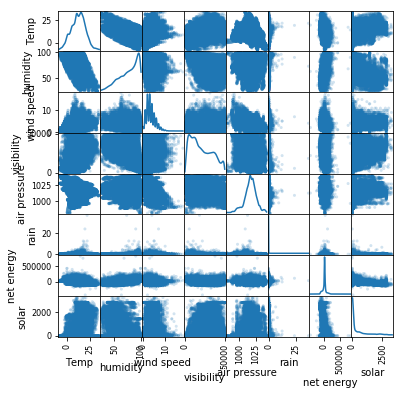

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix,
                  columns = ['Temp','humidity',
                              'wind speed','visibility',
                              'air pressure','rain',
                              'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [9]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)


# SGD Regression
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))

clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.0001,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)

print(prediction_error(clf.predict(X_val),labels_val))
print(prediction_error(clf.predict(X_test),labels_test))


[  56.10783721 -383.36758351   -1.85609016  -89.89791414    8.6000308
    3.51911061]
333.599509549
318.618358674


In [10]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)

print(prediction_error(ridge.predict(X_val),labels_val))
print(prediction_error(ridge.predict(X_test),labels_test))


[  46.11440813 -382.05615628   -1.41471158  -98.65586373   12.0200967
    4.45164664]
332.434615015
317.726548466
